In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sanjuan_dataset = pd.read_csv("../../dengueData/SanJuan/san_juan_training_data.csv")
print(sanjuan_dataset.head())
print("Number of observations: ", len(sanjuan_dataset))

      season  season_week week_start_date  denv1_cases  denv2_cases  \
0  1990/1991            1      1990-04-30            0            0   
1  1990/1991            2      1990-05-07            0            0   
2  1990/1991            3      1990-05-14            0            0   
3  1990/1991            4      1990-05-21            0            0   
4  1990/1991            5      1990-05-28            0            0   

   denv3_cases  denv4_cases  other_positive_cases  additional_cases  \
0            0            0                     4                 0   
1            0            0                     5                 0   
2            0            0                     4                 0   
3            0            0                     3                 0   
4            0            0                     6                 0   

   total_cases  
0            4  
1            5  
2            4  
3            3  
4            6  
Number of observations:  988


In [3]:
sanjuan_cases = sanjuan_dataset["total_cases"].values
print(sanjuan_cases.shape)

(988,)


In [4]:
def series_to_timeseries_window(data, windowSize):
    x = []
    y = []
    future_steps = 1
    for i in range(len(data)-windowSize-future_steps):
        x_observation = []
        y_observation = [data[i+windowSize+future_steps]]
        for j in range(windowSize):
            x_observation.append(data[i+j])
        x.append(x_observation)
        y.append(y_observation)
    return np.array(x), np.array(y)

In [5]:
#Test that the method works
test_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

tX, ty = series_to_timeseries_window(test_data, 4)

print(tX)
print(ty)

[[ 1  2  3  4]
 [ 2  3  4  5]
 [ 3  4  5  6]
 [ 4  5  6  7]
 [ 5  6  7  8]
 [ 6  7  8  9]
 [ 7  8  9 10]
 [ 8  9 10 11]
 [ 9 10 11 12]
 [10 11 12 13]]
[[ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]]


In [6]:
split_index = int(len(sanjuan_cases)* 0.7)
reframed_X, reframed_y = series_to_timeseries_window(sanjuan_cases, 4)

train_X = reframed_X[:split_index]
train_y = reframed_y[:split_index]

test_X = reframed_X[split_index:]
test_y = reframed_y[split_index:]

train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])

test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [7]:
print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

# print(test_X[-10:])
# print(test_y[-10:])
# print(iquitos_cases[-10:])

(691, 1, 4)
(691, 1)
(292, 1, 4)
(292, 1)


## Train model

In [71]:
def append_np(array, observation):
    newArray = None
    if(len(array.shape)==3):
        newArray = np.zeros((array.shape[0]+1, array.shape[1], array.shape[2]))
    elif(len(array.shape)==2):
        newArray = np.zeros((array.shape[0]+1, array.shape[1]))
    
    for i in range(len(array)):
        newArray[i] = array[i]
    newArray[-1] = observation
    return newArray

In [72]:
from keras.layers import Input, Flatten
from keras.layers.merge import concatenate
from keras.constraints import non_neg
from keras.models import Model
def createModel(modelName):
    jsonName = "{}.json".format(modelName)
    h5Name = "{}.h5".format(modelName)
    
    
    input_layer = Input(shape=(1,4))
    b1_out = LSTM(64, return_sequences=False)(input_layer)
    
    b2_out = Dense(32, activation="relu", kernel_regularizer="l2")(input_layer)
    b2_out = Flatten()(b2_out)
    
    concatenated = concatenate([b1_out, b2_out])
    out = Dense(4, activation="relu", kernel_regularizer="l2")(concatenated)
    out = Dense(4, activation="relu", kernel_regularizer="l2")(out)
    out = Dense(1, activation="linear", kernel_constraint=non_neg(), name='output_layer')(out)
    
    model = Model([input_layer], out)
    model.compile(loss=["mae"], optimizer="adam", metrics=["mse", "mae", "mape"])

    return model

In [73]:
history_X = np.copy(train_X)
history_y = np.copy(train_y)

predictions = np.zeros_like(test_y)

for i in range(len(test_X)):
    model = createModel("model")
    model.fit(history_X, history_y, epochs=100, batch_size=32, verbose=2, shuffle=False)
    y_obs = model.predict(test_X[i].reshape(1,1,4))
    
    predictions[i] = y_obs
    
    history_X = append_np(history_X, test_X[i])
    history_y = append_np(history_y, test_y[i])

Epoch 1/100
 - 3s - loss: 38.0554 - mean_squared_error: 4629.7054 - mean_absolute_error: 37.8604 - mean_absolute_percentage_error: 428154.8984
Epoch 2/100
 - 0s - loss: 35.4439 - mean_squared_error: 4148.8195 - mean_absolute_error: 35.2634 - mean_absolute_percentage_error: 1835954.9477
Epoch 3/100
 - 0s - loss: 30.8724 - mean_squared_error: 3366.3676 - mean_absolute_error: 30.6979 - mean_absolute_percentage_error: 4222876.1141
Epoch 4/100
 - 0s - loss: 23.7414 - mean_squared_error: 2274.7005 - mean_absolute_error: 23.5656 - mean_absolute_percentage_error: 8100247.5094
Epoch 5/100
 - 0s - loss: 15.7708 - mean_squared_error: 1164.2097 - mean_absolute_error: 15.5896 - mean_absolute_percentage_error: 12892906.3470
Epoch 6/100
 - 0s - loss: 12.8928 - mean_squared_error: 697.5398 - mean_absolute_error: 12.7107 - mean_absolute_percentage_error: 14719422.8777
Epoch 7/100
 - 0s - loss: 12.5612 - mean_squared_error: 659.9932 - mean_absolute_error: 12.3859 - mean_absolute_percentage_error: 136379

Epoch 58/100
 - 0s - loss: 11.1652 - mean_squared_error: 464.5598 - mean_absolute_error: 11.0018 - mean_absolute_percentage_error: 11821378.5132
Epoch 59/100
 - 0s - loss: 11.1278 - mean_squared_error: 461.3834 - mean_absolute_error: 10.9638 - mean_absolute_percentage_error: 11729539.8145
Epoch 60/100
 - 0s - loss: 11.1275 - mean_squared_error: 454.3505 - mean_absolute_error: 10.9626 - mean_absolute_percentage_error: 11593085.7700
Epoch 61/100
 - 0s - loss: 11.1698 - mean_squared_error: 468.3436 - mean_absolute_error: 11.0043 - mean_absolute_percentage_error: 11766171.2163
Epoch 62/100
 - 0s - loss: 11.1102 - mean_squared_error: 455.3445 - mean_absolute_error: 10.9440 - mean_absolute_percentage_error: 11573016.8589
Epoch 63/100
 - 0s - loss: 11.0983 - mean_squared_error: 451.2364 - mean_absolute_error: 10.9314 - mean_absolute_percentage_error: 11424451.6270
Epoch 64/100
 - 0s - loss: 11.1286 - mean_squared_error: 461.2729 - mean_absolute_error: 10.9610 - mean_absolute_percentage_error:

Epoch 15/100
 - 0s - loss: 11.5921 - mean_squared_error: 528.8040 - mean_absolute_error: 11.4399 - mean_absolute_percentage_error: 11501775.2468
Epoch 16/100
 - 0s - loss: 11.6562 - mean_squared_error: 526.0601 - mean_absolute_error: 11.5042 - mean_absolute_percentage_error: 12083702.8062
Epoch 17/100
 - 0s - loss: 11.4275 - mean_squared_error: 509.5422 - mean_absolute_error: 11.2760 - mean_absolute_percentage_error: 11457386.2610
Epoch 18/100
 - 0s - loss: 11.6779 - mean_squared_error: 517.5486 - mean_absolute_error: 11.5263 - mean_absolute_percentage_error: 12319618.2557
Epoch 19/100
 - 0s - loss: 11.3010 - mean_squared_error: 498.1915 - mean_absolute_error: 11.1497 - mean_absolute_percentage_error: 11423662.7434
Epoch 20/100
 - 0s - loss: 11.6762 - mean_squared_error: 515.0252 - mean_absolute_error: 11.5242 - mean_absolute_percentage_error: 12467694.4869
Epoch 21/100
 - 0s - loss: 11.3052 - mean_squared_error: 486.5178 - mean_absolute_error: 11.1535 - mean_absolute_percentage_error:

Epoch 72/100
 - 0s - loss: 10.9518 - mean_squared_error: 440.0344 - mean_absolute_error: 10.7817 - mean_absolute_percentage_error: 11301585.8990
Epoch 73/100
 - 0s - loss: 10.9306 - mean_squared_error: 433.8584 - mean_absolute_error: 10.7598 - mean_absolute_percentage_error: 11184034.3401
Epoch 74/100
 - 0s - loss: 10.9340 - mean_squared_error: 436.2570 - mean_absolute_error: 10.7626 - mean_absolute_percentage_error: 11178126.4000
Epoch 75/100
 - 0s - loss: 10.9313 - mean_squared_error: 438.9065 - mean_absolute_error: 10.7591 - mean_absolute_percentage_error: 11272654.0072
Epoch 76/100
 - 0s - loss: 10.9093 - mean_squared_error: 433.0919 - mean_absolute_error: 10.7364 - mean_absolute_percentage_error: 11127667.6597
Epoch 77/100
 - 0s - loss: 10.9121 - mean_squared_error: 434.1235 - mean_absolute_error: 10.7389 - mean_absolute_percentage_error: 11317205.4857
Epoch 78/100
 - 0s - loss: 10.8948 - mean_squared_error: 431.1209 - mean_absolute_error: 10.7214 - mean_absolute_percentage_error:

Epoch 29/100
 - 0s - loss: 11.7766 - mean_squared_error: 586.1213 - mean_absolute_error: 11.6133 - mean_absolute_percentage_error: 12511650.1612
Epoch 30/100
 - 0s - loss: 11.7505 - mean_squared_error: 580.1375 - mean_absolute_error: 11.5867 - mean_absolute_percentage_error: 12598839.4553
Epoch 31/100
 - 0s - loss: 11.7121 - mean_squared_error: 573.3268 - mean_absolute_error: 11.5477 - mean_absolute_percentage_error: 12671296.6895
Epoch 32/100
 - 0s - loss: 11.6812 - mean_squared_error: 566.2051 - mean_absolute_error: 11.5163 - mean_absolute_percentage_error: 12701682.8430
Epoch 33/100
 - 0s - loss: 11.6586 - mean_squared_error: 560.5523 - mean_absolute_error: 11.4933 - mean_absolute_percentage_error: 12730641.4964
Epoch 34/100
 - 0s - loss: 11.6140 - mean_squared_error: 554.0569 - mean_absolute_error: 11.4486 - mean_absolute_percentage_error: 12584383.5216
Epoch 35/100
 - 0s - loss: 11.6688 - mean_squared_error: 556.2926 - mean_absolute_error: 11.5030 - mean_absolute_percentage_error:

Epoch 86/100
 - 0s - loss: 11.2346 - mean_squared_error: 477.3686 - mean_absolute_error: 11.0532 - mean_absolute_percentage_error: 12341051.6882
Epoch 87/100
 - 0s - loss: 11.2233 - mean_squared_error: 481.4648 - mean_absolute_error: 11.0418 - mean_absolute_percentage_error: 12282506.7939
Epoch 88/100
 - 0s - loss: 11.2375 - mean_squared_error: 474.9099 - mean_absolute_error: 11.0554 - mean_absolute_percentage_error: 12298522.5572
Epoch 89/100
 - 0s - loss: 11.2545 - mean_squared_error: 483.4437 - mean_absolute_error: 11.0726 - mean_absolute_percentage_error: 12382778.4764
Epoch 90/100
 - 0s - loss: 11.2180 - mean_squared_error: 472.9444 - mean_absolute_error: 11.0359 - mean_absolute_percentage_error: 12231283.5108
Epoch 91/100
 - 0s - loss: 11.2142 - mean_squared_error: 477.8576 - mean_absolute_error: 11.0320 - mean_absolute_percentage_error: 12197965.4911
Epoch 92/100
 - 0s - loss: 11.2170 - mean_squared_error: 472.4817 - mean_absolute_error: 11.0342 - mean_absolute_percentage_error:

Epoch 43/100
 - 0s - loss: 11.0571 - mean_squared_error: 456.3913 - mean_absolute_error: 10.9019 - mean_absolute_percentage_error: 11818370.1299
Epoch 44/100
 - 0s - loss: 11.0875 - mean_squared_error: 460.8091 - mean_absolute_error: 10.9316 - mean_absolute_percentage_error: 11908725.8508
Epoch 45/100
 - 0s - loss: 11.0475 - mean_squared_error: 456.8769 - mean_absolute_error: 10.8909 - mean_absolute_percentage_error: 11994661.4918
Epoch 46/100
 - 0s - loss: 10.9931 - mean_squared_error: 453.7061 - mean_absolute_error: 10.8360 - mean_absolute_percentage_error: 11585547.0685
Epoch 47/100
 - 0s - loss: 10.9792 - mean_squared_error: 448.7560 - mean_absolute_error: 10.8217 - mean_absolute_percentage_error: 11411835.9352
Epoch 48/100
 - 0s - loss: 10.9795 - mean_squared_error: 450.2857 - mean_absolute_error: 10.8217 - mean_absolute_percentage_error: 11556203.5688
Epoch 49/100
 - 0s - loss: 11.0050 - mean_squared_error: 447.6613 - mean_absolute_error: 10.8470 - mean_absolute_percentage_error:

Epoch 100/100
 - 0s - loss: 10.7190 - mean_squared_error: 415.8564 - mean_absolute_error: 10.5344 - mean_absolute_percentage_error: 12205034.1446
Epoch 1/100
 - 4s - loss: 25.0369 - mean_squared_error: 2292.5969 - mean_absolute_error: 24.8494 - mean_absolute_percentage_error: 5795673.1023
Epoch 2/100
 - 0s - loss: 14.8347 - mean_squared_error: 992.8238 - mean_absolute_error: 14.6485 - mean_absolute_percentage_error: 11180320.6210
Epoch 3/100
 - 0s - loss: 12.9315 - mean_squared_error: 704.5554 - mean_absolute_error: 12.7481 - mean_absolute_percentage_error: 12361076.2347
Epoch 4/100
 - 0s - loss: 12.5069 - mean_squared_error: 675.7221 - mean_absolute_error: 12.3293 - mean_absolute_percentage_error: 11300759.1190
Epoch 5/100
 - 0s - loss: 12.3519 - mean_squared_error: 648.8109 - mean_absolute_error: 12.1784 - mean_absolute_percentage_error: 11351719.9960
Epoch 6/100
 - 0s - loss: 12.1819 - mean_squared_error: 623.3563 - mean_absolute_error: 12.0116 - mean_absolute_percentage_error: 1116

Epoch 57/100
 - 0s - loss: 11.0181 - mean_squared_error: 446.9334 - mean_absolute_error: 10.8488 - mean_absolute_percentage_error: 10234462.0290
Epoch 58/100
 - 0s - loss: 11.0297 - mean_squared_error: 444.5214 - mean_absolute_error: 10.8600 - mean_absolute_percentage_error: 10218427.3993
Epoch 59/100
 - 0s - loss: 11.0234 - mean_squared_error: 443.4668 - mean_absolute_error: 10.8536 - mean_absolute_percentage_error: 10189758.1902
Epoch 60/100
 - 0s - loss: 11.0264 - mean_squared_error: 445.8777 - mean_absolute_error: 10.8563 - mean_absolute_percentage_error: 10249884.6589
Epoch 61/100
 - 0s - loss: 11.0161 - mean_squared_error: 446.1732 - mean_absolute_error: 10.8458 - mean_absolute_percentage_error: 10274624.8702
Epoch 62/100
 - 0s - loss: 11.0065 - mean_squared_error: 443.6228 - mean_absolute_error: 10.8359 - mean_absolute_percentage_error: 10243463.6490
Epoch 63/100
 - 0s - loss: 11.0075 - mean_squared_error: 443.4404 - mean_absolute_error: 10.8367 - mean_absolute_percentage_error:

Epoch 14/100
 - 0s - loss: 12.7081 - mean_squared_error: 749.0578 - mean_absolute_error: 12.5810 - mean_absolute_percentage_error: 12150984.5030
Epoch 15/100
 - 0s - loss: 12.6061 - mean_squared_error: 731.6120 - mean_absolute_error: 12.4798 - mean_absolute_percentage_error: 12267755.0131
Epoch 16/100
 - 0s - loss: 12.5097 - mean_squared_error: 715.2221 - mean_absolute_error: 12.3839 - mean_absolute_percentage_error: 12196702.3836
Epoch 17/100
 - 0s - loss: 12.4326 - mean_squared_error: 704.7879 - mean_absolute_error: 12.3071 - mean_absolute_percentage_error: 12151841.7003
Epoch 18/100
 - 0s - loss: 12.3653 - mean_squared_error: 693.1234 - mean_absolute_error: 12.2399 - mean_absolute_percentage_error: 12142979.4063
Epoch 19/100
 - 0s - loss: 12.3007 - mean_squared_error: 681.5490 - mean_absolute_error: 12.1754 - mean_absolute_percentage_error: 12163002.4763
Epoch 20/100
 - 0s - loss: 12.2385 - mean_squared_error: 672.1709 - mean_absolute_error: 12.1131 - mean_absolute_percentage_error:

Epoch 71/100
 - 0s - loss: 11.2568 - mean_squared_error: 485.0248 - mean_absolute_error: 11.1249 - mean_absolute_percentage_error: 11870353.6706
Epoch 72/100
 - 0s - loss: 11.2367 - mean_squared_error: 481.1268 - mean_absolute_error: 11.1042 - mean_absolute_percentage_error: 11867778.4392
Epoch 73/100
 - 0s - loss: 11.2040 - mean_squared_error: 478.6904 - mean_absolute_error: 11.0713 - mean_absolute_percentage_error: 11702857.3965
Epoch 74/100
 - 0s - loss: 11.2419 - mean_squared_error: 482.0825 - mean_absolute_error: 11.1088 - mean_absolute_percentage_error: 11854233.7899
Epoch 75/100
 - 0s - loss: 11.2203 - mean_squared_error: 478.0296 - mean_absolute_error: 11.0867 - mean_absolute_percentage_error: 11890724.2811
Epoch 76/100
 - 0s - loss: 11.1890 - mean_squared_error: 475.0815 - mean_absolute_error: 11.0551 - mean_absolute_percentage_error: 11741777.6060
Epoch 77/100
 - 0s - loss: 11.2251 - mean_squared_error: 478.9158 - mean_absolute_error: 11.0907 - mean_absolute_percentage_error:

Epoch 28/100
 - 0s - loss: 11.3721 - mean_squared_error: 490.0051 - mean_absolute_error: 11.2467 - mean_absolute_percentage_error: 11288953.2920
Epoch 29/100
 - 0s - loss: 11.3806 - mean_squared_error: 489.9314 - mean_absolute_error: 11.2551 - mean_absolute_percentage_error: 11365489.7135
Epoch 30/100
 - 0s - loss: 11.3419 - mean_squared_error: 485.4602 - mean_absolute_error: 11.2163 - mean_absolute_percentage_error: 11275185.0820
Epoch 31/100
 - 0s - loss: 11.3288 - mean_squared_error: 484.5101 - mean_absolute_error: 11.2030 - mean_absolute_percentage_error: 11236706.3335
Epoch 32/100
 - 0s - loss: 11.3301 - mean_squared_error: 482.9140 - mean_absolute_error: 11.2039 - mean_absolute_percentage_error: 11380716.6539
Epoch 33/100
 - 0s - loss: 11.3037 - mean_squared_error: 480.1436 - mean_absolute_error: 11.1770 - mean_absolute_percentage_error: 11313902.3423
Epoch 34/100
 - 0s - loss: 11.3123 - mean_squared_error: 478.9090 - mean_absolute_error: 11.1852 - mean_absolute_percentage_error:

Epoch 85/100
 - 0s - loss: 10.7838 - mean_squared_error: 421.1389 - mean_absolute_error: 10.6222 - mean_absolute_percentage_error: 10465813.5001
Epoch 86/100
 - 0s - loss: 10.7878 - mean_squared_error: 420.4578 - mean_absolute_error: 10.6254 - mean_absolute_percentage_error: 10243613.9262
Epoch 87/100
 - 0s - loss: 10.8818 - mean_squared_error: 424.8965 - mean_absolute_error: 10.7186 - mean_absolute_percentage_error: 10381598.0714
Epoch 88/100
 - 0s - loss: 10.9608 - mean_squared_error: 439.3702 - mean_absolute_error: 10.7970 - mean_absolute_percentage_error: 10875187.0217
Epoch 89/100
 - 0s - loss: 10.8485 - mean_squared_error: 433.2075 - mean_absolute_error: 10.6840 - mean_absolute_percentage_error: 10785828.5553
Epoch 90/100
 - 0s - loss: 10.7835 - mean_squared_error: 420.9990 - mean_absolute_error: 10.6181 - mean_absolute_percentage_error: 10605670.3973
Epoch 91/100
 - 0s - loss: 10.7720 - mean_squared_error: 422.5282 - mean_absolute_error: 10.6058 - mean_absolute_percentage_error:

Epoch 42/100
 - 0s - loss: 11.4258 - mean_squared_error: 510.4054 - mean_absolute_error: 11.2944 - mean_absolute_percentage_error: 12145607.1025
Epoch 43/100
 - 0s - loss: 11.4115 - mean_squared_error: 509.3528 - mean_absolute_error: 11.2797 - mean_absolute_percentage_error: 12114930.2729
Epoch 44/100
 - 0s - loss: 11.4122 - mean_squared_error: 508.2742 - mean_absolute_error: 11.2800 - mean_absolute_percentage_error: 12189359.6556
Epoch 45/100
 - 0s - loss: 11.3955 - mean_squared_error: 506.3194 - mean_absolute_error: 11.2628 - mean_absolute_percentage_error: 12179259.7199
Epoch 46/100
 - 0s - loss: 11.3820 - mean_squared_error: 505.0050 - mean_absolute_error: 11.2489 - mean_absolute_percentage_error: 12179963.1551
Epoch 47/100
 - 0s - loss: 11.4073 - mean_squared_error: 504.7542 - mean_absolute_error: 11.2736 - mean_absolute_percentage_error: 12385397.4459
Epoch 48/100
 - 0s - loss: 11.3636 - mean_squared_error: 499.2104 - mean_absolute_error: 11.2297 - mean_absolute_percentage_error:

Epoch 99/100
 - 0s - loss: 11.1591 - mean_squared_error: 467.0319 - mean_absolute_error: 11.0048 - mean_absolute_percentage_error: 11631729.9357
Epoch 100/100
 - 0s - loss: 11.0966 - mean_squared_error: 458.9842 - mean_absolute_error: 10.9419 - mean_absolute_percentage_error: 11422895.9720
Epoch 1/100
 - 5s - loss: 28.9566 - mean_squared_error: 2869.0950 - mean_absolute_error: 28.7724 - mean_absolute_percentage_error: 3755336.5749
Epoch 2/100
 - 0s - loss: 20.0712 - mean_squared_error: 1694.3439 - mean_absolute_error: 19.8933 - mean_absolute_percentage_error: 7271367.0694
Epoch 3/100
 - 0s - loss: 14.8714 - mean_squared_error: 1033.4995 - mean_absolute_error: 14.6971 - mean_absolute_percentage_error: 10259893.9260
Epoch 4/100
 - 0s - loss: 13.1313 - mean_squared_error: 789.5602 - mean_absolute_error: 12.9610 - mean_absolute_percentage_error: 11708073.1247
Epoch 5/100
 - 0s - loss: 12.8393 - mean_squared_error: 735.5027 - mean_absolute_error: 12.6745 - mean_absolute_percentage_error: 11

Epoch 56/100
 - 0s - loss: 11.0971 - mean_squared_error: 468.7112 - mean_absolute_error: 10.9509 - mean_absolute_percentage_error: 11088031.5060
Epoch 57/100
 - 0s - loss: 11.0381 - mean_squared_error: 460.9211 - mean_absolute_error: 10.8915 - mean_absolute_percentage_error: 10667903.1001
Epoch 58/100
 - 0s - loss: 11.0531 - mean_squared_error: 467.4329 - mean_absolute_error: 10.9060 - mean_absolute_percentage_error: 10830808.5696
Epoch 59/100
 - 0s - loss: 11.0363 - mean_squared_error: 460.3014 - mean_absolute_error: 10.8884 - mean_absolute_percentage_error: 10627636.8975
Epoch 60/100
 - 0s - loss: 11.0440 - mean_squared_error: 466.4547 - mean_absolute_error: 10.8956 - mean_absolute_percentage_error: 10760860.8682
Epoch 61/100
 - 0s - loss: 11.0271 - mean_squared_error: 460.3012 - mean_absolute_error: 10.8779 - mean_absolute_percentage_error: 10492123.0937
Epoch 62/100
 - 0s - loss: 11.0289 - mean_squared_error: 464.4279 - mean_absolute_error: 10.8793 - mean_absolute_percentage_error:

Epoch 13/100
 - 0s - loss: 11.9667 - mean_squared_error: 626.7551 - mean_absolute_error: 11.8419 - mean_absolute_percentage_error: 11205824.1286
Epoch 14/100
 - 0s - loss: 11.9067 - mean_squared_error: 612.3252 - mean_absolute_error: 11.7821 - mean_absolute_percentage_error: 11210292.9270
Epoch 15/100
 - 0s - loss: 11.8458 - mean_squared_error: 597.5251 - mean_absolute_error: 11.7213 - mean_absolute_percentage_error: 11228102.6359
Epoch 16/100
 - 0s - loss: 11.7750 - mean_squared_error: 586.3351 - mean_absolute_error: 11.6506 - mean_absolute_percentage_error: 11133042.8481
Epoch 17/100
 - 0s - loss: 11.7257 - mean_squared_error: 575.7353 - mean_absolute_error: 11.6013 - mean_absolute_percentage_error: 11131103.0792
Epoch 18/100
 - 0s - loss: 11.7208 - mean_squared_error: 569.2293 - mean_absolute_error: 11.5965 - mean_absolute_percentage_error: 11250740.7535
Epoch 19/100
 - 0s - loss: 11.6653 - mean_squared_error: 560.1926 - mean_absolute_error: 11.5409 - mean_absolute_percentage_error:

Epoch 70/100
 - 0s - loss: 10.9476 - mean_squared_error: 455.3550 - mean_absolute_error: 10.7912 - mean_absolute_percentage_error: 11265166.2347
Epoch 71/100
 - 0s - loss: 10.9477 - mean_squared_error: 454.4164 - mean_absolute_error: 10.7905 - mean_absolute_percentage_error: 11412732.0957
Epoch 72/100
 - 0s - loss: 10.9454 - mean_squared_error: 453.4224 - mean_absolute_error: 10.7872 - mean_absolute_percentage_error: 11343721.7225
Epoch 73/100
 - 0s - loss: 10.9312 - mean_squared_error: 452.3711 - mean_absolute_error: 10.7722 - mean_absolute_percentage_error: 11526898.5130
Epoch 74/100
 - 0s - loss: 10.9370 - mean_squared_error: 451.9435 - mean_absolute_error: 10.7774 - mean_absolute_percentage_error: 11486787.8159
Epoch 75/100
 - 0s - loss: 11.0178 - mean_squared_error: 455.3790 - mean_absolute_error: 10.8572 - mean_absolute_percentage_error: 11828304.8666
Epoch 76/100
 - 0s - loss: 10.9380 - mean_squared_error: 454.1944 - mean_absolute_error: 10.7771 - mean_absolute_percentage_error:

Epoch 27/100
 - 0s - loss: 11.4200 - mean_squared_error: 512.0125 - mean_absolute_error: 11.2907 - mean_absolute_percentage_error: 12193834.4107
Epoch 28/100
 - 0s - loss: 11.5137 - mean_squared_error: 514.3706 - mean_absolute_error: 11.3836 - mean_absolute_percentage_error: 12521649.9824
Epoch 29/100
 - 0s - loss: 11.3574 - mean_squared_error: 501.4929 - mean_absolute_error: 11.2274 - mean_absolute_percentage_error: 11570736.4285
Epoch 30/100
 - 0s - loss: 11.3868 - mean_squared_error: 503.1812 - mean_absolute_error: 11.2563 - mean_absolute_percentage_error: 11953010.2648
Epoch 31/100
 - 0s - loss: 11.3763 - mean_squared_error: 503.2518 - mean_absolute_error: 11.2454 - mean_absolute_percentage_error: 11958133.9531
Epoch 32/100
 - 0s - loss: 11.3713 - mean_squared_error: 499.6043 - mean_absolute_error: 11.2400 - mean_absolute_percentage_error: 11873573.7981
Epoch 33/100
 - 0s - loss: 11.2995 - mean_squared_error: 494.6436 - mean_absolute_error: 11.1681 - mean_absolute_percentage_error:

Epoch 84/100
 - 0s - loss: 10.9882 - mean_squared_error: 445.9105 - mean_absolute_error: 10.8235 - mean_absolute_percentage_error: 12180950.2081
Epoch 85/100
 - 0s - loss: 10.8886 - mean_squared_error: 436.7035 - mean_absolute_error: 10.7237 - mean_absolute_percentage_error: 11720781.8742
Epoch 86/100
 - 0s - loss: 10.8903 - mean_squared_error: 436.6152 - mean_absolute_error: 10.7248 - mean_absolute_percentage_error: 11678133.2497
Epoch 87/100
 - 0s - loss: 10.8868 - mean_squared_error: 435.2607 - mean_absolute_error: 10.7205 - mean_absolute_percentage_error: 11663481.0394
Epoch 88/100
 - 0s - loss: 10.9020 - mean_squared_error: 437.4240 - mean_absolute_error: 10.7347 - mean_absolute_percentage_error: 12117450.7340
Epoch 89/100
 - 0s - loss: 10.8584 - mean_squared_error: 433.9518 - mean_absolute_error: 10.6904 - mean_absolute_percentage_error: 11829305.4138
Epoch 90/100
 - 0s - loss: 10.8707 - mean_squared_error: 434.3323 - mean_absolute_error: 10.7021 - mean_absolute_percentage_error:

Epoch 41/100
 - 0s - loss: 11.4948 - mean_squared_error: 502.2540 - mean_absolute_error: 11.3268 - mean_absolute_percentage_error: 12520337.8629
Epoch 42/100
 - 0s - loss: 11.2644 - mean_squared_error: 486.4893 - mean_absolute_error: 11.0962 - mean_absolute_percentage_error: 11536242.3086
Epoch 43/100
 - 0s - loss: 11.4773 - mean_squared_error: 499.0066 - mean_absolute_error: 11.3074 - mean_absolute_percentage_error: 12517120.0190
Epoch 44/100
 - 0s - loss: 11.2730 - mean_squared_error: 483.1354 - mean_absolute_error: 11.1029 - mean_absolute_percentage_error: 11641649.0294
Epoch 45/100
 - 0s - loss: 11.4417 - mean_squared_error: 493.3364 - mean_absolute_error: 11.2707 - mean_absolute_percentage_error: 12454247.6794
Epoch 46/100
 - 0s - loss: 11.2462 - mean_squared_error: 479.7887 - mean_absolute_error: 11.0752 - mean_absolute_percentage_error: 11500979.3949
Epoch 47/100
 - 0s - loss: 11.3075 - mean_squared_error: 486.1462 - mean_absolute_error: 11.1357 - mean_absolute_percentage_error:

Epoch 98/100
 - 0s - loss: 11.0341 - mean_squared_error: 441.6777 - mean_absolute_error: 10.8186 - mean_absolute_percentage_error: 10527487.8415
Epoch 99/100
 - 0s - loss: 11.0260 - mean_squared_error: 441.0392 - mean_absolute_error: 10.8099 - mean_absolute_percentage_error: 10497086.5873
Epoch 100/100
 - 0s - loss: 11.0223 - mean_squared_error: 441.0227 - mean_absolute_error: 10.8055 - mean_absolute_percentage_error: 10439782.6441
Epoch 1/100
 - 6s - loss: 34.9043 - mean_squared_error: 3929.2249 - mean_absolute_error: 34.7111 - mean_absolute_percentage_error: 1303320.1465
Epoch 2/100
 - 0s - loss: 31.6805 - mean_squared_error: 3386.8068 - mean_absolute_error: 31.4997 - mean_absolute_percentage_error: 2621622.6571
Epoch 3/100
 - 0s - loss: 26.7292 - mean_squared_error: 2622.8849 - mean_absolute_error: 26.5531 - mean_absolute_percentage_error: 4714208.8104
Epoch 4/100
 - 0s - loss: 19.9877 - mean_squared_error: 1703.7420 - mean_absolute_error: 19.8098 - mean_absolute_percentage_error: 7

Epoch 55/100
 - 0s - loss: 11.3710 - mean_squared_error: 504.4196 - mean_absolute_error: 11.2075 - mean_absolute_percentage_error: 11793652.9588
Epoch 56/100
 - 0s - loss: 11.4303 - mean_squared_error: 506.4466 - mean_absolute_error: 11.2659 - mean_absolute_percentage_error: 12113870.0216
Epoch 57/100
 - 0s - loss: 11.3329 - mean_squared_error: 497.5028 - mean_absolute_error: 11.1692 - mean_absolute_percentage_error: 11441376.0758
Epoch 58/100
 - 0s - loss: 11.4810 - mean_squared_error: 508.1636 - mean_absolute_error: 11.3161 - mean_absolute_percentage_error: 12228856.1853
Epoch 59/100
 - 0s - loss: 11.3087 - mean_squared_error: 492.2368 - mean_absolute_error: 11.1440 - mean_absolute_percentage_error: 11301806.9643
Epoch 60/100
 - 0s - loss: 11.4620 - mean_squared_error: 505.9386 - mean_absolute_error: 11.2963 - mean_absolute_percentage_error: 12152481.2579
Epoch 61/100
 - 0s - loss: 11.2950 - mean_squared_error: 489.6902 - mean_absolute_error: 11.1295 - mean_absolute_percentage_error:

Epoch 12/100
 - 0s - loss: 12.4131 - mean_squared_error: 670.9572 - mean_absolute_error: 12.2157 - mean_absolute_percentage_error: 11424792.9920
Epoch 13/100
 - 0s - loss: 12.3517 - mean_squared_error: 661.7855 - mean_absolute_error: 12.1563 - mean_absolute_percentage_error: 11349033.4346
Epoch 14/100
 - 0s - loss: 12.2917 - mean_squared_error: 652.2009 - mean_absolute_error: 12.0978 - mean_absolute_percentage_error: 11313872.4282
Epoch 15/100
 - 0s - loss: 12.2368 - mean_squared_error: 642.9588 - mean_absolute_error: 12.0440 - mean_absolute_percentage_error: 11298427.1709
Epoch 16/100
 - 0s - loss: 12.1795 - mean_squared_error: 634.1863 - mean_absolute_error: 11.9875 - mean_absolute_percentage_error: 11315296.8119
Epoch 17/100
 - 0s - loss: 12.1240 - mean_squared_error: 625.8883 - mean_absolute_error: 11.9328 - mean_absolute_percentage_error: 11330736.6201
Epoch 18/100
 - 0s - loss: 12.0789 - mean_squared_error: 618.2032 - mean_absolute_error: 11.8881 - mean_absolute_percentage_error:

Epoch 69/100
 - 0s - loss: 11.3791 - mean_squared_error: 491.4145 - mean_absolute_error: 11.1750 - mean_absolute_percentage_error: 12609403.8079
Epoch 70/100
 - 0s - loss: 11.2793 - mean_squared_error: 480.0427 - mean_absolute_error: 11.0747 - mean_absolute_percentage_error: 12086467.9112
Epoch 71/100
 - 0s - loss: 11.3659 - mean_squared_error: 488.7561 - mean_absolute_error: 11.1598 - mean_absolute_percentage_error: 12621019.8798
Epoch 72/100
 - 0s - loss: 11.2686 - mean_squared_error: 478.4998 - mean_absolute_error: 11.0621 - mean_absolute_percentage_error: 12101042.4583
Epoch 73/100
 - 0s - loss: 11.3520 - mean_squared_error: 487.5884 - mean_absolute_error: 11.1441 - mean_absolute_percentage_error: 12585861.9525
Epoch 74/100
 - 0s - loss: 11.2589 - mean_squared_error: 477.0276 - mean_absolute_error: 11.0504 - mean_absolute_percentage_error: 12114889.7405
Epoch 75/100
 - 0s - loss: 11.3425 - mean_squared_error: 486.1806 - mean_absolute_error: 11.1325 - mean_absolute_percentage_error:

Epoch 26/100
 - 0s - loss: 11.4233 - mean_squared_error: 500.3692 - mean_absolute_error: 11.2738 - mean_absolute_percentage_error: 11395086.7884
Epoch 27/100
 - 0s - loss: 11.2903 - mean_squared_error: 488.2566 - mean_absolute_error: 11.1408 - mean_absolute_percentage_error: 10839875.3199
Epoch 28/100
 - 0s - loss: 11.3164 - mean_squared_error: 489.7449 - mean_absolute_error: 11.1665 - mean_absolute_percentage_error: 10971032.4395
Epoch 29/100
 - 0s - loss: 11.2926 - mean_squared_error: 487.5048 - mean_absolute_error: 11.1424 - mean_absolute_percentage_error: 10963482.4098
Epoch 30/100
 - 0s - loss: 11.2842 - mean_squared_error: 486.2754 - mean_absolute_error: 11.1334 - mean_absolute_percentage_error: 10941849.1066
Epoch 31/100
 - 0s - loss: 11.2885 - mean_squared_error: 484.7577 - mean_absolute_error: 11.1372 - mean_absolute_percentage_error: 10962355.3545
Epoch 32/100
 - 0s - loss: 11.2638 - mean_squared_error: 483.4268 - mean_absolute_error: 11.1120 - mean_absolute_percentage_error:

Epoch 83/100
 - 0s - loss: 10.9732 - mean_squared_error: 436.5220 - mean_absolute_error: 10.7778 - mean_absolute_percentage_error: 10095200.0684
Epoch 84/100
 - 0s - loss: 11.0842 - mean_squared_error: 449.5275 - mean_absolute_error: 10.8878 - mean_absolute_percentage_error: 10664838.2441
Epoch 85/100
 - 0s - loss: 10.9225 - mean_squared_error: 434.6758 - mean_absolute_error: 10.7256 - mean_absolute_percentage_error: 10044931.4921
Epoch 86/100
 - 0s - loss: 10.9228 - mean_squared_error: 431.6298 - mean_absolute_error: 10.7256 - mean_absolute_percentage_error: 10232582.9997
Epoch 87/100
 - 0s - loss: 10.9711 - mean_squared_error: 436.9314 - mean_absolute_error: 10.7734 - mean_absolute_percentage_error: 10316261.4007
Epoch 88/100
 - 0s - loss: 11.0489 - mean_squared_error: 447.6083 - mean_absolute_error: 10.8505 - mean_absolute_percentage_error: 10610441.8781
Epoch 89/100
 - 0s - loss: 10.9070 - mean_squared_error: 432.2247 - mean_absolute_error: 10.7080 - mean_absolute_percentage_error:

Epoch 40/100
 - 0s - loss: 11.1155 - mean_squared_error: 455.8770 - mean_absolute_error: 11.0023 - mean_absolute_percentage_error: 10825959.2053
Epoch 41/100
 - 0s - loss: 11.0485 - mean_squared_error: 446.1561 - mean_absolute_error: 10.9347 - mean_absolute_percentage_error: 10537454.1658
Epoch 42/100
 - 0s - loss: 11.1038 - mean_squared_error: 453.4100 - mean_absolute_error: 10.9892 - mean_absolute_percentage_error: 10908175.1704
Epoch 43/100
 - 0s - loss: 11.0330 - mean_squared_error: 445.0467 - mean_absolute_error: 10.9179 - mean_absolute_percentage_error: 10480540.8303
Epoch 44/100
 - 0s - loss: 11.0913 - mean_squared_error: 451.8017 - mean_absolute_error: 10.9754 - mean_absolute_percentage_error: 10822946.6725
Epoch 45/100
 - 0s - loss: 11.0251 - mean_squared_error: 444.8266 - mean_absolute_error: 10.9085 - mean_absolute_percentage_error: 10571003.2813
Epoch 46/100
 - 0s - loss: 11.0148 - mean_squared_error: 439.8897 - mean_absolute_error: 10.8976 - mean_absolute_percentage_error:

Epoch 97/100
 - 0s - loss: 10.7982 - mean_squared_error: 424.9973 - mean_absolute_error: 10.6458 - mean_absolute_percentage_error: 10557498.0140
Epoch 98/100
 - 0s - loss: 10.7849 - mean_squared_error: 423.8802 - mean_absolute_error: 10.6318 - mean_absolute_percentage_error: 10576156.2981
Epoch 99/100
 - 0s - loss: 10.7826 - mean_squared_error: 421.6069 - mean_absolute_error: 10.6289 - mean_absolute_percentage_error: 10602398.9800
Epoch 100/100
 - 0s - loss: 10.7993 - mean_squared_error: 424.1572 - mean_absolute_error: 10.6452 - mean_absolute_percentage_error: 10650013.4637
Epoch 1/100
 - 6s - loss: 28.7553 - mean_squared_error: 2939.0541 - mean_absolute_error: 28.5640 - mean_absolute_percentage_error: 2707738.4235
Epoch 2/100
 - 0s - loss: 22.6631 - mean_squared_error: 2115.0193 - mean_absolute_error: 22.4819 - mean_absolute_percentage_error: 5466029.4713
Epoch 3/100
 - 0s - loss: 17.2167 - mean_squared_error: 1393.6533 - mean_absolute_error: 17.0404 - mean_absolute_percentage_error: 

Epoch 54/100
 - 0s - loss: 11.1003 - mean_squared_error: 463.6134 - mean_absolute_error: 10.9415 - mean_absolute_percentage_error: 11425526.7997
Epoch 55/100
 - 0s - loss: 11.1837 - mean_squared_error: 473.7707 - mean_absolute_error: 11.0244 - mean_absolute_percentage_error: 11648772.0915
Epoch 56/100
 - 0s - loss: 11.1328 - mean_squared_error: 467.1154 - mean_absolute_error: 10.9732 - mean_absolute_percentage_error: 11463419.9325
Epoch 57/100
 - 0s - loss: 11.1282 - mean_squared_error: 463.9402 - mean_absolute_error: 10.9682 - mean_absolute_percentage_error: 11457941.5360
Epoch 58/100
 - 0s - loss: 11.0950 - mean_squared_error: 461.9788 - mean_absolute_error: 10.9345 - mean_absolute_percentage_error: 11334951.2487
Epoch 59/100
 - 0s - loss: 11.0501 - mean_squared_error: 457.0603 - mean_absolute_error: 10.8892 - mean_absolute_percentage_error: 11154917.5551
Epoch 60/100
 - 0s - loss: 11.0615 - mean_squared_error: 452.2200 - mean_absolute_error: 10.8996 - mean_absolute_percentage_error:

Epoch 11/100
 - 0s - loss: 11.7977 - mean_squared_error: 599.2908 - mean_absolute_error: 11.6322 - mean_absolute_percentage_error: 11222345.3873
Epoch 12/100
 - 0s - loss: 11.7003 - mean_squared_error: 578.0505 - mean_absolute_error: 11.5354 - mean_absolute_percentage_error: 11288339.7356
Epoch 13/100
 - 0s - loss: 11.6307 - mean_squared_error: 561.5524 - mean_absolute_error: 11.4664 - mean_absolute_percentage_error: 11370154.1313
Epoch 14/100
 - 0s - loss: 11.5765 - mean_squared_error: 547.8822 - mean_absolute_error: 11.4129 - mean_absolute_percentage_error: 11335191.8271
Epoch 15/100
 - 0s - loss: 11.4258 - mean_squared_error: 528.5522 - mean_absolute_error: 11.2629 - mean_absolute_percentage_error: 11202768.5880
Epoch 16/100
 - 0s - loss: 11.5131 - mean_squared_error: 528.6532 - mean_absolute_error: 11.3507 - mean_absolute_percentage_error: 11475297.4888
Epoch 17/100
 - 0s - loss: 11.3780 - mean_squared_error: 513.1042 - mean_absolute_error: 11.2164 - mean_absolute_percentage_error:

Epoch 68/100
 - 0s - loss: 10.9616 - mean_squared_error: 449.4108 - mean_absolute_error: 10.7936 - mean_absolute_percentage_error: 10957161.3671
Epoch 69/100
 - 0s - loss: 10.9437 - mean_squared_error: 448.3809 - mean_absolute_error: 10.7753 - mean_absolute_percentage_error: 10899859.1552
Epoch 70/100
 - 0s - loss: 10.9361 - mean_squared_error: 445.7305 - mean_absolute_error: 10.7672 - mean_absolute_percentage_error: 10865817.6802
Epoch 71/100
 - 0s - loss: 10.9375 - mean_squared_error: 445.9336 - mean_absolute_error: 10.7684 - mean_absolute_percentage_error: 10873956.0906
Epoch 72/100
 - 0s - loss: 10.9344 - mean_squared_error: 441.0503 - mean_absolute_error: 10.7648 - mean_absolute_percentage_error: 10889683.0437
Epoch 73/100
 - 0s - loss: 10.9516 - mean_squared_error: 442.9701 - mean_absolute_error: 10.7814 - mean_absolute_percentage_error: 11050444.8451
Epoch 74/100
 - 0s - loss: 10.9838 - mean_squared_error: 448.9225 - mean_absolute_error: 10.8130 - mean_absolute_percentage_error:

Epoch 25/100
 - 0s - loss: 11.2003 - mean_squared_error: 474.1057 - mean_absolute_error: 11.0521 - mean_absolute_percentage_error: 11138905.9903
Epoch 26/100
 - 0s - loss: 11.1480 - mean_squared_error: 465.0570 - mean_absolute_error: 10.9997 - mean_absolute_percentage_error: 11033478.9657
Epoch 27/100
 - 0s - loss: 11.1836 - mean_squared_error: 463.5695 - mean_absolute_error: 11.0348 - mean_absolute_percentage_error: 11300905.2514
Epoch 28/100
 - 0s - loss: 11.2061 - mean_squared_error: 469.5920 - mean_absolute_error: 11.0571 - mean_absolute_percentage_error: 11255968.8084
Epoch 29/100
 - 0s - loss: 11.1521 - mean_squared_error: 466.8758 - mean_absolute_error: 11.0032 - mean_absolute_percentage_error: 11044406.1356
Epoch 30/100
 - 0s - loss: 11.1126 - mean_squared_error: 458.5127 - mean_absolute_error: 10.9635 - mean_absolute_percentage_error: 11161602.5308
Epoch 31/100
 - 0s - loss: 11.1493 - mean_squared_error: 465.7611 - mean_absolute_error: 11.0001 - mean_absolute_percentage_error:

Epoch 82/100
 - 0s - loss: 10.6973 - mean_squared_error: 423.8867 - mean_absolute_error: 10.5313 - mean_absolute_percentage_error: 12367848.3694
Epoch 83/100
 - 0s - loss: 10.6077 - mean_squared_error: 412.6709 - mean_absolute_error: 10.4413 - mean_absolute_percentage_error: 12363196.1031
Epoch 84/100
 - 0s - loss: 10.6980 - mean_squared_error: 424.3218 - mean_absolute_error: 10.5312 - mean_absolute_percentage_error: 12203715.0155
Epoch 85/100
 - 0s - loss: 10.6109 - mean_squared_error: 411.9237 - mean_absolute_error: 10.4437 - mean_absolute_percentage_error: 12327370.2957
Epoch 86/100
 - 0s - loss: 10.7068 - mean_squared_error: 424.5707 - mean_absolute_error: 10.5391 - mean_absolute_percentage_error: 12387883.7160
Epoch 87/100
 - 0s - loss: 10.6497 - mean_squared_error: 418.2622 - mean_absolute_error: 10.4814 - mean_absolute_percentage_error: 12635680.0920
Epoch 88/100
 - 0s - loss: 10.7742 - mean_squared_error: 438.0103 - mean_absolute_error: 10.6056 - mean_absolute_percentage_error:

Epoch 39/100
 - 0s - loss: 11.1548 - mean_squared_error: 457.6010 - mean_absolute_error: 11.0183 - mean_absolute_percentage_error: 10644290.0151
Epoch 40/100
 - 0s - loss: 11.1469 - mean_squared_error: 459.2591 - mean_absolute_error: 11.0101 - mean_absolute_percentage_error: 10554509.3666
Epoch 41/100
 - 0s - loss: 11.1069 - mean_squared_error: 454.7236 - mean_absolute_error: 10.9696 - mean_absolute_percentage_error: 10542237.4096
Epoch 42/100
 - 0s - loss: 11.1267 - mean_squared_error: 454.8022 - mean_absolute_error: 10.9886 - mean_absolute_percentage_error: 10532905.3806
Epoch 43/100
 - 0s - loss: 11.1320 - mean_squared_error: 457.6923 - mean_absolute_error: 10.9934 - mean_absolute_percentage_error: 10536326.8491
Epoch 44/100
 - 0s - loss: 11.0953 - mean_squared_error: 452.6011 - mean_absolute_error: 10.9562 - mean_absolute_percentage_error: 10511470.4828
Epoch 45/100
 - 0s - loss: 11.1032 - mean_squared_error: 451.7678 - mean_absolute_error: 10.9635 - mean_absolute_percentage_error:

Epoch 96/100
 - 0s - loss: 10.7601 - mean_squared_error: 421.1395 - mean_absolute_error: 10.5843 - mean_absolute_percentage_error: 10399799.4181
Epoch 97/100
 - 0s - loss: 10.7596 - mean_squared_error: 422.2208 - mean_absolute_error: 10.5834 - mean_absolute_percentage_error: 10501472.4105
Epoch 98/100
 - 0s - loss: 10.7522 - mean_squared_error: 422.0881 - mean_absolute_error: 10.5758 - mean_absolute_percentage_error: 10457039.3684
Epoch 99/100
 - 0s - loss: 10.7723 - mean_squared_error: 424.1503 - mean_absolute_error: 10.5955 - mean_absolute_percentage_error: 10439112.1239
Epoch 100/100
 - 0s - loss: 10.7902 - mean_squared_error: 424.2147 - mean_absolute_error: 10.6129 - mean_absolute_percentage_error: 10858771.6792
Epoch 1/100
 - 7s - loss: 38.1502 - mean_squared_error: 4585.6032 - mean_absolute_error: 37.9830 - mean_absolute_percentage_error: 110152.8981
Epoch 2/100
 - 0s - loss: 37.8597 - mean_squared_error: 4563.2517 - mean_absolute_error: 37.7143 - mean_absolute_percentage_error: 

Epoch 53/100
 - 0s - loss: 11.3579 - mean_squared_error: 507.9805 - mean_absolute_error: 11.2320 - mean_absolute_percentage_error: 11375610.3760
Epoch 54/100
 - 0s - loss: 11.2958 - mean_squared_error: 504.3570 - mean_absolute_error: 11.1699 - mean_absolute_percentage_error: 11124506.4334
Epoch 55/100
 - 0s - loss: 11.3144 - mean_squared_error: 502.6399 - mean_absolute_error: 11.1881 - mean_absolute_percentage_error: 11258784.1161
Epoch 56/100
 - 0s - loss: 11.2694 - mean_squared_error: 498.0811 - mean_absolute_error: 11.1429 - mean_absolute_percentage_error: 11142197.6175
Epoch 57/100
 - 0s - loss: 11.3120 - mean_squared_error: 500.5235 - mean_absolute_error: 11.1851 - mean_absolute_percentage_error: 11285434.7260
Epoch 58/100
 - 0s - loss: 11.2572 - mean_squared_error: 496.2877 - mean_absolute_error: 11.1298 - mean_absolute_percentage_error: 11157055.4384
Epoch 59/100
 - 0s - loss: 11.2384 - mean_squared_error: 492.7927 - mean_absolute_error: 11.1104 - mean_absolute_percentage_error:

Epoch 10/100
 - 0s - loss: 12.1049 - mean_squared_error: 676.2559 - mean_absolute_error: 11.9634 - mean_absolute_percentage_error: 11865121.9650
Epoch 11/100
 - 0s - loss: 11.9732 - mean_squared_error: 642.3505 - mean_absolute_error: 11.8326 - mean_absolute_percentage_error: 11958020.9862
Epoch 12/100
 - 0s - loss: 11.8670 - mean_squared_error: 621.3346 - mean_absolute_error: 11.7276 - mean_absolute_percentage_error: 11909127.7375
Epoch 13/100
 - 0s - loss: 11.7733 - mean_squared_error: 605.6320 - mean_absolute_error: 11.6350 - mean_absolute_percentage_error: 11682728.2935
Epoch 14/100
 - 0s - loss: 11.7445 - mean_squared_error: 593.3401 - mean_absolute_error: 11.6071 - mean_absolute_percentage_error: 11838692.0774
Epoch 15/100
 - 0s - loss: 11.6734 - mean_squared_error: 581.2914 - mean_absolute_error: 11.5367 - mean_absolute_percentage_error: 11955405.8205
Epoch 16/100
 - 0s - loss: 11.6507 - mean_squared_error: 571.4278 - mean_absolute_error: 11.5145 - mean_absolute_percentage_error:

Epoch 67/100
 - 0s - loss: 10.8690 - mean_squared_error: 442.5908 - mean_absolute_error: 10.7124 - mean_absolute_percentage_error: 12299194.5961
Epoch 68/100
 - 0s - loss: 10.8764 - mean_squared_error: 444.7900 - mean_absolute_error: 10.7192 - mean_absolute_percentage_error: 12617284.9721
Epoch 69/100
 - 0s - loss: 10.8493 - mean_squared_error: 439.8475 - mean_absolute_error: 10.6916 - mean_absolute_percentage_error: 12281094.7626
Epoch 70/100
 - 0s - loss: 10.8382 - mean_squared_error: 438.5521 - mean_absolute_error: 10.6799 - mean_absolute_percentage_error: 12387099.0749
Epoch 71/100
 - 0s - loss: 10.8580 - mean_squared_error: 440.6302 - mean_absolute_error: 10.6992 - mean_absolute_percentage_error: 12615026.9996
Epoch 72/100
 - 0s - loss: 10.8279 - mean_squared_error: 437.7741 - mean_absolute_error: 10.6686 - mean_absolute_percentage_error: 12325696.1777
Epoch 73/100
 - 0s - loss: 10.8190 - mean_squared_error: 435.2511 - mean_absolute_error: 10.6589 - mean_absolute_percentage_error:

Epoch 24/100
 - 0s - loss: 11.3815 - mean_squared_error: 516.0229 - mean_absolute_error: 11.2742 - mean_absolute_percentage_error: 10803264.6904
Epoch 25/100
 - 0s - loss: 11.3638 - mean_squared_error: 513.2135 - mean_absolute_error: 11.2562 - mean_absolute_percentage_error: 10770730.6337
Epoch 26/100
 - 0s - loss: 11.3409 - mean_squared_error: 508.6788 - mean_absolute_error: 11.2329 - mean_absolute_percentage_error: 10833420.1518
Epoch 27/100
 - 0s - loss: 11.3094 - mean_squared_error: 503.7886 - mean_absolute_error: 11.2009 - mean_absolute_percentage_error: 10828568.7132
Epoch 28/100
 - 0s - loss: 11.3513 - mean_squared_error: 501.8232 - mean_absolute_error: 11.2421 - mean_absolute_percentage_error: 11127561.6059
Epoch 29/100
 - 0s - loss: 11.2223 - mean_squared_error: 494.9610 - mean_absolute_error: 11.1130 - mean_absolute_percentage_error: 10685586.0265
Epoch 30/100
 - 0s - loss: 11.3353 - mean_squared_error: 496.4807 - mean_absolute_error: 11.2252 - mean_absolute_percentage_error:

Epoch 81/100
 - 0s - loss: 10.8178 - mean_squared_error: 441.8219 - mean_absolute_error: 10.6690 - mean_absolute_percentage_error: 10821880.6457
Epoch 82/100
 - 0s - loss: 10.8314 - mean_squared_error: 446.2068 - mean_absolute_error: 10.6819 - mean_absolute_percentage_error: 11041493.0629
Epoch 83/100
 - 0s - loss: 10.8216 - mean_squared_error: 442.7440 - mean_absolute_error: 10.6716 - mean_absolute_percentage_error: 10738772.0976
Epoch 84/100
 - 0s - loss: 10.8169 - mean_squared_error: 442.8011 - mean_absolute_error: 10.6664 - mean_absolute_percentage_error: 10960079.1878
Epoch 85/100
 - 0s - loss: 10.8073 - mean_squared_error: 438.5855 - mean_absolute_error: 10.6565 - mean_absolute_percentage_error: 10736384.5704
Epoch 86/100
 - 0s - loss: 10.8187 - mean_squared_error: 443.6058 - mean_absolute_error: 10.6673 - mean_absolute_percentage_error: 10949011.2341
Epoch 87/100
 - 0s - loss: 10.8071 - mean_squared_error: 438.5978 - mean_absolute_error: 10.6553 - mean_absolute_percentage_error:

Epoch 38/100
 - 0s - loss: 11.3267 - mean_squared_error: 504.0433 - mean_absolute_error: 11.1960 - mean_absolute_percentage_error: 11890472.5877
Epoch 39/100
 - 0s - loss: 11.2970 - mean_squared_error: 501.0239 - mean_absolute_error: 11.1666 - mean_absolute_percentage_error: 11751117.8583
Epoch 40/100
 - 0s - loss: 11.3336 - mean_squared_error: 503.0713 - mean_absolute_error: 11.2031 - mean_absolute_percentage_error: 11955633.4970
Epoch 41/100
 - 0s - loss: 11.2636 - mean_squared_error: 496.0793 - mean_absolute_error: 11.1331 - mean_absolute_percentage_error: 11740713.6515
Epoch 42/100
 - 0s - loss: 11.3109 - mean_squared_error: 498.7955 - mean_absolute_error: 11.1801 - mean_absolute_percentage_error: 11990015.0205
Epoch 43/100
 - 0s - loss: 11.2432 - mean_squared_error: 492.1566 - mean_absolute_error: 11.1123 - mean_absolute_percentage_error: 11753850.6964
Epoch 44/100
 - 0s - loss: 11.3216 - mean_squared_error: 495.9426 - mean_absolute_error: 11.1904 - mean_absolute_percentage_error:

Epoch 95/100
 - 0s - loss: 10.9712 - mean_squared_error: 450.1765 - mean_absolute_error: 10.8179 - mean_absolute_percentage_error: 11046484.9974
Epoch 96/100
 - 0s - loss: 10.9845 - mean_squared_error: 450.9051 - mean_absolute_error: 10.8307 - mean_absolute_percentage_error: 11160556.4897
Epoch 97/100
 - 0s - loss: 11.0177 - mean_squared_error: 453.4124 - mean_absolute_error: 10.8633 - mean_absolute_percentage_error: 11395034.3056
Epoch 98/100
 - 0s - loss: 10.9601 - mean_squared_error: 449.3469 - mean_absolute_error: 10.8057 - mean_absolute_percentage_error: 11071568.6833
Epoch 99/100
 - 0s - loss: 10.9681 - mean_squared_error: 450.5486 - mean_absolute_error: 10.8132 - mean_absolute_percentage_error: 11141522.7371
Epoch 100/100
 - 0s - loss: 11.0099 - mean_squared_error: 452.8992 - mean_absolute_error: 10.8544 - mean_absolute_percentage_error: 11394811.9811
Epoch 1/100
 - 8s - loss: 34.0481 - mean_squared_error: 3899.5532 - mean_absolute_error: 33.8483 - mean_absolute_percentage_error

Epoch 52/100
 - 0s - loss: 11.0284 - mean_squared_error: 469.2304 - mean_absolute_error: 10.9081 - mean_absolute_percentage_error: 10976165.2484
Epoch 53/100
 - 0s - loss: 11.1292 - mean_squared_error: 475.8717 - mean_absolute_error: 11.0080 - mean_absolute_percentage_error: 11458800.2551
Epoch 54/100
 - 0s - loss: 11.0372 - mean_squared_error: 467.9646 - mean_absolute_error: 10.9151 - mean_absolute_percentage_error: 11130691.6655
Epoch 55/100
 - 0s - loss: 11.0370 - mean_squared_error: 465.8864 - mean_absolute_error: 10.9146 - mean_absolute_percentage_error: 11138704.5203
Epoch 56/100
 - 0s - loss: 11.0483 - mean_squared_error: 468.5823 - mean_absolute_error: 10.9253 - mean_absolute_percentage_error: 11146083.7165
Epoch 57/100
 - 0s - loss: 11.0084 - mean_squared_error: 463.1805 - mean_absolute_error: 10.8850 - mean_absolute_percentage_error: 11004346.8380
Epoch 58/100
 - 0s - loss: 11.0610 - mean_squared_error: 467.2891 - mean_absolute_error: 10.9371 - mean_absolute_percentage_error:

Epoch 9/100
 - 0s - loss: 12.4541 - mean_squared_error: 705.2113 - mean_absolute_error: 12.3229 - mean_absolute_percentage_error: 12510821.4599
Epoch 10/100
 - 0s - loss: 12.2640 - mean_squared_error: 681.0094 - mean_absolute_error: 12.1359 - mean_absolute_percentage_error: 11913416.5628
Epoch 11/100
 - 0s - loss: 12.1329 - mean_squared_error: 658.1704 - mean_absolute_error: 12.0066 - mean_absolute_percentage_error: 11657585.9201
Epoch 12/100
 - 0s - loss: 12.0171 - mean_squared_error: 639.4522 - mean_absolute_error: 11.8920 - mean_absolute_percentage_error: 11418631.9760
Epoch 13/100
 - 0s - loss: 11.9509 - mean_squared_error: 627.1950 - mean_absolute_error: 11.8266 - mean_absolute_percentage_error: 11405244.5681
Epoch 14/100
 - 0s - loss: 11.8702 - mean_squared_error: 613.7586 - mean_absolute_error: 11.7463 - mean_absolute_percentage_error: 11295573.9116
Epoch 15/100
 - 0s - loss: 11.8086 - mean_squared_error: 605.2714 - mean_absolute_error: 11.6851 - mean_absolute_percentage_error: 

Epoch 66/100
 - 0s - loss: 10.9221 - mean_squared_error: 445.8642 - mean_absolute_error: 10.7740 - mean_absolute_percentage_error: 10927738.1182
Epoch 67/100
 - 0s - loss: 10.9419 - mean_squared_error: 448.0056 - mean_absolute_error: 10.7925 - mean_absolute_percentage_error: 11026520.7885
Epoch 68/100
 - 0s - loss: 10.9125 - mean_squared_error: 442.7948 - mean_absolute_error: 10.7623 - mean_absolute_percentage_error: 10944762.9077
Epoch 69/100
 - 0s - loss: 10.9297 - mean_squared_error: 446.0153 - mean_absolute_error: 10.7784 - mean_absolute_percentage_error: 11024774.5315
Epoch 70/100
 - 0s - loss: 10.8990 - mean_squared_error: 441.6263 - mean_absolute_error: 10.7471 - mean_absolute_percentage_error: 10866240.8657
Epoch 71/100
 - 0s - loss: 10.9172 - mean_squared_error: 443.4348 - mean_absolute_error: 10.7641 - mean_absolute_percentage_error: 10971739.6346
Epoch 72/100
 - 0s - loss: 10.8871 - mean_squared_error: 438.9822 - mean_absolute_error: 10.7332 - mean_absolute_percentage_error:

Epoch 23/100
 - 0s - loss: 11.0805 - mean_squared_error: 465.0824 - mean_absolute_error: 10.9552 - mean_absolute_percentage_error: 11183692.9407
Epoch 24/100
 - 0s - loss: 11.0343 - mean_squared_error: 464.7672 - mean_absolute_error: 10.9086 - mean_absolute_percentage_error: 11140899.6806
Epoch 25/100
 - 0s - loss: 11.0779 - mean_squared_error: 466.5432 - mean_absolute_error: 10.9515 - mean_absolute_percentage_error: 11488487.6460
Epoch 26/100
 - 0s - loss: 10.9990 - mean_squared_error: 461.0996 - mean_absolute_error: 10.8725 - mean_absolute_percentage_error: 11112195.4132
Epoch 27/100
 - 0s - loss: 11.0368 - mean_squared_error: 464.3605 - mean_absolute_error: 10.9098 - mean_absolute_percentage_error: 11378392.4569
Epoch 28/100
 - 0s - loss: 11.0251 - mean_squared_error: 463.4070 - mean_absolute_error: 10.8978 - mean_absolute_percentage_error: 11277642.4563
Epoch 29/100
 - 0s - loss: 10.9556 - mean_squared_error: 454.7535 - mean_absolute_error: 10.8278 - mean_absolute_percentage_error:

Epoch 80/100
 - 0s - loss: 10.7044 - mean_squared_error: 422.8795 - mean_absolute_error: 10.5494 - mean_absolute_percentage_error: 10360121.5580
Epoch 81/100
 - 0s - loss: 10.6584 - mean_squared_error: 417.2293 - mean_absolute_error: 10.5028 - mean_absolute_percentage_error: 10169870.1962
Epoch 82/100
 - 0s - loss: 10.6888 - mean_squared_error: 420.9269 - mean_absolute_error: 10.5326 - mean_absolute_percentage_error: 10443389.1499
Epoch 83/100
 - 0s - loss: 10.6555 - mean_squared_error: 417.0340 - mean_absolute_error: 10.4986 - mean_absolute_percentage_error: 10185344.3792
Epoch 84/100
 - 0s - loss: 10.6748 - mean_squared_error: 418.3500 - mean_absolute_error: 10.5173 - mean_absolute_percentage_error: 10330242.7199
Epoch 85/100
 - 0s - loss: 10.6518 - mean_squared_error: 413.9030 - mean_absolute_error: 10.4936 - mean_absolute_percentage_error: 10239732.1578
Epoch 86/100
 - 0s - loss: 10.6762 - mean_squared_error: 418.4797 - mean_absolute_error: 10.5173 - mean_absolute_percentage_error:

Epoch 37/100
 - 0s - loss: 11.1373 - mean_squared_error: 487.4347 - mean_absolute_error: 10.9837 - mean_absolute_percentage_error: 10672145.5588
Epoch 38/100
 - 0s - loss: 11.2041 - mean_squared_error: 493.5917 - mean_absolute_error: 11.0498 - mean_absolute_percentage_error: 11246159.7653
Epoch 39/100
 - 0s - loss: 11.1060 - mean_squared_error: 482.8956 - mean_absolute_error: 10.9513 - mean_absolute_percentage_error: 10784530.4452
Epoch 40/100
 - 0s - loss: 11.1738 - mean_squared_error: 489.4533 - mean_absolute_error: 11.0182 - mean_absolute_percentage_error: 11245211.2220
Epoch 41/100
 - 0s - loss: 11.1089 - mean_squared_error: 483.3428 - mean_absolute_error: 10.9529 - mean_absolute_percentage_error: 10995743.3927
Epoch 42/100
 - 0s - loss: 11.1352 - mean_squared_error: 486.2328 - mean_absolute_error: 10.9787 - mean_absolute_percentage_error: 11217300.5956
Epoch 43/100
 - 0s - loss: 11.0960 - mean_squared_error: 480.2201 - mean_absolute_error: 10.9390 - mean_absolute_percentage_error:

Epoch 94/100
 - 0s - loss: 10.8497 - mean_squared_error: 443.8377 - mean_absolute_error: 10.6695 - mean_absolute_percentage_error: 11087705.9879
Epoch 95/100
 - 0s - loss: 10.8502 - mean_squared_error: 443.2334 - mean_absolute_error: 10.6696 - mean_absolute_percentage_error: 11016746.7559
Epoch 96/100
 - 0s - loss: 10.8588 - mean_squared_error: 442.6377 - mean_absolute_error: 10.6778 - mean_absolute_percentage_error: 11166198.2010
Epoch 97/100
 - 0s - loss: 10.8394 - mean_squared_error: 442.6208 - mean_absolute_error: 10.6580 - mean_absolute_percentage_error: 11015300.5232
Epoch 98/100
 - 0s - loss: 10.8434 - mean_squared_error: 441.7360 - mean_absolute_error: 10.6616 - mean_absolute_percentage_error: 11108948.9634
Epoch 99/100
 - 0s - loss: 10.8372 - mean_squared_error: 440.7443 - mean_absolute_error: 10.6551 - mean_absolute_percentage_error: 11121995.6450
Epoch 100/100
 - 0s - loss: 10.8451 - mean_squared_error: 443.7338 - mean_absolute_error: 10.6625 - mean_absolute_percentage_error

Epoch 51/100
 - 0s - loss: 11.0905 - mean_squared_error: 478.4698 - mean_absolute_error: 10.9596 - mean_absolute_percentage_error: 11205248.8192
Epoch 52/100
 - 0s - loss: 11.2988 - mean_squared_error: 489.3636 - mean_absolute_error: 11.1668 - mean_absolute_percentage_error: 12333245.5164
Epoch 53/100
 - 0s - loss: 11.0747 - mean_squared_error: 476.5823 - mean_absolute_error: 10.9428 - mean_absolute_percentage_error: 11197577.2869
Epoch 54/100
 - 0s - loss: 11.2874 - mean_squared_error: 487.4546 - mean_absolute_error: 11.1543 - mean_absolute_percentage_error: 12354422.0209
Epoch 55/100
 - 0s - loss: 11.0532 - mean_squared_error: 472.7002 - mean_absolute_error: 10.9201 - mean_absolute_percentage_error: 11222143.4264
Epoch 56/100
 - 0s - loss: 11.1828 - mean_squared_error: 481.4005 - mean_absolute_error: 11.0487 - mean_absolute_percentage_error: 12056257.6765
Epoch 57/100
 - 0s - loss: 11.0932 - mean_squared_error: 475.3169 - mean_absolute_error: 10.9587 - mean_absolute_percentage_error:

Epoch 8/100
 - 0s - loss: 12.6064 - mean_squared_error: 725.2442 - mean_absolute_error: 12.4212 - mean_absolute_percentage_error: 11649418.8796
Epoch 9/100
 - 0s - loss: 12.4583 - mean_squared_error: 699.2219 - mean_absolute_error: 12.2770 - mean_absolute_percentage_error: 11427586.4767
Epoch 10/100
 - 0s - loss: 12.3479 - mean_squared_error: 688.8097 - mean_absolute_error: 12.1695 - mean_absolute_percentage_error: 11278987.3939
Epoch 11/100
 - 0s - loss: 12.2256 - mean_squared_error: 666.4720 - mean_absolute_error: 12.0483 - mean_absolute_percentage_error: 11254651.4914
Epoch 12/100
 - 0s - loss: 12.1088 - mean_squared_error: 647.8273 - mean_absolute_error: 11.9323 - mean_absolute_percentage_error: 11199632.4333
Epoch 13/100
 - 0s - loss: 11.9954 - mean_squared_error: 626.8429 - mean_absolute_error: 11.8192 - mean_absolute_percentage_error: 11138497.8892
Epoch 14/100
 - 0s - loss: 11.9206 - mean_squared_error: 614.3238 - mean_absolute_error: 11.7447 - mean_absolute_percentage_error: 1

Epoch 65/100
 - 0s - loss: 11.0801 - mean_squared_error: 460.1279 - mean_absolute_error: 10.8842 - mean_absolute_percentage_error: 11224315.8412
Epoch 66/100
 - 0s - loss: 11.1105 - mean_squared_error: 461.6777 - mean_absolute_error: 10.9134 - mean_absolute_percentage_error: 11358846.3379
Epoch 67/100
 - 0s - loss: 11.0640 - mean_squared_error: 458.9199 - mean_absolute_error: 10.8668 - mean_absolute_percentage_error: 11139209.1494
Epoch 68/100
 - 0s - loss: 11.0761 - mean_squared_error: 458.5750 - mean_absolute_error: 10.8780 - mean_absolute_percentage_error: 11162040.9093
Epoch 69/100
 - 0s - loss: 11.1220 - mean_squared_error: 460.4337 - mean_absolute_error: 10.9225 - mean_absolute_percentage_error: 11441541.0064
Epoch 70/100
 - 0s - loss: 11.0461 - mean_squared_error: 455.6394 - mean_absolute_error: 10.8470 - mean_absolute_percentage_error: 11050165.9675
Epoch 71/100
 - 0s - loss: 11.0609 - mean_squared_error: 456.1297 - mean_absolute_error: 10.8610 - mean_absolute_percentage_error:

Epoch 22/100
 - 0s - loss: 12.2678 - mean_squared_error: 681.0217 - mean_absolute_error: 12.1161 - mean_absolute_percentage_error: 11477865.6673
Epoch 23/100
 - 0s - loss: 12.2146 - mean_squared_error: 671.6092 - mean_absolute_error: 12.0622 - mean_absolute_percentage_error: 11517889.7238
Epoch 24/100
 - 0s - loss: 12.1588 - mean_squared_error: 662.1096 - mean_absolute_error: 12.0056 - mean_absolute_percentage_error: 11493726.1822
Epoch 25/100
 - 0s - loss: 12.1095 - mean_squared_error: 653.9367 - mean_absolute_error: 11.9555 - mean_absolute_percentage_error: 11480743.5159
Epoch 26/100
 - 0s - loss: 12.0526 - mean_squared_error: 644.9369 - mean_absolute_error: 11.8978 - mean_absolute_percentage_error: 11464294.0589
Epoch 27/100
 - 0s - loss: 12.0004 - mean_squared_error: 635.6052 - mean_absolute_error: 11.8447 - mean_absolute_percentage_error: 11430780.9484
Epoch 28/100
 - 0s - loss: 11.9698 - mean_squared_error: 629.7065 - mean_absolute_error: 11.8135 - mean_absolute_percentage_error:

Epoch 79/100
 - 0s - loss: 11.2297 - mean_squared_error: 486.0987 - mean_absolute_error: 11.0738 - mean_absolute_percentage_error: 12029734.0579
Epoch 80/100
 - 0s - loss: 11.1441 - mean_squared_error: 477.7471 - mean_absolute_error: 10.9880 - mean_absolute_percentage_error: 11716991.8079
Epoch 81/100
 - 0s - loss: 11.2470 - mean_squared_error: 486.1758 - mean_absolute_error: 11.0900 - mean_absolute_percentage_error: 12165440.6831
Epoch 82/100
 - 0s - loss: 11.1400 - mean_squared_error: 475.2599 - mean_absolute_error: 10.9831 - mean_absolute_percentage_error: 11729522.7679
Epoch 83/100
 - 0s - loss: 11.2175 - mean_squared_error: 483.4713 - mean_absolute_error: 11.0603 - mean_absolute_percentage_error: 12049401.7525
Epoch 84/100
 - 0s - loss: 11.1258 - mean_squared_error: 474.7119 - mean_absolute_error: 10.9682 - mean_absolute_percentage_error: 11705538.9227
Epoch 85/100
 - 0s - loss: 11.2132 - mean_squared_error: 482.8936 - mean_absolute_error: 11.0549 - mean_absolute_percentage_error:

Epoch 36/100
 - 0s - loss: 11.2113 - mean_squared_error: 492.3581 - mean_absolute_error: 11.0553 - mean_absolute_percentage_error: 11506769.7897
Epoch 37/100
 - 0s - loss: 11.3277 - mean_squared_error: 502.3825 - mean_absolute_error: 11.1716 - mean_absolute_percentage_error: 12056138.1834
Epoch 38/100
 - 0s - loss: 11.1849 - mean_squared_error: 489.4677 - mean_absolute_error: 11.0294 - mean_absolute_percentage_error: 11389859.0774
Epoch 39/100
 - 0s - loss: 11.3376 - mean_squared_error: 501.8354 - mean_absolute_error: 11.1818 - mean_absolute_percentage_error: 12016803.3965
Epoch 40/100
 - 0s - loss: 11.1628 - mean_squared_error: 486.1804 - mean_absolute_error: 11.0071 - mean_absolute_percentage_error: 11324410.9010
Epoch 41/100
 - 0s - loss: 11.3299 - mean_squared_error: 499.8718 - mean_absolute_error: 11.1737 - mean_absolute_percentage_error: 12040271.7163
Epoch 42/100
 - 0s - loss: 11.1456 - mean_squared_error: 483.3353 - mean_absolute_error: 10.9896 - mean_absolute_percentage_error:

Epoch 93/100
 - 0s - loss: 10.9454 - mean_squared_error: 443.3348 - mean_absolute_error: 10.7632 - mean_absolute_percentage_error: 10985121.5569
Epoch 94/100
 - 0s - loss: 10.9872 - mean_squared_error: 449.0969 - mean_absolute_error: 10.8043 - mean_absolute_percentage_error: 11171655.7836
Epoch 95/100
 - 0s - loss: 10.9387 - mean_squared_error: 445.2534 - mean_absolute_error: 10.7556 - mean_absolute_percentage_error: 10937581.3136
Epoch 96/100
 - 0s - loss: 10.9356 - mean_squared_error: 441.0181 - mean_absolute_error: 10.7521 - mean_absolute_percentage_error: 10905494.1784
Epoch 97/100
 - 0s - loss: 10.9856 - mean_squared_error: 448.6466 - mean_absolute_error: 10.8014 - mean_absolute_percentage_error: 11118628.2464
Epoch 98/100
 - 0s - loss: 10.9332 - mean_squared_error: 443.7834 - mean_absolute_error: 10.7487 - mean_absolute_percentage_error: 10883972.3286
Epoch 99/100
 - 0s - loss: 10.9242 - mean_squared_error: 440.0935 - mean_absolute_error: 10.7391 - mean_absolute_percentage_error:

Epoch 50/100
 - 0s - loss: 11.2028 - mean_squared_error: 497.4849 - mean_absolute_error: 11.0546 - mean_absolute_percentage_error: 11904591.5374
Epoch 51/100
 - 0s - loss: 11.2348 - mean_squared_error: 498.7813 - mean_absolute_error: 11.0867 - mean_absolute_percentage_error: 12096940.9992
Epoch 52/100
 - 0s - loss: 11.1673 - mean_squared_error: 492.9079 - mean_absolute_error: 11.0195 - mean_absolute_percentage_error: 11831149.3793
Epoch 53/100
 - 0s - loss: 11.2916 - mean_squared_error: 500.6034 - mean_absolute_error: 11.1434 - mean_absolute_percentage_error: 12344367.0989
Epoch 54/100
 - 0s - loss: 11.1516 - mean_squared_error: 489.5298 - mean_absolute_error: 11.0041 - mean_absolute_percentage_error: 11817123.6430
Epoch 55/100
 - 0s - loss: 11.2815 - mean_squared_error: 498.3277 - mean_absolute_error: 11.1340 - mean_absolute_percentage_error: 12317455.5109
Epoch 56/100
 - 0s - loss: 11.1347 - mean_squared_error: 486.7077 - mean_absolute_error: 10.9877 - mean_absolute_percentage_error:

Epoch 7/100
 - 0s - loss: 11.8950 - mean_squared_error: 612.8023 - mean_absolute_error: 11.7512 - mean_absolute_percentage_error: 11099054.2791
Epoch 8/100
 - 0s - loss: 11.8045 - mean_squared_error: 599.4094 - mean_absolute_error: 11.6639 - mean_absolute_percentage_error: 11029973.6625
Epoch 9/100
 - 0s - loss: 11.7006 - mean_squared_error: 578.3516 - mean_absolute_error: 11.5619 - mean_absolute_percentage_error: 11101672.1591
Epoch 10/100
 - 0s - loss: 11.6067 - mean_squared_error: 563.4912 - mean_absolute_error: 11.4697 - mean_absolute_percentage_error: 10978117.8188
Epoch 11/100
 - 0s - loss: 11.5568 - mean_squared_error: 554.0898 - mean_absolute_error: 11.4213 - mean_absolute_percentage_error: 10973030.0499
Epoch 12/100
 - 0s - loss: 11.4743 - mean_squared_error: 543.2834 - mean_absolute_error: 11.3399 - mean_absolute_percentage_error: 10819354.6607
Epoch 13/100
 - 0s - loss: 11.4034 - mean_squared_error: 529.6905 - mean_absolute_error: 11.2695 - mean_absolute_percentage_error: 10

Epoch 64/100
 - 0s - loss: 10.7277 - mean_squared_error: 427.5382 - mean_absolute_error: 10.5656 - mean_absolute_percentage_error: 10377736.7740
Epoch 65/100
 - 0s - loss: 10.7577 - mean_squared_error: 427.8594 - mean_absolute_error: 10.5950 - mean_absolute_percentage_error: 10615177.9865
Epoch 66/100
 - 0s - loss: 10.7113 - mean_squared_error: 424.1120 - mean_absolute_error: 10.5484 - mean_absolute_percentage_error: 10234904.2971
Epoch 67/100
 - 0s - loss: 10.7222 - mean_squared_error: 423.2835 - mean_absolute_error: 10.5590 - mean_absolute_percentage_error: 10245507.7432
Epoch 68/100
 - 0s - loss: 10.7457 - mean_squared_error: 427.0229 - mean_absolute_error: 10.5818 - mean_absolute_percentage_error: 10528687.9872
Epoch 69/100
 - 0s - loss: 10.7399 - mean_squared_error: 427.9024 - mean_absolute_error: 10.5753 - mean_absolute_percentage_error: 10560867.6501
Epoch 70/100
 - 0s - loss: 10.6771 - mean_squared_error: 420.8389 - mean_absolute_error: 10.5122 - mean_absolute_percentage_error:

Epoch 21/100
 - 0s - loss: 11.5531 - mean_squared_error: 559.2516 - mean_absolute_error: 11.3881 - mean_absolute_percentage_error: 11386622.0694
Epoch 22/100
 - 0s - loss: 11.5027 - mean_squared_error: 551.7033 - mean_absolute_error: 11.3376 - mean_absolute_percentage_error: 11392965.6654
Epoch 23/100
 - 0s - loss: 11.4621 - mean_squared_error: 543.9492 - mean_absolute_error: 11.2971 - mean_absolute_percentage_error: 11395489.5840
Epoch 24/100
 - 0s - loss: 11.4361 - mean_squared_error: 537.5908 - mean_absolute_error: 11.2711 - mean_absolute_percentage_error: 11473709.1292
Epoch 25/100
 - 0s - loss: 11.3856 - mean_squared_error: 529.6362 - mean_absolute_error: 11.2206 - mean_absolute_percentage_error: 11391151.2973
Epoch 26/100
 - 0s - loss: 11.3701 - mean_squared_error: 524.8707 - mean_absolute_error: 11.2053 - mean_absolute_percentage_error: 11426159.3039
Epoch 27/100
 - 0s - loss: 11.3451 - mean_squared_error: 519.8533 - mean_absolute_error: 11.1803 - mean_absolute_percentage_error:

Epoch 78/100
 - 0s - loss: 10.8511 - mean_squared_error: 426.6736 - mean_absolute_error: 10.6502 - mean_absolute_percentage_error: 10064125.6792
Epoch 79/100
 - 0s - loss: 10.9775 - mean_squared_error: 448.5867 - mean_absolute_error: 10.7760 - mean_absolute_percentage_error: 10617475.8956
Epoch 80/100
 - 0s - loss: 10.8503 - mean_squared_error: 436.7743 - mean_absolute_error: 10.6484 - mean_absolute_percentage_error: 10296998.7846
Epoch 81/100
 - 0s - loss: 10.8310 - mean_squared_error: 427.5385 - mean_absolute_error: 10.6285 - mean_absolute_percentage_error: 10164103.4933
Epoch 82/100
 - 0s - loss: 10.8353 - mean_squared_error: 430.5710 - mean_absolute_error: 10.6323 - mean_absolute_percentage_error: 10158502.3236
Epoch 83/100
 - 0s - loss: 10.8130 - mean_squared_error: 426.2930 - mean_absolute_error: 10.6092 - mean_absolute_percentage_error: 10017775.7363
Epoch 84/100
 - 0s - loss: 10.8361 - mean_squared_error: 430.7696 - mean_absolute_error: 10.6316 - mean_absolute_percentage_error:

Epoch 35/100
 - 0s - loss: 11.2283 - mean_squared_error: 493.2249 - mean_absolute_error: 11.1003 - mean_absolute_percentage_error: 10967175.8593
Epoch 36/100
 - 0s - loss: 11.1351 - mean_squared_error: 487.6571 - mean_absolute_error: 11.0073 - mean_absolute_percentage_error: 10618835.8717
Epoch 37/100
 - 0s - loss: 11.1444 - mean_squared_error: 485.5766 - mean_absolute_error: 11.0165 - mean_absolute_percentage_error: 10732531.1775
Epoch 38/100
 - 0s - loss: 11.1701 - mean_squared_error: 484.7493 - mean_absolute_error: 11.0418 - mean_absolute_percentage_error: 10886309.2664
Epoch 39/100
 - 0s - loss: 11.0644 - mean_squared_error: 478.5492 - mean_absolute_error: 10.9363 - mean_absolute_percentage_error: 10499816.6530
Epoch 40/100
 - 0s - loss: 11.1871 - mean_squared_error: 482.6830 - mean_absolute_error: 11.0585 - mean_absolute_percentage_error: 10991392.8967
Epoch 41/100
 - 0s - loss: 11.0626 - mean_squared_error: 475.3545 - mean_absolute_error: 10.9341 - mean_absolute_percentage_error:

Epoch 92/100
 - 0s - loss: 10.8090 - mean_squared_error: 438.3922 - mean_absolute_error: 10.6513 - mean_absolute_percentage_error: 10222411.2313
Epoch 93/100
 - 0s - loss: 10.7637 - mean_squared_error: 432.1604 - mean_absolute_error: 10.6052 - mean_absolute_percentage_error: 9995142.9900
Epoch 94/100
 - 0s - loss: 10.7709 - mean_squared_error: 432.5983 - mean_absolute_error: 10.6117 - mean_absolute_percentage_error: 10004911.9140
Epoch 95/100
 - 0s - loss: 10.7565 - mean_squared_error: 428.9568 - mean_absolute_error: 10.5964 - mean_absolute_percentage_error: 9825909.0992
Epoch 96/100
 - 0s - loss: 10.7813 - mean_squared_error: 433.4159 - mean_absolute_error: 10.6201 - mean_absolute_percentage_error: 10036741.8509
Epoch 97/100
 - 0s - loss: 10.7479 - mean_squared_error: 429.1766 - mean_absolute_error: 10.5856 - mean_absolute_percentage_error: 9930917.2332
Epoch 98/100
 - 0s - loss: 10.7486 - mean_squared_error: 427.7194 - mean_absolute_error: 10.5855 - mean_absolute_percentage_error: 98

Epoch 49/100
 - 0s - loss: 10.8165 - mean_squared_error: 450.2707 - mean_absolute_error: 10.6900 - mean_absolute_percentage_error: 11243659.9833
Epoch 50/100
 - 0s - loss: 10.9291 - mean_squared_error: 461.2055 - mean_absolute_error: 10.8024 - mean_absolute_percentage_error: 11831184.1902
Epoch 51/100
 - 0s - loss: 10.8023 - mean_squared_error: 449.5850 - mean_absolute_error: 10.6754 - mean_absolute_percentage_error: 11286304.0778
Epoch 52/100
 - 0s - loss: 10.7991 - mean_squared_error: 445.0760 - mean_absolute_error: 10.6718 - mean_absolute_percentage_error: 11358192.7750
Epoch 53/100
 - 0s - loss: 10.8183 - mean_squared_error: 447.3458 - mean_absolute_error: 10.6908 - mean_absolute_percentage_error: 11354949.5456
Epoch 54/100
 - 0s - loss: 10.8231 - mean_squared_error: 449.6776 - mean_absolute_error: 10.6955 - mean_absolute_percentage_error: 11615020.5148
Epoch 55/100
 - 0s - loss: 10.7746 - mean_squared_error: 446.7769 - mean_absolute_error: 10.6469 - mean_absolute_percentage_error:

Epoch 6/100
 - 0s - loss: 12.7272 - mean_squared_error: 737.7468 - mean_absolute_error: 12.5614 - mean_absolute_percentage_error: 9587865.0300
Epoch 7/100
 - 0s - loss: 12.4797 - mean_squared_error: 703.9430 - mean_absolute_error: 12.3168 - mean_absolute_percentage_error: 9708555.8466
Epoch 8/100
 - 0s - loss: 12.2736 - mean_squared_error: 677.7936 - mean_absolute_error: 12.1128 - mean_absolute_percentage_error: 9801986.7826
Epoch 9/100
 - 0s - loss: 12.0876 - mean_squared_error: 649.1846 - mean_absolute_error: 11.9280 - mean_absolute_percentage_error: 9984667.2180
Epoch 10/100
 - 0s - loss: 11.9460 - mean_squared_error: 625.8253 - mean_absolute_error: 11.7875 - mean_absolute_percentage_error: 10099901.4395
Epoch 11/100
 - 0s - loss: 11.8399 - mean_squared_error: 605.5739 - mean_absolute_error: 11.6822 - mean_absolute_percentage_error: 10224923.8019
Epoch 12/100
 - 0s - loss: 11.7397 - mean_squared_error: 589.9451 - mean_absolute_error: 11.5829 - mean_absolute_percentage_error: 1026667

Epoch 63/100
 - 0s - loss: 10.8077 - mean_squared_error: 440.3062 - mean_absolute_error: 10.6254 - mean_absolute_percentage_error: 10434041.0191
Epoch 64/100
 - 0s - loss: 10.7499 - mean_squared_error: 432.1851 - mean_absolute_error: 10.5671 - mean_absolute_percentage_error: 10074269.9011
Epoch 65/100
 - 0s - loss: 10.7754 - mean_squared_error: 435.6747 - mean_absolute_error: 10.5920 - mean_absolute_percentage_error: 10224157.9588
Epoch 66/100
 - 0s - loss: 10.7454 - mean_squared_error: 430.1699 - mean_absolute_error: 10.5616 - mean_absolute_percentage_error: 10053839.8404
Epoch 67/100
 - 0s - loss: 10.7607 - mean_squared_error: 433.5677 - mean_absolute_error: 10.5763 - mean_absolute_percentage_error: 10156426.8487
Epoch 68/100
 - 0s - loss: 10.7392 - mean_squared_error: 429.1643 - mean_absolute_error: 10.5543 - mean_absolute_percentage_error: 10014384.8170
Epoch 69/100
 - 0s - loss: 10.7480 - mean_squared_error: 431.3358 - mean_absolute_error: 10.5624 - mean_absolute_percentage_error:

Epoch 20/100
 - 0s - loss: 11.0368 - mean_squared_error: 487.5470 - mean_absolute_error: 10.9441 - mean_absolute_percentage_error: 10968784.5006
Epoch 21/100
 - 0s - loss: 10.9952 - mean_squared_error: 483.9887 - mean_absolute_error: 10.9028 - mean_absolute_percentage_error: 10991698.0047
Epoch 22/100
 - 0s - loss: 10.9825 - mean_squared_error: 481.6321 - mean_absolute_error: 10.8904 - mean_absolute_percentage_error: 11005930.5824
Epoch 23/100
 - 0s - loss: 11.0166 - mean_squared_error: 480.1368 - mean_absolute_error: 10.9245 - mean_absolute_percentage_error: 11158891.2074
Epoch 24/100
 - 0s - loss: 10.9040 - mean_squared_error: 471.5728 - mean_absolute_error: 10.8122 - mean_absolute_percentage_error: 10608335.5627
Epoch 25/100
 - 0s - loss: 11.0099 - mean_squared_error: 476.9056 - mean_absolute_error: 10.9180 - mean_absolute_percentage_error: 11262936.2114
Epoch 26/100
 - 0s - loss: 10.8794 - mean_squared_error: 466.0144 - mean_absolute_error: 10.7876 - mean_absolute_percentage_error:

Epoch 77/100
 - 0s - loss: 10.5935 - mean_squared_error: 420.9524 - mean_absolute_error: 10.4815 - mean_absolute_percentage_error: 10932902.1336
Epoch 78/100
 - 0s - loss: 10.5605 - mean_squared_error: 418.1391 - mean_absolute_error: 10.4480 - mean_absolute_percentage_error: 10847289.8795
Epoch 79/100
 - 0s - loss: 10.5491 - mean_squared_error: 417.8935 - mean_absolute_error: 10.4363 - mean_absolute_percentage_error: 10759497.5682
Epoch 80/100
 - 0s - loss: 10.5341 - mean_squared_error: 415.8746 - mean_absolute_error: 10.4210 - mean_absolute_percentage_error: 10774764.8035
Epoch 81/100
 - 0s - loss: 10.5499 - mean_squared_error: 416.6664 - mean_absolute_error: 10.4365 - mean_absolute_percentage_error: 10994374.4121
Epoch 82/100
 - 0s - loss: 10.5561 - mean_squared_error: 416.6334 - mean_absolute_error: 10.4422 - mean_absolute_percentage_error: 10935969.7640
Epoch 83/100
 - 0s - loss: 10.5633 - mean_squared_error: 416.8837 - mean_absolute_error: 10.4488 - mean_absolute_percentage_error:

Epoch 34/100
 - 0s - loss: 11.5038 - mean_squared_error: 558.1459 - mean_absolute_error: 11.3472 - mean_absolute_percentage_error: 11238614.1198
Epoch 35/100
 - 0s - loss: 11.4791 - mean_squared_error: 553.3435 - mean_absolute_error: 11.3226 - mean_absolute_percentage_error: 11275374.3054
Epoch 36/100
 - 0s - loss: 11.4625 - mean_squared_error: 548.3101 - mean_absolute_error: 11.3060 - mean_absolute_percentage_error: 11343880.0464
Epoch 37/100
 - 0s - loss: 11.4343 - mean_squared_error: 544.0019 - mean_absolute_error: 11.2781 - mean_absolute_percentage_error: 11331833.9001
Epoch 38/100
 - 0s - loss: 11.4108 - mean_squared_error: 541.2833 - mean_absolute_error: 11.2550 - mean_absolute_percentage_error: 11284128.6360
Epoch 39/100
 - 0s - loss: 11.4028 - mean_squared_error: 537.2554 - mean_absolute_error: 11.2471 - mean_absolute_percentage_error: 11393506.0693
Epoch 40/100
 - 0s - loss: 11.3744 - mean_squared_error: 533.6510 - mean_absolute_error: 11.2191 - mean_absolute_percentage_error:

Epoch 91/100
 - 0s - loss: 11.0295 - mean_squared_error: 470.6686 - mean_absolute_error: 10.8758 - mean_absolute_percentage_error: 11021304.5102
Epoch 92/100
 - 0s - loss: 10.9908 - mean_squared_error: 463.2938 - mean_absolute_error: 10.8364 - mean_absolute_percentage_error: 11036394.8738
Epoch 93/100
 - 0s - loss: 10.9892 - mean_squared_error: 463.1958 - mean_absolute_error: 10.8351 - mean_absolute_percentage_error: 11008079.7192
Epoch 94/100
 - 0s - loss: 10.9833 - mean_squared_error: 462.4378 - mean_absolute_error: 10.8292 - mean_absolute_percentage_error: 10974095.5317
Epoch 95/100
 - 0s - loss: 10.9819 - mean_squared_error: 461.6629 - mean_absolute_error: 10.8278 - mean_absolute_percentage_error: 10955637.5570
Epoch 96/100
 - 0s - loss: 10.9516 - mean_squared_error: 460.4012 - mean_absolute_error: 10.7977 - mean_absolute_percentage_error: 10776758.3099
Epoch 97/100
 - 0s - loss: 11.0085 - mean_squared_error: 466.1453 - mean_absolute_error: 10.8543 - mean_absolute_percentage_error:

Epoch 48/100
 - 0s - loss: 10.8040 - mean_squared_error: 435.4868 - mean_absolute_error: 10.6656 - mean_absolute_percentage_error: 10359580.2937
Epoch 49/100
 - 0s - loss: 10.8184 - mean_squared_error: 435.6464 - mean_absolute_error: 10.6789 - mean_absolute_percentage_error: 10431468.5124
Epoch 50/100
 - 0s - loss: 10.7348 - mean_squared_error: 432.2647 - mean_absolute_error: 10.5945 - mean_absolute_percentage_error: 10149853.6902
Epoch 51/100
 - 0s - loss: 10.7318 - mean_squared_error: 430.8630 - mean_absolute_error: 10.5903 - mean_absolute_percentage_error: 10192204.8745
Epoch 52/100
 - 0s - loss: 10.8022 - mean_squared_error: 436.5712 - mean_absolute_error: 10.6594 - mean_absolute_percentage_error: 10573044.4043
Epoch 53/100
 - 0s - loss: 10.7217 - mean_squared_error: 430.7242 - mean_absolute_error: 10.5782 - mean_absolute_percentage_error: 10367476.3153
Epoch 54/100
 - 0s - loss: 10.7032 - mean_squared_error: 427.7621 - mean_absolute_error: 10.5585 - mean_absolute_percentage_error:

Epoch 5/100
 - 0s - loss: 12.1625 - mean_squared_error: 642.9443 - mean_absolute_error: 12.0156 - mean_absolute_percentage_error: 13021944.7447
Epoch 6/100
 - 0s - loss: 11.9544 - mean_squared_error: 642.7224 - mean_absolute_error: 11.8139 - mean_absolute_percentage_error: 11587099.3978
Epoch 7/100
 - 0s - loss: 11.8217 - mean_squared_error: 623.7584 - mean_absolute_error: 11.6850 - mean_absolute_percentage_error: 11493156.4003
Epoch 8/100
 - 0s - loss: 11.6409 - mean_squared_error: 598.1622 - mean_absolute_error: 11.5065 - mean_absolute_percentage_error: 11296051.0222
Epoch 9/100
 - 0s - loss: 11.4633 - mean_squared_error: 572.3996 - mean_absolute_error: 11.3305 - mean_absolute_percentage_error: 10898248.9271
Epoch 10/100
 - 0s - loss: 11.5573 - mean_squared_error: 563.2786 - mean_absolute_error: 11.4252 - mean_absolute_percentage_error: 11721364.8138
Epoch 11/100
 - 0s - loss: 11.2801 - mean_squared_error: 537.8745 - mean_absolute_error: 11.1491 - mean_absolute_percentage_error: 1087

Epoch 62/100
 - 0s - loss: 10.6668 - mean_squared_error: 434.0935 - mean_absolute_error: 10.5168 - mean_absolute_percentage_error: 10946021.2325
Epoch 63/100
 - 0s - loss: 10.6653 - mean_squared_error: 432.0942 - mean_absolute_error: 10.5147 - mean_absolute_percentage_error: 10936648.6409
Epoch 64/100
 - 0s - loss: 10.6642 - mean_squared_error: 429.7623 - mean_absolute_error: 10.5130 - mean_absolute_percentage_error: 11029238.1645
Epoch 65/100
 - 0s - loss: 10.6608 - mean_squared_error: 432.3226 - mean_absolute_error: 10.5090 - mean_absolute_percentage_error: 11087013.7240
Epoch 66/100
 - 0s - loss: 10.6528 - mean_squared_error: 430.0986 - mean_absolute_error: 10.5007 - mean_absolute_percentage_error: 11025426.0506
Epoch 67/100
 - 0s - loss: 10.6579 - mean_squared_error: 429.4146 - mean_absolute_error: 10.5052 - mean_absolute_percentage_error: 11069623.1392
Epoch 68/100
 - 0s - loss: 10.6594 - mean_squared_error: 430.9012 - mean_absolute_error: 10.5063 - mean_absolute_percentage_error:

Epoch 19/100
 - 0s - loss: 11.2692 - mean_squared_error: 523.3528 - mean_absolute_error: 11.1342 - mean_absolute_percentage_error: 11055357.3050
Epoch 20/100
 - 0s - loss: 11.2087 - mean_squared_error: 514.7098 - mean_absolute_error: 11.0745 - mean_absolute_percentage_error: 10966098.8171
Epoch 21/100
 - 0s - loss: 11.1890 - mean_squared_error: 510.4545 - mean_absolute_error: 11.0555 - mean_absolute_percentage_error: 10968235.3378
Epoch 22/100
 - 0s - loss: 11.1615 - mean_squared_error: 505.7107 - mean_absolute_error: 11.0286 - mean_absolute_percentage_error: 10962149.8308
Epoch 23/100
 - 0s - loss: 11.1418 - mean_squared_error: 500.5100 - mean_absolute_error: 11.0094 - mean_absolute_percentage_error: 11042142.0818
Epoch 24/100
 - 0s - loss: 11.1624 - mean_squared_error: 496.5343 - mean_absolute_error: 11.0304 - mean_absolute_percentage_error: 11219555.0774
Epoch 25/100
 - 0s - loss: 11.0849 - mean_squared_error: 489.4399 - mean_absolute_error: 10.9537 - mean_absolute_percentage_error:

Epoch 76/100
 - 0s - loss: 10.6870 - mean_squared_error: 425.9115 - mean_absolute_error: 10.5308 - mean_absolute_percentage_error: 10293088.2958
Epoch 77/100
 - 0s - loss: 10.6570 - mean_squared_error: 421.0943 - mean_absolute_error: 10.5000 - mean_absolute_percentage_error: 10153025.7665
Epoch 78/100
 - 0s - loss: 10.6556 - mean_squared_error: 420.2367 - mean_absolute_error: 10.4978 - mean_absolute_percentage_error: 10096426.9386
Epoch 79/100
 - 0s - loss: 10.6782 - mean_squared_error: 422.7360 - mean_absolute_error: 10.5197 - mean_absolute_percentage_error: 10289345.6596
Epoch 80/100
 - 0s - loss: 10.6519 - mean_squared_error: 420.8400 - mean_absolute_error: 10.4927 - mean_absolute_percentage_error: 10196901.2614
Epoch 81/100
 - 0s - loss: 10.6432 - mean_squared_error: 417.2721 - mean_absolute_error: 10.4834 - mean_absolute_percentage_error: 10021969.0153
Epoch 82/100
 - 0s - loss: 10.6584 - mean_squared_error: 419.3909 - mean_absolute_error: 10.4979 - mean_absolute_percentage_error:

Epoch 33/100
 - 0s - loss: 11.2316 - mean_squared_error: 508.9646 - mean_absolute_error: 11.0706 - mean_absolute_percentage_error: 11203862.1210
Epoch 34/100
 - 0s - loss: 11.2132 - mean_squared_error: 505.4851 - mean_absolute_error: 11.0529 - mean_absolute_percentage_error: 11203231.4962
Epoch 35/100
 - 0s - loss: 11.1997 - mean_squared_error: 502.4331 - mean_absolute_error: 11.0399 - mean_absolute_percentage_error: 11229589.7686
Epoch 36/100
 - 0s - loss: 11.1672 - mean_squared_error: 498.5701 - mean_absolute_error: 11.0080 - mean_absolute_percentage_error: 11127645.6919
Epoch 37/100
 - 0s - loss: 11.1803 - mean_squared_error: 496.9843 - mean_absolute_error: 11.0214 - mean_absolute_percentage_error: 11238399.0852
Epoch 38/100
 - 0s - loss: 11.1041 - mean_squared_error: 491.6833 - mean_absolute_error: 10.9457 - mean_absolute_percentage_error: 10976280.1587
Epoch 39/100
 - 0s - loss: 11.1669 - mean_squared_error: 494.3582 - mean_absolute_error: 11.0085 - mean_absolute_percentage_error:

Epoch 90/100
 - 0s - loss: 10.8103 - mean_squared_error: 447.9669 - mean_absolute_error: 10.6384 - mean_absolute_percentage_error: 10991290.4037
Epoch 91/100
 - 0s - loss: 10.8224 - mean_squared_error: 452.7902 - mean_absolute_error: 10.6499 - mean_absolute_percentage_error: 11155154.9938
Epoch 92/100
 - 0s - loss: 10.8111 - mean_squared_error: 452.0852 - mean_absolute_error: 10.6379 - mean_absolute_percentage_error: 11174741.5891
Epoch 93/100
 - 0s - loss: 10.7959 - mean_squared_error: 446.9857 - mean_absolute_error: 10.6222 - mean_absolute_percentage_error: 11098387.2859
Epoch 94/100
 - 0s - loss: 10.8947 - mean_squared_error: 454.1793 - mean_absolute_error: 10.7204 - mean_absolute_percentage_error: 11432628.6115
Epoch 95/100
 - 0s - loss: 10.7916 - mean_squared_error: 441.3682 - mean_absolute_error: 10.6175 - mean_absolute_percentage_error: 10999944.3813
Epoch 96/100
 - 0s - loss: 10.8156 - mean_squared_error: 447.8970 - mean_absolute_error: 10.6411 - mean_absolute_percentage_error:

Epoch 47/100
 - 0s - loss: 11.2633 - mean_squared_error: 497.9467 - mean_absolute_error: 11.1125 - mean_absolute_percentage_error: 11993600.8034
Epoch 48/100
 - 0s - loss: 11.0593 - mean_squared_error: 477.9859 - mean_absolute_error: 10.9082 - mean_absolute_percentage_error: 11357307.2150
Epoch 49/100
 - 0s - loss: 11.2425 - mean_squared_error: 493.7244 - mean_absolute_error: 11.0907 - mean_absolute_percentage_error: 12074073.4521
Epoch 50/100
 - 0s - loss: 11.0516 - mean_squared_error: 475.0524 - mean_absolute_error: 10.8997 - mean_absolute_percentage_error: 11388713.4437
Epoch 51/100
 - 0s - loss: 11.2180 - mean_squared_error: 490.2033 - mean_absolute_error: 11.0654 - mean_absolute_percentage_error: 12044683.9320
Epoch 52/100
 - 0s - loss: 11.0381 - mean_squared_error: 472.5124 - mean_absolute_error: 10.8853 - mean_absolute_percentage_error: 11315256.9243
Epoch 53/100
 - 0s - loss: 11.2105 - mean_squared_error: 488.1113 - mean_absolute_error: 11.0569 - mean_absolute_percentage_error:

Epoch 4/100
 - 0s - loss: 25.3652 - mean_squared_error: 2549.3600 - mean_absolute_error: 25.2090 - mean_absolute_percentage_error: 6357536.8252
Epoch 5/100
 - 0s - loss: 16.3853 - mean_squared_error: 1278.3286 - mean_absolute_error: 16.2182 - mean_absolute_percentage_error: 11308658.7227
Epoch 6/100
 - 0s - loss: 12.5627 - mean_squared_error: 703.9921 - mean_absolute_error: 12.3909 - mean_absolute_percentage_error: 13405741.5725
Epoch 7/100
 - 0s - loss: 12.2732 - mean_squared_error: 666.0242 - mean_absolute_error: 12.1063 - mean_absolute_percentage_error: 12548968.0887
Epoch 8/100
 - 0s - loss: 12.1383 - mean_squared_error: 655.8659 - mean_absolute_error: 11.9765 - mean_absolute_percentage_error: 11966991.9412
Epoch 9/100
 - 0s - loss: 11.9824 - mean_squared_error: 633.1339 - mean_absolute_error: 11.8240 - mean_absolute_percentage_error: 11528733.4383
Epoch 10/100
 - 0s - loss: 11.8299 - mean_squared_error: 612.7837 - mean_absolute_error: 11.6743 - mean_absolute_percentage_error: 1122

Epoch 61/100
 - 0s - loss: 10.7964 - mean_squared_error: 436.1608 - mean_absolute_error: 10.6374 - mean_absolute_percentage_error: 10081783.2853
Epoch 62/100
 - 0s - loss: 10.7947 - mean_squared_error: 437.5638 - mean_absolute_error: 10.6349 - mean_absolute_percentage_error: 10125628.9071
Epoch 63/100
 - 0s - loss: 10.8391 - mean_squared_error: 439.3943 - mean_absolute_error: 10.6781 - mean_absolute_percentage_error: 10401036.8196
Epoch 64/100
 - 0s - loss: 10.7736 - mean_squared_error: 435.3355 - mean_absolute_error: 10.6125 - mean_absolute_percentage_error: 10022210.2189
Epoch 65/100
 - 0s - loss: 10.8456 - mean_squared_error: 437.8321 - mean_absolute_error: 10.6834 - mean_absolute_percentage_error: 10369369.3857
Epoch 66/100
 - 0s - loss: 10.7832 - mean_squared_error: 436.5633 - mean_absolute_error: 10.6208 - mean_absolute_percentage_error: 10114143.5748
Epoch 67/100
 - 0s - loss: 10.7662 - mean_squared_error: 434.4970 - mean_absolute_error: 10.6030 - mean_absolute_percentage_error:

Epoch 18/100
 - 0s - loss: 11.4516 - mean_squared_error: 564.0370 - mean_absolute_error: 11.3162 - mean_absolute_percentage_error: 10824403.5486
Epoch 19/100
 - 0s - loss: 11.3947 - mean_squared_error: 556.1122 - mean_absolute_error: 11.2598 - mean_absolute_percentage_error: 10795206.2499
Epoch 20/100
 - 0s - loss: 11.3572 - mean_squared_error: 549.4548 - mean_absolute_error: 11.2228 - mean_absolute_percentage_error: 10777543.2194
Epoch 21/100
 - 0s - loss: 11.3342 - mean_squared_error: 543.8674 - mean_absolute_error: 11.2003 - mean_absolute_percentage_error: 10767690.1960
Epoch 22/100
 - 0s - loss: 11.2867 - mean_squared_error: 536.7474 - mean_absolute_error: 11.1531 - mean_absolute_percentage_error: 10674534.4426
Epoch 23/100
 - 0s - loss: 11.2888 - mean_squared_error: 533.3934 - mean_absolute_error: 11.1553 - mean_absolute_percentage_error: 10740882.6785
Epoch 24/100
 - 0s - loss: 11.2416 - mean_squared_error: 526.1301 - mean_absolute_error: 11.1082 - mean_absolute_percentage_error:

Epoch 75/100
 - 0s - loss: 10.8061 - mean_squared_error: 447.0381 - mean_absolute_error: 10.6237 - mean_absolute_percentage_error: 11186510.3762
Epoch 76/100
 - 0s - loss: 10.7867 - mean_squared_error: 443.4089 - mean_absolute_error: 10.6031 - mean_absolute_percentage_error: 11249545.4203
Epoch 77/100
 - 0s - loss: 10.8055 - mean_squared_error: 444.0945 - mean_absolute_error: 10.6205 - mean_absolute_percentage_error: 11506131.9927
Epoch 78/100
 - 0s - loss: 10.7896 - mean_squared_error: 444.0553 - mean_absolute_error: 10.6032 - mean_absolute_percentage_error: 11511244.1815
Epoch 79/100
 - 0s - loss: 10.8227 - mean_squared_error: 445.5333 - mean_absolute_error: 10.6350 - mean_absolute_percentage_error: 11633006.6800
Epoch 80/100
 - 0s - loss: 10.8128 - mean_squared_error: 445.4262 - mean_absolute_error: 10.6238 - mean_absolute_percentage_error: 11636447.9760
Epoch 81/100
 - 0s - loss: 10.8177 - mean_squared_error: 443.8117 - mean_absolute_error: 10.6275 - mean_absolute_percentage_error:

Epoch 32/100
 - 0s - loss: 11.5979 - mean_squared_error: 573.7604 - mean_absolute_error: 11.4354 - mean_absolute_percentage_error: 11466492.5467
Epoch 33/100
 - 0s - loss: 11.5640 - mean_squared_error: 568.1814 - mean_absolute_error: 11.4012 - mean_absolute_percentage_error: 11440824.3561
Epoch 34/100
 - 0s - loss: 11.5360 - mean_squared_error: 562.8707 - mean_absolute_error: 11.3730 - mean_absolute_percentage_error: 11433784.5365
Epoch 35/100
 - 0s - loss: 11.5084 - mean_squared_error: 557.9405 - mean_absolute_error: 11.3451 - mean_absolute_percentage_error: 11481713.3470
Epoch 36/100
 - 0s - loss: 11.4773 - mean_squared_error: 552.1796 - mean_absolute_error: 11.3136 - mean_absolute_percentage_error: 11520247.2500
Epoch 37/100
 - 0s - loss: 11.4465 - mean_squared_error: 547.5241 - mean_absolute_error: 11.2826 - mean_absolute_percentage_error: 11519227.9225
Epoch 38/100
 - 0s - loss: 11.4246 - mean_squared_error: 543.2693 - mean_absolute_error: 11.2604 - mean_absolute_percentage_error:

Epoch 89/100
 - 0s - loss: 11.0522 - mean_squared_error: 460.4341 - mean_absolute_error: 10.8609 - mean_absolute_percentage_error: 11684152.0083
Epoch 90/100
 - 0s - loss: 10.9896 - mean_squared_error: 454.7778 - mean_absolute_error: 10.7973 - mean_absolute_percentage_error: 11593007.7577
Epoch 91/100
 - 0s - loss: 11.0137 - mean_squared_error: 455.2747 - mean_absolute_error: 10.8207 - mean_absolute_percentage_error: 11654979.3635
Epoch 92/100
 - 0s - loss: 10.9828 - mean_squared_error: 453.8269 - mean_absolute_error: 10.7893 - mean_absolute_percentage_error: 11525816.3658
Epoch 93/100
 - 0s - loss: 10.9808 - mean_squared_error: 453.9908 - mean_absolute_error: 10.7868 - mean_absolute_percentage_error: 11459072.9738
Epoch 94/100
 - 0s - loss: 11.0186 - mean_squared_error: 454.9778 - mean_absolute_error: 10.8233 - mean_absolute_percentage_error: 11599055.4674
Epoch 95/100
 - 0s - loss: 10.9513 - mean_squared_error: 452.4615 - mean_absolute_error: 10.7557 - mean_absolute_percentage_error:

Epoch 46/100
 - 0s - loss: 11.0556 - mean_squared_error: 481.6592 - mean_absolute_error: 10.9253 - mean_absolute_percentage_error: 12166001.6866
Epoch 47/100
 - 0s - loss: 11.1923 - mean_squared_error: 489.1363 - mean_absolute_error: 11.0616 - mean_absolute_percentage_error: 12486706.9161
Epoch 48/100
 - 0s - loss: 11.0336 - mean_squared_error: 479.0555 - mean_absolute_error: 10.9029 - mean_absolute_percentage_error: 12109504.0691
Epoch 49/100
 - 0s - loss: 11.1948 - mean_squared_error: 487.0317 - mean_absolute_error: 11.0634 - mean_absolute_percentage_error: 12534718.6526
Epoch 50/100
 - 0s - loss: 11.0237 - mean_squared_error: 475.7432 - mean_absolute_error: 10.8922 - mean_absolute_percentage_error: 12140595.6470
Epoch 51/100
 - 0s - loss: 11.1597 - mean_squared_error: 482.8217 - mean_absolute_error: 11.0274 - mean_absolute_percentage_error: 12474600.4954
Epoch 52/100
 - 0s - loss: 11.0039 - mean_squared_error: 473.1562 - mean_absolute_error: 10.8715 - mean_absolute_percentage_error:

Epoch 3/100
 - 0s - loss: 27.6785 - mean_squared_error: 2841.6620 - mean_absolute_error: 27.5306 - mean_absolute_percentage_error: 4041870.2582
Epoch 4/100
 - 0s - loss: 22.1588 - mean_squared_error: 2065.1642 - mean_absolute_error: 22.0128 - mean_absolute_percentage_error: 6533120.6301
Epoch 5/100
 - 0s - loss: 16.4961 - mean_squared_error: 1302.1535 - mean_absolute_error: 16.3481 - mean_absolute_percentage_error: 9560430.1449
Epoch 6/100
 - 0s - loss: 13.4019 - mean_squared_error: 866.3960 - mean_absolute_error: 13.2523 - mean_absolute_percentage_error: 11869829.1534
Epoch 7/100
 - 0s - loss: 12.8858 - mean_squared_error: 776.1747 - mean_absolute_error: 12.7393 - mean_absolute_percentage_error: 12093665.0422
Epoch 8/100
 - 0s - loss: 12.7766 - mean_squared_error: 767.3054 - mean_absolute_error: 12.6352 - mean_absolute_percentage_error: 11793748.2903
Epoch 9/100
 - 0s - loss: 12.6937 - mean_squared_error: 757.0181 - mean_absolute_error: 12.5562 - mean_absolute_percentage_error: 117513

Epoch 60/100
 - 0s - loss: 11.0654 - mean_squared_error: 477.8846 - mean_absolute_error: 10.9226 - mean_absolute_percentage_error: 11707369.0300
Epoch 61/100
 - 0s - loss: 10.8991 - mean_squared_error: 462.6040 - mean_absolute_error: 10.7559 - mean_absolute_percentage_error: 11082788.1321
Epoch 62/100
 - 0s - loss: 11.0515 - mean_squared_error: 474.6471 - mean_absolute_error: 10.9074 - mean_absolute_percentage_error: 11757213.0814
Epoch 63/100
 - 0s - loss: 10.8839 - mean_squared_error: 460.2813 - mean_absolute_error: 10.7394 - mean_absolute_percentage_error: 11100750.3515
Epoch 64/100
 - 0s - loss: 11.0404 - mean_squared_error: 472.3784 - mean_absolute_error: 10.8949 - mean_absolute_percentage_error: 11751390.1559
Epoch 65/100
 - 0s - loss: 10.8756 - mean_squared_error: 458.0497 - mean_absolute_error: 10.7298 - mean_absolute_percentage_error: 11082405.5595
Epoch 66/100
 - 0s - loss: 11.0274 - mean_squared_error: 470.0003 - mean_absolute_error: 10.8806 - mean_absolute_percentage_error:

Epoch 17/100
 - 0s - loss: 12.4868 - mean_squared_error: 718.5478 - mean_absolute_error: 12.3541 - mean_absolute_percentage_error: 11185616.1803
Epoch 18/100
 - 0s - loss: 12.4052 - mean_squared_error: 706.3668 - mean_absolute_error: 12.2731 - mean_absolute_percentage_error: 11206303.9458
Epoch 19/100
 - 0s - loss: 12.3224 - mean_squared_error: 697.2461 - mean_absolute_error: 12.1908 - mean_absolute_percentage_error: 11170422.6924
Epoch 20/100
 - 0s - loss: 12.2464 - mean_squared_error: 687.7435 - mean_absolute_error: 12.1150 - mean_absolute_percentage_error: 11178987.4393
Epoch 21/100
 - 0s - loss: 12.1784 - mean_squared_error: 676.9984 - mean_absolute_error: 12.0469 - mean_absolute_percentage_error: 11280113.9721
Epoch 22/100
 - 0s - loss: 12.1021 - mean_squared_error: 666.1872 - mean_absolute_error: 11.9705 - mean_absolute_percentage_error: 11268567.1869
Epoch 23/100
 - 0s - loss: 12.0343 - mean_squared_error: 655.0296 - mean_absolute_error: 11.9026 - mean_absolute_percentage_error:

Epoch 74/100
 - 0s - loss: 10.9770 - mean_squared_error: 466.5561 - mean_absolute_error: 10.8269 - mean_absolute_percentage_error: 11058386.9648
Epoch 75/100
 - 0s - loss: 11.1135 - mean_squared_error: 478.5460 - mean_absolute_error: 10.9625 - mean_absolute_percentage_error: 11521909.2903
Epoch 76/100
 - 0s - loss: 10.9647 - mean_squared_error: 464.6650 - mean_absolute_error: 10.8129 - mean_absolute_percentage_error: 11052783.2978
Epoch 77/100
 - 0s - loss: 11.0982 - mean_squared_error: 475.5575 - mean_absolute_error: 10.9455 - mean_absolute_percentage_error: 11499555.5038
Epoch 78/100
 - 0s - loss: 10.9492 - mean_squared_error: 462.5602 - mean_absolute_error: 10.7960 - mean_absolute_percentage_error: 10920294.6210
Epoch 79/100
 - 0s - loss: 11.1022 - mean_squared_error: 475.6193 - mean_absolute_error: 10.9480 - mean_absolute_percentage_error: 11433378.8273
Epoch 80/100
 - 0s - loss: 10.9380 - mean_squared_error: 460.7139 - mean_absolute_error: 10.7832 - mean_absolute_percentage_error:

Epoch 31/100
 - 0s - loss: 11.5448 - mean_squared_error: 578.0001 - mean_absolute_error: 11.3827 - mean_absolute_percentage_error: 11005797.7355
Epoch 32/100
 - 0s - loss: 11.5093 - mean_squared_error: 570.2719 - mean_absolute_error: 11.3467 - mean_absolute_percentage_error: 11074371.4246
Epoch 33/100
 - 0s - loss: 11.4724 - mean_squared_error: 565.4723 - mean_absolute_error: 11.3096 - mean_absolute_percentage_error: 11000513.2372
Epoch 34/100
 - 0s - loss: 11.4538 - mean_squared_error: 559.4663 - mean_absolute_error: 11.2904 - mean_absolute_percentage_error: 11165995.7473
Epoch 35/100
 - 0s - loss: 11.4260 - mean_squared_error: 555.5313 - mean_absolute_error: 11.2626 - mean_absolute_percentage_error: 11138117.1201
Epoch 36/100
 - 0s - loss: 11.3982 - mean_squared_error: 549.3167 - mean_absolute_error: 11.2348 - mean_absolute_percentage_error: 11108944.1678
Epoch 37/100
 - 0s - loss: 11.3776 - mean_squared_error: 546.2182 - mean_absolute_error: 11.2144 - mean_absolute_percentage_error:

Epoch 88/100
 - 0s - loss: 10.7844 - mean_squared_error: 440.6014 - mean_absolute_error: 10.5912 - mean_absolute_percentage_error: 10294517.8360
Epoch 89/100
 - 0s - loss: 10.8633 - mean_squared_error: 445.1574 - mean_absolute_error: 10.6687 - mean_absolute_percentage_error: 10601632.5190
Epoch 90/100
 - 0s - loss: 10.8227 - mean_squared_error: 443.9820 - mean_absolute_error: 10.6277 - mean_absolute_percentage_error: 10400422.1710
Epoch 91/100
 - 0s - loss: 10.8092 - mean_squared_error: 442.6776 - mean_absolute_error: 10.6135 - mean_absolute_percentage_error: 10337370.8729
Epoch 92/100
 - 0s - loss: 10.8149 - mean_squared_error: 441.6380 - mean_absolute_error: 10.6183 - mean_absolute_percentage_error: 10335538.8789
Epoch 93/100
 - 0s - loss: 10.8063 - mean_squared_error: 440.4597 - mean_absolute_error: 10.6086 - mean_absolute_percentage_error: 10295527.0014
Epoch 94/100
 - 0s - loss: 10.8254 - mean_squared_error: 440.3786 - mean_absolute_error: 10.6267 - mean_absolute_percentage_error:

Epoch 45/100
 - 0s - loss: 10.7713 - mean_squared_error: 441.9614 - mean_absolute_error: 10.6452 - mean_absolute_percentage_error: 10389816.1750
Epoch 46/100
 - 0s - loss: 10.9145 - mean_squared_error: 448.8787 - mean_absolute_error: 10.7871 - mean_absolute_percentage_error: 10968109.5657
Epoch 47/100
 - 0s - loss: 10.7713 - mean_squared_error: 441.8337 - mean_absolute_error: 10.6436 - mean_absolute_percentage_error: 10417210.4880
Epoch 48/100
 - 0s - loss: 10.8764 - mean_squared_error: 445.2871 - mean_absolute_error: 10.7474 - mean_absolute_percentage_error: 10887565.6855
Epoch 49/100
 - 0s - loss: 10.7571 - mean_squared_error: 439.7995 - mean_absolute_error: 10.6277 - mean_absolute_percentage_error: 10335887.1904
Epoch 50/100
 - 0s - loss: 10.8589 - mean_squared_error: 443.4603 - mean_absolute_error: 10.7283 - mean_absolute_percentage_error: 10795764.5221
Epoch 51/100
 - 0s - loss: 10.7253 - mean_squared_error: 435.9995 - mean_absolute_error: 10.5942 - mean_absolute_percentage_error:

Epoch 2/100
 - 0s - loss: 26.9508 - mean_squared_error: 2723.2472 - mean_absolute_error: 26.7939 - mean_absolute_percentage_error: 4963027.0554
Epoch 3/100
 - 0s - loss: 18.7220 - mean_squared_error: 1592.9833 - mean_absolute_error: 18.5686 - mean_absolute_percentage_error: 8629008.3646
Epoch 4/100
 - 0s - loss: 13.6683 - mean_squared_error: 911.3342 - mean_absolute_error: 13.5156 - mean_absolute_percentage_error: 11819768.5639
Epoch 5/100
 - 0s - loss: 12.5817 - mean_squared_error: 730.4207 - mean_absolute_error: 12.4334 - mean_absolute_percentage_error: 12418820.9147
Epoch 6/100
 - 0s - loss: 12.3899 - mean_squared_error: 708.4620 - mean_absolute_error: 12.2481 - mean_absolute_percentage_error: 11880598.6764
Epoch 7/100
 - 0s - loss: 12.2455 - mean_squared_error: 690.2312 - mean_absolute_error: 12.1084 - mean_absolute_percentage_error: 11668350.4284
Epoch 8/100
 - 0s - loss: 12.0751 - mean_squared_error: 661.8771 - mean_absolute_error: 11.9413 - mean_absolute_percentage_error: 114081

Epoch 59/100
 - 0s - loss: 10.7357 - mean_squared_error: 435.0462 - mean_absolute_error: 10.5973 - mean_absolute_percentage_error: 10577545.0049
Epoch 60/100
 - 0s - loss: 10.8007 - mean_squared_error: 441.5435 - mean_absolute_error: 10.6614 - mean_absolute_percentage_error: 10630546.1738
Epoch 61/100
 - 0s - loss: 10.7387 - mean_squared_error: 435.5755 - mean_absolute_error: 10.5990 - mean_absolute_percentage_error: 10667299.2894
Epoch 62/100
 - 0s - loss: 10.7804 - mean_squared_error: 438.4721 - mean_absolute_error: 10.6398 - mean_absolute_percentage_error: 10606222.7726
Epoch 63/100
 - 0s - loss: 10.7287 - mean_squared_error: 435.3715 - mean_absolute_error: 10.5877 - mean_absolute_percentage_error: 10707645.4521
Epoch 64/100
 - 0s - loss: 10.6773 - mean_squared_error: 432.0387 - mean_absolute_error: 10.5360 - mean_absolute_percentage_error: 10298694.3344
Epoch 65/100
 - 0s - loss: 10.8102 - mean_squared_error: 435.4429 - mean_absolute_error: 10.6678 - mean_absolute_percentage_error:

Epoch 16/100
 - 0s - loss: 11.5405 - mean_squared_error: 568.0634 - mean_absolute_error: 11.3915 - mean_absolute_percentage_error: 11655639.3984
Epoch 17/100
 - 0s - loss: 11.4653 - mean_squared_error: 553.7274 - mean_absolute_error: 11.3167 - mean_absolute_percentage_error: 11621878.7779
Epoch 18/100
 - 0s - loss: 11.4101 - mean_squared_error: 543.1155 - mean_absolute_error: 11.2620 - mean_absolute_percentage_error: 11710199.6930
Epoch 19/100
 - 0s - loss: 11.3759 - mean_squared_error: 533.8295 - mean_absolute_error: 11.2282 - mean_absolute_percentage_error: 11775300.2333
Epoch 20/100
 - 0s - loss: 11.3450 - mean_squared_error: 526.1495 - mean_absolute_error: 11.1980 - mean_absolute_percentage_error: 11787503.0646
Epoch 21/100
 - 0s - loss: 11.3157 - mean_squared_error: 519.7725 - mean_absolute_error: 11.1693 - mean_absolute_percentage_error: 11772145.7165
Epoch 22/100
 - 0s - loss: 11.2819 - mean_squared_error: 514.5850 - mean_absolute_error: 11.1361 - mean_absolute_percentage_error:

Epoch 73/100
 - 0s - loss: 10.8011 - mean_squared_error: 434.1163 - mean_absolute_error: 10.6524 - mean_absolute_percentage_error: 10626543.3077
Epoch 74/100
 - 0s - loss: 10.7844 - mean_squared_error: 433.8861 - mean_absolute_error: 10.6354 - mean_absolute_percentage_error: 10570561.3215
Epoch 75/100
 - 0s - loss: 10.7388 - mean_squared_error: 430.5124 - mean_absolute_error: 10.5893 - mean_absolute_percentage_error: 10486492.0620
Epoch 76/100
 - 0s - loss: 10.7770 - mean_squared_error: 431.9522 - mean_absolute_error: 10.6268 - mean_absolute_percentage_error: 10570667.8404
Epoch 77/100
 - 0s - loss: 10.7987 - mean_squared_error: 431.6784 - mean_absolute_error: 10.6481 - mean_absolute_percentage_error: 10737249.7190
Epoch 78/100
 - 0s - loss: 10.7702 - mean_squared_error: 432.7606 - mean_absolute_error: 10.6193 - mean_absolute_percentage_error: 10589855.1359
Epoch 79/100
 - 0s - loss: 10.7643 - mean_squared_error: 429.9318 - mean_absolute_error: 10.6128 - mean_absolute_percentage_error:

Epoch 30/100
 - 0s - loss: 11.1000 - mean_squared_error: 480.0107 - mean_absolute_error: 10.9338 - mean_absolute_percentage_error: 11144655.4084
Epoch 31/100
 - 0s - loss: 10.8949 - mean_squared_error: 469.4154 - mean_absolute_error: 10.7296 - mean_absolute_percentage_error: 10213015.5452
Epoch 32/100
 - 0s - loss: 11.1208 - mean_squared_error: 477.4737 - mean_absolute_error: 10.9537 - mean_absolute_percentage_error: 11297524.8864
Epoch 33/100
 - 0s - loss: 10.8745 - mean_squared_error: 462.6064 - mean_absolute_error: 10.7079 - mean_absolute_percentage_error: 10336843.1949
Epoch 34/100
 - 0s - loss: 11.0540 - mean_squared_error: 471.7043 - mean_absolute_error: 10.8865 - mean_absolute_percentage_error: 11046983.2978
Epoch 35/100
 - 0s - loss: 10.8668 - mean_squared_error: 460.1445 - mean_absolute_error: 10.6997 - mean_absolute_percentage_error: 10265543.2227
Epoch 36/100
 - 0s - loss: 10.9613 - mean_squared_error: 464.6433 - mean_absolute_error: 10.7932 - mean_absolute_percentage_error:

Epoch 87/100
 - 0s - loss: 10.6249 - mean_squared_error: 414.4986 - mean_absolute_error: 10.4287 - mean_absolute_percentage_error: 9753084.9506
Epoch 88/100
 - 0s - loss: 10.6461 - mean_squared_error: 415.8157 - mean_absolute_error: 10.4495 - mean_absolute_percentage_error: 9887149.5662
Epoch 89/100
 - 0s - loss: 10.6502 - mean_squared_error: 416.1701 - mean_absolute_error: 10.4531 - mean_absolute_percentage_error: 10009941.2061
Epoch 90/100
 - 0s - loss: 10.6112 - mean_squared_error: 413.0777 - mean_absolute_error: 10.4139 - mean_absolute_percentage_error: 9807474.3233
Epoch 91/100
 - 0s - loss: 10.6460 - mean_squared_error: 415.2751 - mean_absolute_error: 10.4482 - mean_absolute_percentage_error: 10062209.2367
Epoch 92/100
 - 0s - loss: 10.6177 - mean_squared_error: 412.9700 - mean_absolute_error: 10.4196 - mean_absolute_percentage_error: 9836747.6524
Epoch 93/100
 - 0s - loss: 10.6336 - mean_squared_error: 413.4201 - mean_absolute_error: 10.4351 - mean_absolute_percentage_error: 999

Epoch 44/100
 - 0s - loss: 10.7936 - mean_squared_error: 442.2992 - mean_absolute_error: 10.6595 - mean_absolute_percentage_error: 10003086.7925
Epoch 45/100
 - 0s - loss: 10.8091 - mean_squared_error: 441.9899 - mean_absolute_error: 10.6744 - mean_absolute_percentage_error: 10050210.1395
Epoch 46/100
 - 0s - loss: 10.8148 - mean_squared_error: 440.9494 - mean_absolute_error: 10.6795 - mean_absolute_percentage_error: 10125604.6588
Epoch 47/100
 - 0s - loss: 10.7667 - mean_squared_error: 438.9860 - mean_absolute_error: 10.6310 - mean_absolute_percentage_error: 9846792.9377
Epoch 48/100
 - 0s - loss: 10.7873 - mean_squared_error: 437.9805 - mean_absolute_error: 10.6511 - mean_absolute_percentage_error: 9998764.1898
Epoch 49/100
 - 0s - loss: 10.7641 - mean_squared_error: 439.1089 - mean_absolute_error: 10.6276 - mean_absolute_percentage_error: 9744655.2786
Epoch 50/100
 - 0s - loss: 10.7631 - mean_squared_error: 435.4591 - mean_absolute_error: 10.6260 - mean_absolute_percentage_error: 99

Epoch 1/100
 - 14s - loss: 31.3146 - mean_squared_error: 3423.9162 - mean_absolute_error: 31.1366 - mean_absolute_percentage_error: 2089527.5156
Epoch 2/100
 - 0s - loss: 23.3043 - mean_squared_error: 2254.9149 - mean_absolute_error: 23.1346 - mean_absolute_percentage_error: 5528836.9575
Epoch 3/100
 - 0s - loss: 15.7351 - mean_squared_error: 1217.2973 - mean_absolute_error: 15.5677 - mean_absolute_percentage_error: 9927537.4440
Epoch 4/100
 - 0s - loss: 12.9117 - mean_squared_error: 774.0473 - mean_absolute_error: 12.7470 - mean_absolute_percentage_error: 11998060.1145
Epoch 5/100
 - 0s - loss: 12.3310 - mean_squared_error: 685.4970 - mean_absolute_error: 12.1725 - mean_absolute_percentage_error: 11495657.9569
Epoch 6/100
 - 0s - loss: 12.0026 - mean_squared_error: 650.7961 - mean_absolute_error: 11.8499 - mean_absolute_percentage_error: 10987649.1417
Epoch 7/100
 - 0s - loss: 11.7578 - mean_squared_error: 612.0269 - mean_absolute_error: 11.6091 - mean_absolute_percentage_error: 10917

Epoch 58/100
 - 0s - loss: 10.4452 - mean_squared_error: 398.6929 - mean_absolute_error: 10.2802 - mean_absolute_percentage_error: 9716263.4871
Epoch 59/100
 - 0s - loss: 10.4914 - mean_squared_error: 401.7378 - mean_absolute_error: 10.3259 - mean_absolute_percentage_error: 10167875.5350
Epoch 60/100
 - 0s - loss: 10.4499 - mean_squared_error: 400.0591 - mean_absolute_error: 10.2839 - mean_absolute_percentage_error: 9914272.1466
Epoch 61/100
 - 0s - loss: 10.4576 - mean_squared_error: 401.3127 - mean_absolute_error: 10.2913 - mean_absolute_percentage_error: 9844457.7750
Epoch 62/100
 - 0s - loss: 10.4578 - mean_squared_error: 403.0783 - mean_absolute_error: 10.2909 - mean_absolute_percentage_error: 9947574.5218
Epoch 63/100
 - 0s - loss: 10.4725 - mean_squared_error: 405.8975 - mean_absolute_error: 10.3049 - mean_absolute_percentage_error: 10206204.1180
Epoch 64/100
 - 0s - loss: 10.4184 - mean_squared_error: 396.1357 - mean_absolute_error: 10.2500 - mean_absolute_percentage_error: 977

Epoch 15/100
 - 0s - loss: 11.8498 - mean_squared_error: 657.5043 - mean_absolute_error: 11.7145 - mean_absolute_percentage_error: 10753422.4512
Epoch 16/100
 - 0s - loss: 11.7441 - mean_squared_error: 646.6483 - mean_absolute_error: 11.6093 - mean_absolute_percentage_error: 10698921.3100
Epoch 17/100
 - 0s - loss: 11.6799 - mean_squared_error: 632.9406 - mean_absolute_error: 11.5449 - mean_absolute_percentage_error: 10922540.5758
Epoch 18/100
 - 0s - loss: 11.5737 - mean_squared_error: 615.4268 - mean_absolute_error: 11.4389 - mean_absolute_percentage_error: 10772144.6963
Epoch 19/100
 - 0s - loss: 11.5261 - mean_squared_error: 608.2060 - mean_absolute_error: 11.3913 - mean_absolute_percentage_error: 10851816.3122
Epoch 20/100
 - 0s - loss: 11.4405 - mean_squared_error: 591.8327 - mean_absolute_error: 11.3057 - mean_absolute_percentage_error: 10830111.7260
Epoch 21/100
 - 0s - loss: 11.4088 - mean_squared_error: 584.2670 - mean_absolute_error: 11.2737 - mean_absolute_percentage_error:

Epoch 72/100
 - 0s - loss: 10.6236 - mean_squared_error: 438.2975 - mean_absolute_error: 10.4812 - mean_absolute_percentage_error: 10828114.1857
Epoch 73/100
 - 0s - loss: 10.6358 - mean_squared_error: 434.8088 - mean_absolute_error: 10.4931 - mean_absolute_percentage_error: 10757575.8211
Epoch 74/100
 - 0s - loss: 10.7905 - mean_squared_error: 446.8307 - mean_absolute_error: 10.6473 - mean_absolute_percentage_error: 11391122.4100
Epoch 75/100
 - 0s - loss: 10.5991 - mean_squared_error: 432.1186 - mean_absolute_error: 10.4560 - mean_absolute_percentage_error: 10537776.4394
Epoch 76/100
 - 0s - loss: 10.6336 - mean_squared_error: 433.0855 - mean_absolute_error: 10.4903 - mean_absolute_percentage_error: 10673215.3249
Epoch 77/100
 - 0s - loss: 10.6902 - mean_squared_error: 440.6277 - mean_absolute_error: 10.5463 - mean_absolute_percentage_error: 11080680.0449
Epoch 78/100
 - 0s - loss: 10.6061 - mean_squared_error: 431.6793 - mean_absolute_error: 10.4618 - mean_absolute_percentage_error:

Epoch 29/100
 - 0s - loss: 11.0195 - mean_squared_error: 481.2973 - mean_absolute_error: 10.8656 - mean_absolute_percentage_error: 10988537.9972
Epoch 30/100
 - 0s - loss: 10.9101 - mean_squared_error: 472.9575 - mean_absolute_error: 10.7561 - mean_absolute_percentage_error: 10626841.2587
Epoch 31/100
 - 0s - loss: 10.9169 - mean_squared_error: 471.6845 - mean_absolute_error: 10.7626 - mean_absolute_percentage_error: 10711943.9538
Epoch 32/100
 - 0s - loss: 10.9089 - mean_squared_error: 470.9942 - mean_absolute_error: 10.7543 - mean_absolute_percentage_error: 10688695.5542
Epoch 33/100
 - 0s - loss: 10.8689 - mean_squared_error: 466.7627 - mean_absolute_error: 10.7137 - mean_absolute_percentage_error: 10630702.1035
Epoch 34/100
 - 0s - loss: 10.8963 - mean_squared_error: 467.9236 - mean_absolute_error: 10.7402 - mean_absolute_percentage_error: 10841436.1840
Epoch 35/100
 - 0s - loss: 10.9381 - mean_squared_error: 467.8791 - mean_absolute_error: 10.7813 - mean_absolute_percentage_error:

Epoch 86/100
 - 0s - loss: 10.6033 - mean_squared_error: 421.8374 - mean_absolute_error: 10.4161 - mean_absolute_percentage_error: 10674802.7180
Epoch 87/100
 - 0s - loss: 10.5894 - mean_squared_error: 419.3491 - mean_absolute_error: 10.4019 - mean_absolute_percentage_error: 10633093.1253
Epoch 88/100
 - 0s - loss: 10.5845 - mean_squared_error: 417.9375 - mean_absolute_error: 10.3967 - mean_absolute_percentage_error: 10543319.6791
Epoch 89/100
 - 0s - loss: 10.5830 - mean_squared_error: 416.4542 - mean_absolute_error: 10.3949 - mean_absolute_percentage_error: 10649899.8492
Epoch 90/100
 - 0s - loss: 10.5847 - mean_squared_error: 417.8915 - mean_absolute_error: 10.3964 - mean_absolute_percentage_error: 10646961.5394
Epoch 91/100
 - 0s - loss: 10.5702 - mean_squared_error: 415.3215 - mean_absolute_error: 10.3817 - mean_absolute_percentage_error: 10552347.2502
Epoch 92/100
 - 0s - loss: 10.6003 - mean_squared_error: 417.7484 - mean_absolute_error: 10.4114 - mean_absolute_percentage_error:

Epoch 43/100
 - 0s - loss: 10.7153 - mean_squared_error: 455.3711 - mean_absolute_error: 10.5836 - mean_absolute_percentage_error: 10223780.1781
Epoch 44/100
 - 0s - loss: 10.6922 - mean_squared_error: 451.9700 - mean_absolute_error: 10.5601 - mean_absolute_percentage_error: 10157987.6526
Epoch 45/100
 - 0s - loss: 10.7214 - mean_squared_error: 452.4485 - mean_absolute_error: 10.5888 - mean_absolute_percentage_error: 10460338.2652
Epoch 46/100
 - 0s - loss: 10.6837 - mean_squared_error: 450.1680 - mean_absolute_error: 10.5508 - mean_absolute_percentage_error: 10404395.5596
Epoch 47/100
 - 0s - loss: 10.6748 - mean_squared_error: 448.6341 - mean_absolute_error: 10.5418 - mean_absolute_percentage_error: 10261970.8060
Epoch 48/100
 - 0s - loss: 10.7103 - mean_squared_error: 450.2997 - mean_absolute_error: 10.5767 - mean_absolute_percentage_error: 10642191.7731
Epoch 49/100
 - 0s - loss: 10.6686 - mean_squared_error: 448.7757 - mean_absolute_error: 10.5348 - mean_absolute_percentage_error:

Epoch 100/100
 - 0s - loss: 10.4601 - mean_squared_error: 415.9418 - mean_absolute_error: 10.3041 - mean_absolute_percentage_error: 11046036.9853
Epoch 1/100
 - 15s - loss: 27.6797 - mean_squared_error: 2761.9570 - mean_absolute_error: 27.4800 - mean_absolute_percentage_error: 3777398.7358
Epoch 2/100
 - 0s - loss: 19.0912 - mean_squared_error: 1612.6316 - mean_absolute_error: 18.8997 - mean_absolute_percentage_error: 7928993.4363
Epoch 3/100
 - 0s - loss: 13.3653 - mean_squared_error: 856.5977 - mean_absolute_error: 13.1779 - mean_absolute_percentage_error: 11741081.8433
Epoch 4/100
 - 0s - loss: 12.2647 - mean_squared_error: 686.6714 - mean_absolute_error: 12.0836 - mean_absolute_percentage_error: 11958765.2716
Epoch 5/100
 - 0s - loss: 12.0871 - mean_squared_error: 659.8198 - mean_absolute_error: 11.9123 - mean_absolute_percentage_error: 11961047.7646
Epoch 6/100
 - 0s - loss: 11.6115 - mean_squared_error: 598.4539 - mean_absolute_error: 11.4417 - mean_absolute_percentage_error: 113

Epoch 57/100
 - 0s - loss: 10.4192 - mean_squared_error: 394.3118 - mean_absolute_error: 10.2500 - mean_absolute_percentage_error: 10578640.3510
Epoch 58/100
 - 0s - loss: 10.4771 - mean_squared_error: 396.6201 - mean_absolute_error: 10.3075 - mean_absolute_percentage_error: 10691844.7441
Epoch 59/100
 - 0s - loss: 10.4011 - mean_squared_error: 393.8178 - mean_absolute_error: 10.2313 - mean_absolute_percentage_error: 10337733.0399
Epoch 60/100
 - 0s - loss: 10.4445 - mean_squared_error: 395.8843 - mean_absolute_error: 10.2742 - mean_absolute_percentage_error: 10496573.6604
Epoch 61/100
 - 0s - loss: 10.3991 - mean_squared_error: 395.2866 - mean_absolute_error: 10.2283 - mean_absolute_percentage_error: 10463047.2913
Epoch 62/100
 - 0s - loss: 10.3569 - mean_squared_error: 392.5024 - mean_absolute_error: 10.1857 - mean_absolute_percentage_error: 10285188.8907
Epoch 63/100
 - 0s - loss: 10.3618 - mean_squared_error: 390.7195 - mean_absolute_error: 10.1901 - mean_absolute_percentage_error:

Epoch 14/100
 - 0s - loss: 11.0958 - mean_squared_error: 497.4417 - mean_absolute_error: 10.9599 - mean_absolute_percentage_error: 10296554.0613
Epoch 15/100
 - 0s - loss: 11.0656 - mean_squared_error: 490.2261 - mean_absolute_error: 10.9309 - mean_absolute_percentage_error: 10306684.0276
Epoch 16/100
 - 0s - loss: 11.1369 - mean_squared_error: 490.3647 - mean_absolute_error: 11.0033 - mean_absolute_percentage_error: 10520114.8550
Epoch 17/100
 - 0s - loss: 10.9532 - mean_squared_error: 481.0405 - mean_absolute_error: 10.8210 - mean_absolute_percentage_error: 10037588.3829
Epoch 18/100
 - 0s - loss: 11.1135 - mean_squared_error: 483.8735 - mean_absolute_error: 10.9822 - mean_absolute_percentage_error: 10474029.5310
Epoch 19/100
 - 0s - loss: 10.9371 - mean_squared_error: 473.3043 - mean_absolute_error: 10.8070 - mean_absolute_percentage_error: 10006234.3989
Epoch 20/100
 - 0s - loss: 11.0044 - mean_squared_error: 473.6186 - mean_absolute_error: 10.8753 - mean_absolute_percentage_error:

Epoch 71/100
 - 0s - loss: 10.4026 - mean_squared_error: 410.0576 - mean_absolute_error: 10.2622 - mean_absolute_percentage_error: 9264144.6514
Epoch 72/100
 - 0s - loss: 10.3872 - mean_squared_error: 408.0556 - mean_absolute_error: 10.2463 - mean_absolute_percentage_error: 9085935.0797
Epoch 73/100
 - 0s - loss: 10.3922 - mean_squared_error: 405.1649 - mean_absolute_error: 10.2509 - mean_absolute_percentage_error: 9251819.1701
Epoch 74/100
 - 0s - loss: 10.3975 - mean_squared_error: 404.8063 - mean_absolute_error: 10.2557 - mean_absolute_percentage_error: 9383028.7525
Epoch 75/100
 - 0s - loss: 10.3938 - mean_squared_error: 408.0421 - mean_absolute_error: 10.2516 - mean_absolute_percentage_error: 9376940.2469
Epoch 76/100
 - 0s - loss: 10.3662 - mean_squared_error: 408.2182 - mean_absolute_error: 10.2237 - mean_absolute_percentage_error: 9304760.4213
Epoch 77/100
 - 0s - loss: 10.3825 - mean_squared_error: 408.5026 - mean_absolute_error: 10.2396 - mean_absolute_percentage_error: 92757

Epoch 28/100
 - 0s - loss: 11.1567 - mean_squared_error: 497.7050 - mean_absolute_error: 10.9807 - mean_absolute_percentage_error: 10890869.3972
Epoch 29/100
 - 0s - loss: 11.1416 - mean_squared_error: 496.0431 - mean_absolute_error: 10.9657 - mean_absolute_percentage_error: 10873825.2578
Epoch 30/100
 - 0s - loss: 11.1315 - mean_squared_error: 493.6577 - mean_absolute_error: 10.9555 - mean_absolute_percentage_error: 10941128.8900
Epoch 31/100
 - 0s - loss: 11.1174 - mean_squared_error: 491.9069 - mean_absolute_error: 10.9413 - mean_absolute_percentage_error: 10950718.9990
Epoch 32/100
 - 0s - loss: 11.1093 - mean_squared_error: 489.6668 - mean_absolute_error: 10.9329 - mean_absolute_percentage_error: 11022795.6691
Epoch 33/100
 - 0s - loss: 11.0904 - mean_squared_error: 487.0783 - mean_absolute_error: 10.9137 - mean_absolute_percentage_error: 11015043.6079
Epoch 34/100
 - 0s - loss: 11.0829 - mean_squared_error: 485.5629 - mean_absolute_error: 10.9059 - mean_absolute_percentage_error:

Epoch 85/100
 - 0s - loss: 10.7533 - mean_squared_error: 428.7433 - mean_absolute_error: 10.5456 - mean_absolute_percentage_error: 10728486.5396
Epoch 86/100
 - 0s - loss: 10.7345 - mean_squared_error: 426.8461 - mean_absolute_error: 10.5264 - mean_absolute_percentage_error: 10628670.6401
Epoch 87/100
 - 0s - loss: 10.7603 - mean_squared_error: 428.1994 - mean_absolute_error: 10.5511 - mean_absolute_percentage_error: 10736809.6247
Epoch 88/100
 - 0s - loss: 10.7264 - mean_squared_error: 426.7374 - mean_absolute_error: 10.5168 - mean_absolute_percentage_error: 10626484.0860
Epoch 89/100
 - 0s - loss: 10.7576 - mean_squared_error: 428.4993 - mean_absolute_error: 10.5473 - mean_absolute_percentage_error: 10710241.2905
Epoch 90/100
 - 0s - loss: 10.7076 - mean_squared_error: 426.2444 - mean_absolute_error: 10.4973 - mean_absolute_percentage_error: 10496435.1118
Epoch 91/100
 - 0s - loss: 10.7577 - mean_squared_error: 426.8204 - mean_absolute_error: 10.5462 - mean_absolute_percentage_error:

Epoch 42/100
 - 0s - loss: 10.6131 - mean_squared_error: 430.8097 - mean_absolute_error: 10.4528 - mean_absolute_percentage_error: 10265475.5523
Epoch 43/100
 - 0s - loss: 10.6652 - mean_squared_error: 433.7946 - mean_absolute_error: 10.5041 - mean_absolute_percentage_error: 10729243.5462
Epoch 44/100
 - 0s - loss: 10.6914 - mean_squared_error: 435.4380 - mean_absolute_error: 10.5301 - mean_absolute_percentage_error: 10568398.1285
Epoch 45/100
 - 0s - loss: 10.6462 - mean_squared_error: 433.3297 - mean_absolute_error: 10.4844 - mean_absolute_percentage_error: 10522583.7639
Epoch 46/100
 - 0s - loss: 10.5857 - mean_squared_error: 429.0626 - mean_absolute_error: 10.4238 - mean_absolute_percentage_error: 10199822.4190
Epoch 47/100
 - 0s - loss: 10.6521 - mean_squared_error: 431.4793 - mean_absolute_error: 10.4898 - mean_absolute_percentage_error: 10355932.0369
Epoch 48/100
 - 0s - loss: 10.6372 - mean_squared_error: 430.0747 - mean_absolute_error: 10.4742 - mean_absolute_percentage_error:

Epoch 99/100
 - 0s - loss: 10.3950 - mean_squared_error: 404.5031 - mean_absolute_error: 10.2081 - mean_absolute_percentage_error: 10207084.7055
Epoch 100/100
 - 0s - loss: 10.3874 - mean_squared_error: 405.0314 - mean_absolute_error: 10.1998 - mean_absolute_percentage_error: 10172076.0195
Epoch 1/100
 - 17s - loss: 36.5409 - mean_squared_error: 4319.7321 - mean_absolute_error: 36.3504 - mean_absolute_percentage_error: 132389.0290
Epoch 2/100
 - 0s - loss: 35.0794 - mean_squared_error: 4131.5507 - mean_absolute_error: 34.9114 - mean_absolute_percentage_error: 933685.8309
Epoch 3/100
 - 0s - loss: 30.9394 - mean_squared_error: 3437.2174 - mean_absolute_error: 30.7841 - mean_absolute_percentage_error: 2848876.1088
Epoch 4/100
 - 0s - loss: 24.8811 - mean_squared_error: 2525.3875 - mean_absolute_error: 24.7314 - mean_absolute_percentage_error: 5682944.6054
Epoch 5/100
 - 0s - loss: 17.8928 - mean_squared_error: 1537.7836 - mean_absolute_error: 17.7440 - mean_absolute_percentage_error: 947

Epoch 56/100
 - 0s - loss: 10.7577 - mean_squared_error: 452.4326 - mean_absolute_error: 10.6245 - mean_absolute_percentage_error: 11201720.9570
Epoch 57/100
 - 0s - loss: 10.7480 - mean_squared_error: 451.1862 - mean_absolute_error: 10.6143 - mean_absolute_percentage_error: 11210156.7698
Epoch 58/100
 - 0s - loss: 10.7797 - mean_squared_error: 451.2568 - mean_absolute_error: 10.6454 - mean_absolute_percentage_error: 11365169.9014
Epoch 59/100
 - 0s - loss: 10.7309 - mean_squared_error: 448.6813 - mean_absolute_error: 10.5962 - mean_absolute_percentage_error: 11201089.7098
Epoch 60/100
 - 0s - loss: 10.7497 - mean_squared_error: 449.3276 - mean_absolute_error: 10.6144 - mean_absolute_percentage_error: 11291864.3000
Epoch 61/100
 - 0s - loss: 10.6839 - mean_squared_error: 447.2060 - mean_absolute_error: 10.5483 - mean_absolute_percentage_error: 11068272.6336
Epoch 62/100
 - 0s - loss: 10.7521 - mean_squared_error: 450.6590 - mean_absolute_error: 10.6156 - mean_absolute_percentage_error:

Epoch 13/100
 - 0s - loss: 11.2718 - mean_squared_error: 553.8210 - mean_absolute_error: 11.1116 - mean_absolute_percentage_error: 10857718.7266
Epoch 14/100
 - 0s - loss: 11.2873 - mean_squared_error: 546.2817 - mean_absolute_error: 11.1274 - mean_absolute_percentage_error: 11176269.3041
Epoch 15/100
 - 0s - loss: 11.1615 - mean_squared_error: 530.0530 - mean_absolute_error: 11.0023 - mean_absolute_percentage_error: 10874248.0617
Epoch 16/100
 - 0s - loss: 11.1701 - mean_squared_error: 526.1079 - mean_absolute_error: 11.0111 - mean_absolute_percentage_error: 11045188.0411
Epoch 17/100
 - 0s - loss: 11.0835 - mean_squared_error: 513.0249 - mean_absolute_error: 10.9247 - mean_absolute_percentage_error: 10841648.8915
Epoch 18/100
 - 0s - loss: 11.1427 - mean_squared_error: 510.9069 - mean_absolute_error: 10.9839 - mean_absolute_percentage_error: 11243177.6159
Epoch 19/100
 - 0s - loss: 10.9875 - mean_squared_error: 496.6577 - mean_absolute_error: 10.8291 - mean_absolute_percentage_error:

Epoch 70/100
 - 0s - loss: 10.5156 - mean_squared_error: 407.4328 - mean_absolute_error: 10.3310 - mean_absolute_percentage_error: 11394863.6347
Epoch 71/100
 - 0s - loss: 10.5776 - mean_squared_error: 418.7063 - mean_absolute_error: 10.3924 - mean_absolute_percentage_error: 11964492.4782
Epoch 72/100
 - 0s - loss: 10.4965 - mean_squared_error: 410.6198 - mean_absolute_error: 10.3113 - mean_absolute_percentage_error: 11466117.5210
Epoch 73/100
 - 0s - loss: 10.4983 - mean_squared_error: 405.6665 - mean_absolute_error: 10.3129 - mean_absolute_percentage_error: 11319687.4471
Epoch 74/100
 - 0s - loss: 10.5562 - mean_squared_error: 414.1458 - mean_absolute_error: 10.3702 - mean_absolute_percentage_error: 12018508.9826
Epoch 75/100
 - 0s - loss: 10.4711 - mean_squared_error: 408.2387 - mean_absolute_error: 10.2849 - mean_absolute_percentage_error: 11375379.1020
Epoch 76/100
 - 0s - loss: 10.4728 - mean_squared_error: 402.8038 - mean_absolute_error: 10.2862 - mean_absolute_percentage_error:

Epoch 27/100
 - 0s - loss: 10.8274 - mean_squared_error: 464.3553 - mean_absolute_error: 10.6970 - mean_absolute_percentage_error: 10798658.6695
Epoch 28/100
 - 0s - loss: 10.7726 - mean_squared_error: 461.1250 - mean_absolute_error: 10.6418 - mean_absolute_percentage_error: 10477025.0864
Epoch 29/100
 - 0s - loss: 10.9215 - mean_squared_error: 467.5748 - mean_absolute_error: 10.7893 - mean_absolute_percentage_error: 11355543.6266
Epoch 30/100
 - 0s - loss: 10.7752 - mean_squared_error: 458.3065 - mean_absolute_error: 10.6429 - mean_absolute_percentage_error: 10588646.9300
Epoch 31/100
 - 0s - loss: 10.7580 - mean_squared_error: 454.4818 - mean_absolute_error: 10.6252 - mean_absolute_percentage_error: 10586300.2833
Epoch 32/100
 - 0s - loss: 10.8070 - mean_squared_error: 457.6792 - mean_absolute_error: 10.6732 - mean_absolute_percentage_error: 10963725.4379
Epoch 33/100
 - 0s - loss: 10.7377 - mean_squared_error: 453.6213 - mean_absolute_error: 10.6033 - mean_absolute_percentage_error:

Epoch 84/100
 - 0s - loss: 10.4498 - mean_squared_error: 409.9951 - mean_absolute_error: 10.2840 - mean_absolute_percentage_error: 11041945.7693
Epoch 85/100
 - 0s - loss: 10.4441 - mean_squared_error: 406.9969 - mean_absolute_error: 10.2778 - mean_absolute_percentage_error: 10936678.2493
Epoch 86/100
 - 0s - loss: 10.4597 - mean_squared_error: 408.7073 - mean_absolute_error: 10.2932 - mean_absolute_percentage_error: 11195935.5909
Epoch 87/100
 - 0s - loss: 10.4631 - mean_squared_error: 411.3996 - mean_absolute_error: 10.2963 - mean_absolute_percentage_error: 11355624.8636
Epoch 88/100
 - 0s - loss: 10.4557 - mean_squared_error: 410.4386 - mean_absolute_error: 10.2883 - mean_absolute_percentage_error: 11379995.6822
Epoch 89/100
 - 0s - loss: 10.4292 - mean_squared_error: 408.3477 - mean_absolute_error: 10.2613 - mean_absolute_percentage_error: 11178634.1506
Epoch 90/100
 - 0s - loss: 10.4323 - mean_squared_error: 407.5037 - mean_absolute_error: 10.2642 - mean_absolute_percentage_error:

Epoch 41/100
 - 0s - loss: 10.7974 - mean_squared_error: 452.9293 - mean_absolute_error: 10.6656 - mean_absolute_percentage_error: 10833700.5595
Epoch 42/100
 - 0s - loss: 10.7796 - mean_squared_error: 450.6838 - mean_absolute_error: 10.6470 - mean_absolute_percentage_error: 10799810.6625
Epoch 43/100
 - 0s - loss: 10.7855 - mean_squared_error: 449.6253 - mean_absolute_error: 10.6519 - mean_absolute_percentage_error: 10870619.3109
Epoch 44/100
 - 0s - loss: 10.7751 - mean_squared_error: 448.6222 - mean_absolute_error: 10.6407 - mean_absolute_percentage_error: 10837014.7558
Epoch 45/100
 - 0s - loss: 10.7539 - mean_squared_error: 446.9359 - mean_absolute_error: 10.6186 - mean_absolute_percentage_error: 10803362.9595
Epoch 46/100
 - 0s - loss: 10.7819 - mean_squared_error: 446.4916 - mean_absolute_error: 10.6458 - mean_absolute_percentage_error: 10809641.4175
Epoch 47/100
 - 0s - loss: 10.7561 - mean_squared_error: 445.0636 - mean_absolute_error: 10.6193 - mean_absolute_percentage_error:

Epoch 98/100
 - 0s - loss: 10.4709 - mean_squared_error: 403.1437 - mean_absolute_error: 10.2970 - mean_absolute_percentage_error: 10889607.4519
Epoch 99/100
 - 0s - loss: 10.4084 - mean_squared_error: 401.5026 - mean_absolute_error: 10.2342 - mean_absolute_percentage_error: 10701718.4313
Epoch 100/100
 - 0s - loss: 10.4026 - mean_squared_error: 399.2072 - mean_absolute_error: 10.2274 - mean_absolute_percentage_error: 10826228.5278
Epoch 1/100
 - 18s - loss: 36.4959 - mean_squared_error: 4301.8384 - mean_absolute_error: 36.3064 - mean_absolute_percentage_error: 60742.2926
Epoch 2/100
 - 0s - loss: 36.3562 - mean_squared_error: 4287.8666 - mean_absolute_error: 36.1876 - mean_absolute_percentage_error: 159932.3917
Epoch 3/100
 - 0s - loss: 36.1837 - mean_squared_error: 4261.6805 - mean_absolute_error: 36.0329 - mean_absolute_percentage_error: 292314.6850
Epoch 4/100
 - 0s - loss: 35.7542 - mean_squared_error: 4187.1876 - mean_absolute_error: 35.6167 - mean_absolute_percentage_error: 5260

Epoch 55/100
 - 0s - loss: 11.0072 - mean_squared_error: 484.4523 - mean_absolute_error: 10.8448 - mean_absolute_percentage_error: 11697994.4343
Epoch 56/100
 - 0s - loss: 10.8763 - mean_squared_error: 471.4937 - mean_absolute_error: 10.7144 - mean_absolute_percentage_error: 11195478.4265
Epoch 57/100
 - 0s - loss: 10.9982 - mean_squared_error: 482.1353 - mean_absolute_error: 10.8359 - mean_absolute_percentage_error: 11693030.7205
Epoch 58/100
 - 0s - loss: 10.8535 - mean_squared_error: 469.0901 - mean_absolute_error: 10.6916 - mean_absolute_percentage_error: 11164714.4974
Epoch 59/100
 - 0s - loss: 10.9947 - mean_squared_error: 480.8479 - mean_absolute_error: 10.8324 - mean_absolute_percentage_error: 11667621.9457
Epoch 60/100
 - 0s - loss: 10.8550 - mean_squared_error: 466.9508 - mean_absolute_error: 10.6928 - mean_absolute_percentage_error: 11192176.6814
Epoch 61/100
 - 0s - loss: 10.9720 - mean_squared_error: 477.0564 - mean_absolute_error: 10.8093 - mean_absolute_percentage_error:

Epoch 12/100
 - 0s - loss: 12.2094 - mean_squared_error: 688.0135 - mean_absolute_error: 12.0292 - mean_absolute_percentage_error: 11399506.7973
Epoch 13/100
 - 0s - loss: 12.1208 - mean_squared_error: 676.6493 - mean_absolute_error: 11.9441 - mean_absolute_percentage_error: 11213833.8450
Epoch 14/100
 - 0s - loss: 12.0513 - mean_squared_error: 671.1106 - mean_absolute_error: 11.8777 - mean_absolute_percentage_error: 11114545.5405
Epoch 15/100
 - 0s - loss: 11.9909 - mean_squared_error: 661.8735 - mean_absolute_error: 11.8191 - mean_absolute_percentage_error: 11108481.4701
Epoch 16/100
 - 0s - loss: 11.9209 - mean_squared_error: 652.2584 - mean_absolute_error: 11.7506 - mean_absolute_percentage_error: 11051670.0368
Epoch 17/100
 - 0s - loss: 11.8667 - mean_squared_error: 643.4364 - mean_absolute_error: 11.6977 - mean_absolute_percentage_error: 11039007.1302
Epoch 18/100
 - 0s - loss: 11.8112 - mean_squared_error: 635.8418 - mean_absolute_error: 11.6434 - mean_absolute_percentage_error:

Epoch 69/100
 - 1s - loss: 10.9147 - mean_squared_error: 467.3763 - mean_absolute_error: 10.7459 - mean_absolute_percentage_error: 11474235.2234
Epoch 70/100
 - 0s - loss: 10.7747 - mean_squared_error: 454.1635 - mean_absolute_error: 10.6058 - mean_absolute_percentage_error: 10860470.7046
Epoch 71/100
 - 1s - loss: 10.9153 - mean_squared_error: 466.8501 - mean_absolute_error: 10.7453 - mean_absolute_percentage_error: 11458908.7953
Epoch 72/100
 - 0s - loss: 10.7649 - mean_squared_error: 452.5853 - mean_absolute_error: 10.5947 - mean_absolute_percentage_error: 10849972.3325
Epoch 73/100
 - 0s - loss: 10.9074 - mean_squared_error: 465.2838 - mean_absolute_error: 10.7359 - mean_absolute_percentage_error: 11457444.8020
Epoch 74/100
 - 0s - loss: 10.7562 - mean_squared_error: 450.7168 - mean_absolute_error: 10.5845 - mean_absolute_percentage_error: 10848963.8173
Epoch 75/100
 - 0s - loss: 10.8985 - mean_squared_error: 463.8912 - mean_absolute_error: 10.7256 - mean_absolute_percentage_error:

Epoch 26/100
 - 0s - loss: 10.9273 - mean_squared_error: 472.3260 - mean_absolute_error: 10.7815 - mean_absolute_percentage_error: 10748200.3954
Epoch 27/100
 - 0s - loss: 10.9281 - mean_squared_error: 469.9261 - mean_absolute_error: 10.7828 - mean_absolute_percentage_error: 10740996.2193
Epoch 28/100
 - 0s - loss: 10.8469 - mean_squared_error: 464.4136 - mean_absolute_error: 10.7021 - mean_absolute_percentage_error: 10505499.1047
Epoch 29/100
 - 0s - loss: 10.8370 - mean_squared_error: 463.3419 - mean_absolute_error: 10.6924 - mean_absolute_percentage_error: 10498343.1676
Epoch 30/100
 - 0s - loss: 10.8464 - mean_squared_error: 462.9250 - mean_absolute_error: 10.7019 - mean_absolute_percentage_error: 10594206.9520
Epoch 31/100
 - 0s - loss: 10.8147 - mean_squared_error: 460.3666 - mean_absolute_error: 10.6703 - mean_absolute_percentage_error: 10544348.0007
Epoch 32/100
 - 0s - loss: 10.8166 - mean_squared_error: 459.4245 - mean_absolute_error: 10.6722 - mean_absolute_percentage_error:

Epoch 83/100
 - 0s - loss: 10.4558 - mean_squared_error: 411.0323 - mean_absolute_error: 10.2841 - mean_absolute_percentage_error: 9622586.5919
Epoch 84/100
 - 0s - loss: 10.4516 - mean_squared_error: 409.5782 - mean_absolute_error: 10.2794 - mean_absolute_percentage_error: 9654875.5483
Epoch 85/100
 - 0s - loss: 10.4581 - mean_squared_error: 411.2395 - mean_absolute_error: 10.2851 - mean_absolute_percentage_error: 9731255.7208
Epoch 86/100
 - 0s - loss: 10.4358 - mean_squared_error: 408.3190 - mean_absolute_error: 10.2622 - mean_absolute_percentage_error: 9603041.8128
Epoch 87/100
 - 0s - loss: 10.4450 - mean_squared_error: 408.5418 - mean_absolute_error: 10.2708 - mean_absolute_percentage_error: 9702229.6117
Epoch 88/100
 - 0s - loss: 10.4318 - mean_squared_error: 408.9058 - mean_absolute_error: 10.2573 - mean_absolute_percentage_error: 9645590.2406
Epoch 89/100
 - 0s - loss: 10.4310 - mean_squared_error: 407.7515 - mean_absolute_error: 10.2561 - mean_absolute_percentage_error: 96288

Epoch 40/100
 - 0s - loss: 10.7112 - mean_squared_error: 452.1898 - mean_absolute_error: 10.5627 - mean_absolute_percentage_error: 11003644.0712
Epoch 41/100
 - 0s - loss: 10.7845 - mean_squared_error: 454.6729 - mean_absolute_error: 10.6348 - mean_absolute_percentage_error: 11442090.0620
Epoch 42/100
 - 0s - loss: 10.7425 - mean_squared_error: 451.7091 - mean_absolute_error: 10.5923 - mean_absolute_percentage_error: 11242366.8071
Epoch 43/100
 - 0s - loss: 10.7005 - mean_squared_error: 447.7917 - mean_absolute_error: 10.5497 - mean_absolute_percentage_error: 10952033.3261
Epoch 44/100
 - 0s - loss: 10.7636 - mean_squared_error: 450.8138 - mean_absolute_error: 10.6118 - mean_absolute_percentage_error: 11343800.6702
Epoch 45/100
 - 0s - loss: 10.6706 - mean_squared_error: 445.7491 - mean_absolute_error: 10.5181 - mean_absolute_percentage_error: 10938609.1032
Epoch 46/100
 - 0s - loss: 10.7299 - mean_squared_error: 447.3024 - mean_absolute_error: 10.5759 - mean_absolute_percentage_error:

Epoch 97/100
 - 0s - loss: 10.4179 - mean_squared_error: 411.7394 - mean_absolute_error: 10.2305 - mean_absolute_percentage_error: 11539141.0855
Epoch 98/100
 - 0s - loss: 10.4195 - mean_squared_error: 405.3881 - mean_absolute_error: 10.2314 - mean_absolute_percentage_error: 11262919.6589
Epoch 99/100
 - 0s - loss: 10.4428 - mean_squared_error: 411.3672 - mean_absolute_error: 10.2541 - mean_absolute_percentage_error: 11520225.7526
Epoch 100/100
 - 0s - loss: 10.4125 - mean_squared_error: 408.4080 - mean_absolute_error: 10.2236 - mean_absolute_percentage_error: 11433866.0486
Epoch 1/100
 - 22s - loss: 36.2845 - mean_squared_error: 4277.9087 - mean_absolute_error: 36.1202 - mean_absolute_percentage_error: 60379.7706
Epoch 2/100
 - 0s - loss: 36.0239 - mean_squared_error: 4249.9811 - mean_absolute_error: 35.8840 - mean_absolute_percentage_error: 325486.2551
Epoch 3/100
 - 0s - loss: 34.5835 - mean_squared_error: 3992.0821 - mean_absolute_error: 34.4522 - mean_absolute_percentage_error: 10

Epoch 54/100
 - 0s - loss: 10.7377 - mean_squared_error: 448.0101 - mean_absolute_error: 10.5884 - mean_absolute_percentage_error: 10397315.1897
Epoch 55/100
 - 0s - loss: 10.8010 - mean_squared_error: 449.6373 - mean_absolute_error: 10.6509 - mean_absolute_percentage_error: 10636327.3069
Epoch 56/100
 - 0s - loss: 10.7661 - mean_squared_error: 447.8436 - mean_absolute_error: 10.6160 - mean_absolute_percentage_error: 10531699.3977
Epoch 57/100
 - 0s - loss: 10.7716 - mean_squared_error: 446.9160 - mean_absolute_error: 10.6214 - mean_absolute_percentage_error: 10546914.7311
Epoch 58/100
 - 0s - loss: 10.7698 - mean_squared_error: 445.9710 - mean_absolute_error: 10.6193 - mean_absolute_percentage_error: 10542979.5974
Epoch 59/100
 - 0s - loss: 10.7576 - mean_squared_error: 444.3758 - mean_absolute_error: 10.6069 - mean_absolute_percentage_error: 10489084.8705
Epoch 60/100
 - 0s - loss: 10.7078 - mean_squared_error: 442.1116 - mean_absolute_error: 10.5567 - mean_absolute_percentage_error:

Epoch 11/100
 - 0s - loss: 12.1029 - mean_squared_error: 694.8158 - mean_absolute_error: 11.9534 - mean_absolute_percentage_error: 10476258.0012
Epoch 12/100
 - 0s - loss: 11.8849 - mean_squared_error: 664.0625 - mean_absolute_error: 11.7351 - mean_absolute_percentage_error: 10580935.8634
Epoch 13/100
 - 0s - loss: 11.6960 - mean_squared_error: 631.7575 - mean_absolute_error: 11.5459 - mean_absolute_percentage_error: 10474084.3497
Epoch 14/100
 - 0s - loss: 11.6170 - mean_squared_error: 613.5689 - mean_absolute_error: 11.4667 - mean_absolute_percentage_error: 10643612.0701
Epoch 15/100
 - 0s - loss: 11.5165 - mean_squared_error: 596.5637 - mean_absolute_error: 11.3660 - mean_absolute_percentage_error: 10555745.1268
Epoch 16/100
 - 0s - loss: 11.4338 - mean_squared_error: 581.8933 - mean_absolute_error: 11.2833 - mean_absolute_percentage_error: 10412134.4121
Epoch 17/100
 - 0s - loss: 11.3806 - mean_squared_error: 570.0751 - mean_absolute_error: 11.2303 - mean_absolute_percentage_error:

Epoch 68/100
 - 0s - loss: 10.6706 - mean_squared_error: 436.7209 - mean_absolute_error: 10.5104 - mean_absolute_percentage_error: 10874629.1474
Epoch 69/100
 - 0s - loss: 10.6400 - mean_squared_error: 433.8900 - mean_absolute_error: 10.4796 - mean_absolute_percentage_error: 10787814.4702
Epoch 70/100
 - 0s - loss: 10.6067 - mean_squared_error: 431.9320 - mean_absolute_error: 10.4457 - mean_absolute_percentage_error: 10702473.5028
Epoch 71/100
 - 0s - loss: 10.6336 - mean_squared_error: 434.3169 - mean_absolute_error: 10.4719 - mean_absolute_percentage_error: 10759734.0209
Epoch 72/100
 - 0s - loss: 10.6199 - mean_squared_error: 431.3079 - mean_absolute_error: 10.4573 - mean_absolute_percentage_error: 10756125.1744
Epoch 73/100
 - 0s - loss: 10.6738 - mean_squared_error: 434.3224 - mean_absolute_error: 10.5104 - mean_absolute_percentage_error: 11001887.2265
Epoch 74/100
 - 0s - loss: 10.6039 - mean_squared_error: 432.3477 - mean_absolute_error: 10.4401 - mean_absolute_percentage_error:

Epoch 25/100
 - 0s - loss: 10.8625 - mean_squared_error: 465.7982 - mean_absolute_error: 10.7449 - mean_absolute_percentage_error: 10910833.4202
Epoch 26/100
 - 0s - loss: 10.9102 - mean_squared_error: 468.4248 - mean_absolute_error: 10.7920 - mean_absolute_percentage_error: 11136558.9813
Epoch 27/100
 - 0s - loss: 10.8236 - mean_squared_error: 459.2987 - mean_absolute_error: 10.7048 - mean_absolute_percentage_error: 10916183.3888
Epoch 28/100
 - 0s - loss: 10.9407 - mean_squared_error: 464.3631 - mean_absolute_error: 10.8209 - mean_absolute_percentage_error: 11334704.4385
Epoch 29/100
 - 0s - loss: 10.7627 - mean_squared_error: 453.7636 - mean_absolute_error: 10.6430 - mean_absolute_percentage_error: 10653607.2033
Epoch 30/100
 - 0s - loss: 10.9265 - mean_squared_error: 459.8317 - mean_absolute_error: 10.8056 - mean_absolute_percentage_error: 11251474.4422
Epoch 31/100
 - 0s - loss: 10.7106 - mean_squared_error: 449.0110 - mean_absolute_error: 10.5899 - mean_absolute_percentage_error:

Epoch 82/100
 - 0s - loss: 10.4140 - mean_squared_error: 401.2639 - mean_absolute_error: 10.2409 - mean_absolute_percentage_error: 9630211.5823
Epoch 83/100
 - 0s - loss: 10.4024 - mean_squared_error: 399.2040 - mean_absolute_error: 10.2288 - mean_absolute_percentage_error: 9619612.5696
Epoch 84/100
 - 0s - loss: 10.4239 - mean_squared_error: 402.2682 - mean_absolute_error: 10.2498 - mean_absolute_percentage_error: 9745675.7057
Epoch 85/100
 - 0s - loss: 10.4000 - mean_squared_error: 398.8201 - mean_absolute_error: 10.2252 - mean_absolute_percentage_error: 9656002.0971
Epoch 86/100
 - 0s - loss: 10.4073 - mean_squared_error: 400.4937 - mean_absolute_error: 10.2320 - mean_absolute_percentage_error: 9750748.9621
Epoch 87/100
 - 0s - loss: 10.4091 - mean_squared_error: 400.5235 - mean_absolute_error: 10.2331 - mean_absolute_percentage_error: 9793743.7164
Epoch 88/100
 - 0s - loss: 10.3738 - mean_squared_error: 398.8133 - mean_absolute_error: 10.1977 - mean_absolute_percentage_error: 96422

Epoch 39/100
 - 0s - loss: 10.4508 - mean_squared_error: 412.2590 - mean_absolute_error: 10.3075 - mean_absolute_percentage_error: 11276865.9168
Epoch 40/100
 - 0s - loss: 10.4296 - mean_squared_error: 408.3405 - mean_absolute_error: 10.2855 - mean_absolute_percentage_error: 11012555.5401
Epoch 41/100
 - 0s - loss: 10.4022 - mean_squared_error: 406.1516 - mean_absolute_error: 10.2575 - mean_absolute_percentage_error: 11023042.3754
Epoch 42/100
 - 0s - loss: 10.4068 - mean_squared_error: 407.6372 - mean_absolute_error: 10.2614 - mean_absolute_percentage_error: 11151943.8983
Epoch 43/100
 - 0s - loss: 10.3623 - mean_squared_error: 399.6228 - mean_absolute_error: 10.2164 - mean_absolute_percentage_error: 10573340.3516
Epoch 44/100
 - 0s - loss: 10.4051 - mean_squared_error: 404.6369 - mean_absolute_error: 10.2582 - mean_absolute_percentage_error: 11011413.4385
Epoch 45/100
 - 0s - loss: 10.4285 - mean_squared_error: 409.8201 - mean_absolute_error: 10.2808 - mean_absolute_percentage_error:

Epoch 96/100
 - 0s - loss: 10.1671 - mean_squared_error: 386.4707 - mean_absolute_error: 9.9912 - mean_absolute_percentage_error: 11767000.2279
Epoch 97/100
 - 0s - loss: 10.2394 - mean_squared_error: 391.5205 - mean_absolute_error: 10.0626 - mean_absolute_percentage_error: 12426779.2578
Epoch 98/100
 - 0s - loss: 10.1495 - mean_squared_error: 390.1779 - mean_absolute_error: 9.9723 - mean_absolute_percentage_error: 11868762.3323
Epoch 99/100
 - 0s - loss: 10.0897 - mean_squared_error: 384.7641 - mean_absolute_error: 9.9118 - mean_absolute_percentage_error: 11460048.2506
Epoch 100/100
 - 0s - loss: 10.0623 - mean_squared_error: 379.5572 - mean_absolute_error: 9.8839 - mean_absolute_percentage_error: 11555309.4565
Epoch 1/100
 - 20s - loss: 18.7181 - mean_squared_error: 1587.6439 - mean_absolute_error: 18.5237 - mean_absolute_percentage_error: 7387624.2316
Epoch 2/100
 - 0s - loss: 12.4107 - mean_squared_error: 724.9446 - mean_absolute_error: 12.2213 - mean_absolute_percentage_error: 103

Epoch 53/100
 - 0s - loss: 10.3690 - mean_squared_error: 397.2193 - mean_absolute_error: 10.2018 - mean_absolute_percentage_error: 10099850.9829
Epoch 54/100
 - 0s - loss: 10.3192 - mean_squared_error: 388.2051 - mean_absolute_error: 10.1515 - mean_absolute_percentage_error: 9767584.5790
Epoch 55/100
 - 0s - loss: 10.3404 - mean_squared_error: 391.6277 - mean_absolute_error: 10.1723 - mean_absolute_percentage_error: 10031225.5001
Epoch 56/100
 - 0s - loss: 10.3201 - mean_squared_error: 388.0286 - mean_absolute_error: 10.1516 - mean_absolute_percentage_error: 9776805.1376
Epoch 57/100
 - 0s - loss: 10.3669 - mean_squared_error: 398.8396 - mean_absolute_error: 10.1980 - mean_absolute_percentage_error: 10329608.3874
Epoch 58/100
 - 0s - loss: 10.3498 - mean_squared_error: 394.8871 - mean_absolute_error: 10.1805 - mean_absolute_percentage_error: 10284729.7017
Epoch 59/100
 - 0s - loss: 10.2698 - mean_squared_error: 385.1865 - mean_absolute_error: 10.1001 - mean_absolute_percentage_error: 9

Epoch 10/100
 - 0s - loss: 12.2354 - mean_squared_error: 712.1745 - mean_absolute_error: 12.1115 - mean_absolute_percentage_error: 11611233.0202
Epoch 11/100
 - 0s - loss: 12.1073 - mean_squared_error: 692.0096 - mean_absolute_error: 11.9872 - mean_absolute_percentage_error: 11269084.2991
Epoch 12/100
 - 0s - loss: 11.9834 - mean_squared_error: 675.6070 - mean_absolute_error: 11.8658 - mean_absolute_percentage_error: 11155211.2561
Epoch 13/100
 - 0s - loss: 11.8655 - mean_squared_error: 653.9149 - mean_absolute_error: 11.7496 - mean_absolute_percentage_error: 11024508.4346
Epoch 14/100
 - 0s - loss: 11.7792 - mean_squared_error: 642.7301 - mean_absolute_error: 11.6648 - mean_absolute_percentage_error: 10877490.5776
Epoch 15/100
 - 0s - loss: 11.6863 - mean_squared_error: 627.2919 - mean_absolute_error: 11.5729 - mean_absolute_percentage_error: 10801921.9778
Epoch 16/100
 - 0s - loss: 11.6066 - mean_squared_error: 614.3192 - mean_absolute_error: 11.4939 - mean_absolute_percentage_error:

Epoch 67/100
 - 0s - loss: 10.6687 - mean_squared_error: 440.8770 - mean_absolute_error: 10.5322 - mean_absolute_percentage_error: 9375268.7326
Epoch 68/100
 - 0s - loss: 10.5979 - mean_squared_error: 434.6891 - mean_absolute_error: 10.4606 - mean_absolute_percentage_error: 9071751.9637
Epoch 69/100
 - 0s - loss: 10.6603 - mean_squared_error: 439.0336 - mean_absolute_error: 10.5218 - mean_absolute_percentage_error: 9268989.1287
Epoch 70/100
 - 0s - loss: 10.5880 - mean_squared_error: 433.8037 - mean_absolute_error: 10.4488 - mean_absolute_percentage_error: 8898354.9512
Epoch 71/100
 - 0s - loss: 10.6494 - mean_squared_error: 438.3837 - mean_absolute_error: 10.5092 - mean_absolute_percentage_error: 9072275.6579
Epoch 72/100
 - 0s - loss: 10.5804 - mean_squared_error: 432.4489 - mean_absolute_error: 10.4396 - mean_absolute_percentage_error: 8762476.4186
Epoch 73/100
 - 0s - loss: 10.6097 - mean_squared_error: 434.2537 - mean_absolute_error: 10.4677 - mean_absolute_percentage_error: 88620

Epoch 24/100
 - 0s - loss: 10.8446 - mean_squared_error: 465.4762 - mean_absolute_error: 10.6881 - mean_absolute_percentage_error: 10160201.2007
Epoch 25/100
 - 0s - loss: 10.8344 - mean_squared_error: 461.7887 - mean_absolute_error: 10.6782 - mean_absolute_percentage_error: 10126865.9612
Epoch 26/100
 - 0s - loss: 10.7528 - mean_squared_error: 457.0286 - mean_absolute_error: 10.5970 - mean_absolute_percentage_error: 9862018.1937
Epoch 27/100
 - 0s - loss: 10.8415 - mean_squared_error: 459.6183 - mean_absolute_error: 10.6853 - mean_absolute_percentage_error: 10158374.6464
Epoch 28/100
 - 0s - loss: 10.6748 - mean_squared_error: 451.6598 - mean_absolute_error: 10.5188 - mean_absolute_percentage_error: 9603125.4976
Epoch 29/100
 - 0s - loss: 10.8730 - mean_squared_error: 458.7014 - mean_absolute_error: 10.7157 - mean_absolute_percentage_error: 10378575.0605
Epoch 30/100
 - 0s - loss: 10.6944 - mean_squared_error: 449.6017 - mean_absolute_error: 10.5372 - mean_absolute_percentage_error: 9

Epoch 81/100
 - 0s - loss: 10.4019 - mean_squared_error: 406.3711 - mean_absolute_error: 10.2135 - mean_absolute_percentage_error: 8630291.0251
Epoch 82/100
 - 0s - loss: 10.3881 - mean_squared_error: 406.8658 - mean_absolute_error: 10.2003 - mean_absolute_percentage_error: 8415272.6307
Epoch 83/100
 - 0s - loss: 10.3614 - mean_squared_error: 399.9325 - mean_absolute_error: 10.1726 - mean_absolute_percentage_error: 8476915.5820
Epoch 84/100
 - 0s - loss: 10.3822 - mean_squared_error: 404.1678 - mean_absolute_error: 10.1933 - mean_absolute_percentage_error: 8565766.8516
Epoch 85/100
 - 0s - loss: 10.3739 - mean_squared_error: 403.2452 - mean_absolute_error: 10.1839 - mean_absolute_percentage_error: 8668333.2874
Epoch 86/100
 - 0s - loss: 10.3942 - mean_squared_error: 405.3164 - mean_absolute_error: 10.2042 - mean_absolute_percentage_error: 8665456.8097
Epoch 87/100
 - 0s - loss: 10.3614 - mean_squared_error: 403.5357 - mean_absolute_error: 10.1706 - mean_absolute_percentage_error: 86403

Epoch 38/100
 - 0s - loss: 10.5435 - mean_squared_error: 435.2725 - mean_absolute_error: 10.4167 - mean_absolute_percentage_error: 10500796.2868
Epoch 39/100
 - 0s - loss: 10.5023 - mean_squared_error: 432.2742 - mean_absolute_error: 10.3745 - mean_absolute_percentage_error: 10511871.6299
Epoch 40/100
 - 0s - loss: 10.4422 - mean_squared_error: 426.0128 - mean_absolute_error: 10.3134 - mean_absolute_percentage_error: 10302426.7847
Epoch 41/100
 - 0s - loss: 10.4317 - mean_squared_error: 421.5662 - mean_absolute_error: 10.3018 - mean_absolute_percentage_error: 10159454.4534
Epoch 42/100
 - 0s - loss: 10.4806 - mean_squared_error: 424.7555 - mean_absolute_error: 10.3497 - mean_absolute_percentage_error: 10292529.4847
Epoch 43/100
 - 0s - loss: 10.4728 - mean_squared_error: 426.0548 - mean_absolute_error: 10.3408 - mean_absolute_percentage_error: 10432277.1560
Epoch 44/100
 - 0s - loss: 10.4008 - mean_squared_error: 415.1197 - mean_absolute_error: 10.2676 - mean_absolute_percentage_error:

Epoch 95/100
 - 0s - loss: 10.1488 - mean_squared_error: 392.9421 - mean_absolute_error: 9.9878 - mean_absolute_percentage_error: 10621974.3239
Epoch 96/100
 - 0s - loss: 10.1016 - mean_squared_error: 388.0749 - mean_absolute_error: 9.9401 - mean_absolute_percentage_error: 10885961.1237
Epoch 97/100
 - 0s - loss: 10.1835 - mean_squared_error: 393.5585 - mean_absolute_error: 10.0218 - mean_absolute_percentage_error: 10824558.6330
Epoch 98/100
 - 0s - loss: 10.1062 - mean_squared_error: 390.1795 - mean_absolute_error: 9.9441 - mean_absolute_percentage_error: 10965321.1628
Epoch 99/100
 - 0s - loss: 10.0941 - mean_squared_error: 388.2990 - mean_absolute_error: 9.9316 - mean_absolute_percentage_error: 10705997.9012
Epoch 100/100
 - 0s - loss: 10.1257 - mean_squared_error: 389.9526 - mean_absolute_error: 9.9626 - mean_absolute_percentage_error: 10987131.3629
Epoch 1/100
 - 22s - loss: 36.0036 - mean_squared_error: 4234.3382 - mean_absolute_error: 35.8272 - mean_absolute_percentage_error: 59

Epoch 52/100
 - 0s - loss: 10.8926 - mean_squared_error: 476.2394 - mean_absolute_error: 10.7622 - mean_absolute_percentage_error: 10757660.0592
Epoch 53/100
 - 0s - loss: 10.8206 - mean_squared_error: 471.9615 - mean_absolute_error: 10.6904 - mean_absolute_percentage_error: 10508560.0680
Epoch 54/100
 - 0s - loss: 10.8816 - mean_squared_error: 474.3096 - mean_absolute_error: 10.7508 - mean_absolute_percentage_error: 10751700.9531
Epoch 55/100
 - 0s - loss: 10.8161 - mean_squared_error: 468.8047 - mean_absolute_error: 10.6851 - mean_absolute_percentage_error: 10546839.4800
Epoch 56/100
 - 0s - loss: 10.8624 - mean_squared_error: 470.5645 - mean_absolute_error: 10.7309 - mean_absolute_percentage_error: 10730840.2714
Epoch 57/100
 - 0s - loss: 10.8033 - mean_squared_error: 465.7223 - mean_absolute_error: 10.6715 - mean_absolute_percentage_error: 10514340.7402
Epoch 58/100
 - 0s - loss: 10.8442 - mean_squared_error: 467.8345 - mean_absolute_error: 10.7119 - mean_absolute_percentage_error:

Epoch 9/100
 - 0s - loss: 12.0334 - mean_squared_error: 702.2477 - mean_absolute_error: 11.8815 - mean_absolute_percentage_error: 10169870.2089
Epoch 10/100
 - 0s - loss: 11.7982 - mean_squared_error: 671.8594 - mean_absolute_error: 11.6492 - mean_absolute_percentage_error: 10354760.0670
Epoch 11/100
 - 0s - loss: 11.5786 - mean_squared_error: 635.2561 - mean_absolute_error: 11.4319 - mean_absolute_percentage_error: 10320022.2690
Epoch 12/100
 - 0s - loss: 11.4497 - mean_squared_error: 617.6449 - mean_absolute_error: 11.3049 - mean_absolute_percentage_error: 10372990.4047
Epoch 13/100
 - 0s - loss: 11.3699 - mean_squared_error: 601.4396 - mean_absolute_error: 11.2264 - mean_absolute_percentage_error: 10473152.5070
Epoch 14/100
 - 0s - loss: 11.2700 - mean_squared_error: 579.0791 - mean_absolute_error: 11.1278 - mean_absolute_percentage_error: 10264214.7643
Epoch 15/100
 - 0s - loss: 11.2321 - mean_squared_error: 566.7173 - mean_absolute_error: 11.0909 - mean_absolute_percentage_error: 

Epoch 66/100
 - 0s - loss: 10.4325 - mean_squared_error: 429.3136 - mean_absolute_error: 10.2896 - mean_absolute_percentage_error: 9493227.5327
Epoch 67/100
 - 0s - loss: 10.4290 - mean_squared_error: 428.2299 - mean_absolute_error: 10.2858 - mean_absolute_percentage_error: 9648231.9305
Epoch 68/100
 - 0s - loss: 10.4212 - mean_squared_error: 426.8903 - mean_absolute_error: 10.2775 - mean_absolute_percentage_error: 9542949.8559
Epoch 69/100
 - 0s - loss: 10.4637 - mean_squared_error: 430.0011 - mean_absolute_error: 10.3195 - mean_absolute_percentage_error: 9799099.9942
Epoch 70/100
 - 0s - loss: 10.5393 - mean_squared_error: 432.8428 - mean_absolute_error: 10.3946 - mean_absolute_percentage_error: 9885961.6413
Epoch 71/100
 - 0s - loss: 10.4313 - mean_squared_error: 424.9656 - mean_absolute_error: 10.2869 - mean_absolute_percentage_error: 9474547.0395
Epoch 72/100
 - 0s - loss: 10.4045 - mean_squared_error: 418.2250 - mean_absolute_error: 10.2599 - mean_absolute_percentage_error: 93936

Epoch 23/100
 - 0s - loss: 10.9135 - mean_squared_error: 472.6751 - mean_absolute_error: 10.7808 - mean_absolute_percentage_error: 10912280.7544
Epoch 24/100
 - 0s - loss: 10.7592 - mean_squared_error: 457.9219 - mean_absolute_error: 10.6264 - mean_absolute_percentage_error: 10180199.3088
Epoch 25/100
 - 0s - loss: 10.8973 - mean_squared_error: 469.3418 - mean_absolute_error: 10.7638 - mean_absolute_percentage_error: 10837642.4909
Epoch 26/100
 - 0s - loss: 10.7251 - mean_squared_error: 453.7467 - mean_absolute_error: 10.5916 - mean_absolute_percentage_error: 10078367.3973
Epoch 27/100
 - 0s - loss: 10.8883 - mean_squared_error: 466.7524 - mean_absolute_error: 10.7540 - mean_absolute_percentage_error: 10822978.3939
Epoch 28/100
 - 0s - loss: 10.6831 - mean_squared_error: 449.8353 - mean_absolute_error: 10.5488 - mean_absolute_percentage_error: 9962758.3579
Epoch 29/100
 - 0s - loss: 10.8928 - mean_squared_error: 466.9094 - mean_absolute_error: 10.7574 - mean_absolute_percentage_error: 

Epoch 80/100
 - 0s - loss: 10.3435 - mean_squared_error: 398.7439 - mean_absolute_error: 10.1624 - mean_absolute_percentage_error: 8944622.9390
Epoch 81/100
 - 0s - loss: 10.3463 - mean_squared_error: 394.4954 - mean_absolute_error: 10.1643 - mean_absolute_percentage_error: 9127442.9757
Epoch 82/100
 - 0s - loss: 10.3697 - mean_squared_error: 402.3515 - mean_absolute_error: 10.1872 - mean_absolute_percentage_error: 9272750.4699
Epoch 83/100
 - 0s - loss: 10.3229 - mean_squared_error: 394.4907 - mean_absolute_error: 10.1396 - mean_absolute_percentage_error: 9125907.5715
Epoch 84/100
 - 0s - loss: 10.3298 - mean_squared_error: 396.1359 - mean_absolute_error: 10.1461 - mean_absolute_percentage_error: 9052942.1182
Epoch 85/100
 - 0s - loss: 10.3375 - mean_squared_error: 396.6004 - mean_absolute_error: 10.1532 - mean_absolute_percentage_error: 9107302.1226
Epoch 86/100
 - 0s - loss: 10.3242 - mean_squared_error: 394.7296 - mean_absolute_error: 10.1393 - mean_absolute_percentage_error: 90876

Epoch 37/100
 - 1s - loss: 11.0653 - mean_squared_error: 516.2274 - mean_absolute_error: 10.9031 - mean_absolute_percentage_error: 11057262.4062
Epoch 38/100
 - 1s - loss: 11.0372 - mean_squared_error: 511.0617 - mean_absolute_error: 10.8751 - mean_absolute_percentage_error: 11082491.1670
Epoch 39/100
 - 0s - loss: 11.0235 - mean_squared_error: 507.0992 - mean_absolute_error: 10.8617 - mean_absolute_percentage_error: 11124520.1497
Epoch 40/100
 - 0s - loss: 11.0089 - mean_squared_error: 503.7735 - mean_absolute_error: 10.8474 - mean_absolute_percentage_error: 11144794.0090
Epoch 41/100
 - 0s - loss: 10.9957 - mean_squared_error: 500.7726 - mean_absolute_error: 10.8348 - mean_absolute_percentage_error: 11149431.7745
Epoch 42/100
 - 0s - loss: 10.9774 - mean_squared_error: 497.3729 - mean_absolute_error: 10.8169 - mean_absolute_percentage_error: 11113184.7286
Epoch 43/100
 - 0s - loss: 10.9677 - mean_squared_error: 495.1342 - mean_absolute_error: 10.8076 - mean_absolute_percentage_error:

Epoch 94/100
 - 0s - loss: 10.6210 - mean_squared_error: 439.8653 - mean_absolute_error: 10.4398 - mean_absolute_percentage_error: 10045747.0420
Epoch 95/100
 - 0s - loss: 10.7494 - mean_squared_error: 450.0196 - mean_absolute_error: 10.5665 - mean_absolute_percentage_error: 10596668.1826
Epoch 96/100
 - 0s - loss: 10.6316 - mean_squared_error: 437.6215 - mean_absolute_error: 10.4483 - mean_absolute_percentage_error: 10088712.9977
Epoch 97/100
 - 0s - loss: 10.7420 - mean_squared_error: 449.1335 - mean_absolute_error: 10.5574 - mean_absolute_percentage_error: 10525878.6316
Epoch 98/100
 - 0s - loss: 10.6241 - mean_squared_error: 436.7595 - mean_absolute_error: 10.4392 - mean_absolute_percentage_error: 10086511.8008
Epoch 99/100
 - 0s - loss: 10.7288 - mean_squared_error: 447.5354 - mean_absolute_error: 10.5426 - mean_absolute_percentage_error: 10506348.0340
Epoch 100/100
 - 0s - loss: 10.6127 - mean_squared_error: 436.6982 - mean_absolute_error: 10.4266 - mean_absolute_percentage_error

Epoch 51/100
 - 0s - loss: 10.3411 - mean_squared_error: 407.8902 - mean_absolute_error: 10.1818 - mean_absolute_percentage_error: 9894590.5770
Epoch 52/100
 - 0s - loss: 10.3333 - mean_squared_error: 404.9662 - mean_absolute_error: 10.1737 - mean_absolute_percentage_error: 9775372.4478
Epoch 53/100
 - 0s - loss: 10.3215 - mean_squared_error: 406.3959 - mean_absolute_error: 10.1616 - mean_absolute_percentage_error: 9768417.9890
Epoch 54/100
 - 0s - loss: 10.3225 - mean_squared_error: 403.3682 - mean_absolute_error: 10.1621 - mean_absolute_percentage_error: 9926565.4990
Epoch 55/100
 - 0s - loss: 10.3232 - mean_squared_error: 404.1536 - mean_absolute_error: 10.1626 - mean_absolute_percentage_error: 9904463.7446
Epoch 56/100
 - 0s - loss: 10.3020 - mean_squared_error: 400.5112 - mean_absolute_error: 10.1410 - mean_absolute_percentage_error: 9879316.9417
Epoch 57/100
 - 0s - loss: 10.2968 - mean_squared_error: 401.7426 - mean_absolute_error: 10.1356 - mean_absolute_percentage_error: 96728

Epoch 8/100
 - 0s - loss: 12.3784 - mean_squared_error: 706.0642 - mean_absolute_error: 12.2069 - mean_absolute_percentage_error: 10748291.0184
Epoch 9/100
 - 0s - loss: 12.2178 - mean_squared_error: 700.2642 - mean_absolute_error: 12.0528 - mean_absolute_percentage_error: 10162982.5365
Epoch 10/100
 - 0s - loss: 12.1359 - mean_squared_error: 692.3306 - mean_absolute_error: 11.9744 - mean_absolute_percentage_error: 10052658.0108
Epoch 11/100
 - 0s - loss: 12.0424 - mean_squared_error: 679.0398 - mean_absolute_error: 11.8833 - mean_absolute_percentage_error: 10000589.1901
Epoch 12/100
 - 0s - loss: 11.9401 - mean_squared_error: 667.1487 - mean_absolute_error: 11.7832 - mean_absolute_percentage_error: 9859281.7599
Epoch 13/100
 - 0s - loss: 11.8418 - mean_squared_error: 655.1989 - mean_absolute_error: 11.6863 - mean_absolute_percentage_error: 9775668.7700
Epoch 14/100
 - 0s - loss: 11.7626 - mean_squared_error: 645.3983 - mean_absolute_error: 11.6078 - mean_absolute_percentage_error: 976

Epoch 65/100
 - 0s - loss: 10.6927 - mean_squared_error: 441.5274 - mean_absolute_error: 10.5261 - mean_absolute_percentage_error: 10524776.0088
Epoch 66/100
 - 0s - loss: 10.6719 - mean_squared_error: 440.0649 - mean_absolute_error: 10.5048 - mean_absolute_percentage_error: 10407734.6428
Epoch 67/100
 - 0s - loss: 10.6330 - mean_squared_error: 437.8908 - mean_absolute_error: 10.4657 - mean_absolute_percentage_error: 10228070.8535
Epoch 68/100
 - 0s - loss: 10.6988 - mean_squared_error: 441.4874 - mean_absolute_error: 10.5305 - mean_absolute_percentage_error: 10483586.5248
Epoch 69/100
 - 0s - loss: 10.6167 - mean_squared_error: 435.8665 - mean_absolute_error: 10.4478 - mean_absolute_percentage_error: 10258595.3488
Epoch 70/100
 - 0s - loss: 10.6644 - mean_squared_error: 437.7961 - mean_absolute_error: 10.4945 - mean_absolute_percentage_error: 10381760.9939
Epoch 71/100
 - 0s - loss: 10.6575 - mean_squared_error: 436.5064 - mean_absolute_error: 10.4871 - mean_absolute_percentage_error:

Epoch 22/100
 - 0s - loss: 10.8997 - mean_squared_error: 499.7519 - mean_absolute_error: 10.7697 - mean_absolute_percentage_error: 10947194.2592
Epoch 23/100
 - 0s - loss: 10.8777 - mean_squared_error: 493.9773 - mean_absolute_error: 10.7477 - mean_absolute_percentage_error: 10998858.7566
Epoch 24/100
 - 0s - loss: 10.8536 - mean_squared_error: 486.6767 - mean_absolute_error: 10.7236 - mean_absolute_percentage_error: 11109390.5254
Epoch 25/100
 - 0s - loss: 10.8894 - mean_squared_error: 486.7198 - mean_absolute_error: 10.7592 - mean_absolute_percentage_error: 11359172.0576
Epoch 26/100
 - 0s - loss: 10.7788 - mean_squared_error: 476.6151 - mean_absolute_error: 10.6490 - mean_absolute_percentage_error: 10901918.2450
Epoch 27/100
 - 0s - loss: 10.8977 - mean_squared_error: 482.4514 - mean_absolute_error: 10.7679 - mean_absolute_percentage_error: 11359077.3573
Epoch 28/100
 - 1s - loss: 10.7386 - mean_squared_error: 469.5772 - mean_absolute_error: 10.6092 - mean_absolute_percentage_error:

Epoch 79/100
 - 0s - loss: 10.3471 - mean_squared_error: 403.4595 - mean_absolute_error: 10.1760 - mean_absolute_percentage_error: 9212778.2277
Epoch 80/100
 - 0s - loss: 10.3399 - mean_squared_error: 403.3646 - mean_absolute_error: 10.1685 - mean_absolute_percentage_error: 9192161.2440
Epoch 81/100
 - 0s - loss: 10.3296 - mean_squared_error: 402.4207 - mean_absolute_error: 10.1579 - mean_absolute_percentage_error: 9119720.2825
Epoch 82/100
 - 0s - loss: 10.3237 - mean_squared_error: 399.5997 - mean_absolute_error: 10.1514 - mean_absolute_percentage_error: 9239226.4702
Epoch 83/100
 - 0s - loss: 10.3215 - mean_squared_error: 401.8933 - mean_absolute_error: 10.1484 - mean_absolute_percentage_error: 9103723.1290
Epoch 84/100
 - 0s - loss: 10.3201 - mean_squared_error: 399.7827 - mean_absolute_error: 10.1463 - mean_absolute_percentage_error: 9230638.1734
Epoch 85/100
 - 0s - loss: 10.3283 - mean_squared_error: 401.0146 - mean_absolute_error: 10.1541 - mean_absolute_percentage_error: 91285

Epoch 36/100
 - 0s - loss: 10.5329 - mean_squared_error: 444.9265 - mean_absolute_error: 10.4352 - mean_absolute_percentage_error: 10734968.0256
Epoch 37/100
 - 0s - loss: 10.5752 - mean_squared_error: 445.8997 - mean_absolute_error: 10.4768 - mean_absolute_percentage_error: 11082685.7444
Epoch 38/100
 - 0s - loss: 10.5827 - mean_squared_error: 443.9316 - mean_absolute_error: 10.4838 - mean_absolute_percentage_error: 11030982.2655
Epoch 39/100
 - 0s - loss: 10.5943 - mean_squared_error: 442.4954 - mean_absolute_error: 10.4948 - mean_absolute_percentage_error: 11069881.3705
Epoch 40/100
 - 0s - loss: 10.4916 - mean_squared_error: 436.9207 - mean_absolute_error: 10.3917 - mean_absolute_percentage_error: 10659810.9540
Epoch 41/100
 - 0s - loss: 10.4989 - mean_squared_error: 438.2023 - mean_absolute_error: 10.3984 - mean_absolute_percentage_error: 10871722.9425
Epoch 42/100
 - 0s - loss: 10.6332 - mean_squared_error: 444.6660 - mean_absolute_error: 10.5319 - mean_absolute_percentage_error:

Epoch 93/100
 - 0s - loss: 10.2371 - mean_squared_error: 409.7539 - mean_absolute_error: 10.1128 - mean_absolute_percentage_error: 10371430.6907
Epoch 94/100
 - 0s - loss: 10.2359 - mean_squared_error: 408.2846 - mean_absolute_error: 10.1113 - mean_absolute_percentage_error: 10380082.1518
Epoch 95/100
 - 0s - loss: 10.2327 - mean_squared_error: 409.5844 - mean_absolute_error: 10.1079 - mean_absolute_percentage_error: 10418530.8217
Epoch 96/100
 - 0s - loss: 10.2338 - mean_squared_error: 407.7574 - mean_absolute_error: 10.1086 - mean_absolute_percentage_error: 10497211.3981
Epoch 97/100
 - 0s - loss: 10.2101 - mean_squared_error: 406.0276 - mean_absolute_error: 10.0847 - mean_absolute_percentage_error: 10173657.5723
Epoch 98/100
 - 0s - loss: 10.2210 - mean_squared_error: 406.5435 - mean_absolute_error: 10.0953 - mean_absolute_percentage_error: 10356954.5530
Epoch 99/100
 - 0s - loss: 10.2364 - mean_squared_error: 407.2399 - mean_absolute_error: 10.1104 - mean_absolute_percentage_error:

Epoch 50/100
 - 0s - loss: 10.4847 - mean_squared_error: 424.7398 - mean_absolute_error: 10.3385 - mean_absolute_percentage_error: 10123628.9042
Epoch 51/100
 - 0s - loss: 10.5510 - mean_squared_error: 427.2231 - mean_absolute_error: 10.4033 - mean_absolute_percentage_error: 10418163.0437
Epoch 52/100
 - 0s - loss: 10.5338 - mean_squared_error: 426.6727 - mean_absolute_error: 10.3859 - mean_absolute_percentage_error: 10361954.3510
Epoch 53/100
 - 0s - loss: 10.4768 - mean_squared_error: 422.9216 - mean_absolute_error: 10.3283 - mean_absolute_percentage_error: 10155751.7142
Epoch 54/100
 - 0s - loss: 10.5365 - mean_squared_error: 426.1533 - mean_absolute_error: 10.3869 - mean_absolute_percentage_error: 10411457.0160
Epoch 55/100
 - 0s - loss: 10.4511 - mean_squared_error: 423.3819 - mean_absolute_error: 10.3010 - mean_absolute_percentage_error: 10180726.7182
Epoch 56/100
 - 0s - loss: 10.5143 - mean_squared_error: 424.7326 - mean_absolute_error: 10.3625 - mean_absolute_percentage_error:

Epoch 7/100
 - 0s - loss: 12.6495 - mean_squared_error: 752.8509 - mean_absolute_error: 12.4816 - mean_absolute_percentage_error: 11863923.2895
Epoch 8/100
 - 0s - loss: 12.2522 - mean_squared_error: 699.6630 - mean_absolute_error: 12.0894 - mean_absolute_percentage_error: 10862495.1398
Epoch 9/100
 - 0s - loss: 12.1193 - mean_squared_error: 696.4707 - mean_absolute_error: 11.9614 - mean_absolute_percentage_error: 10695530.3308
Epoch 10/100
 - 0s - loss: 11.8971 - mean_squared_error: 661.1936 - mean_absolute_error: 11.7411 - mean_absolute_percentage_error: 10413335.4063
Epoch 11/100
 - 0s - loss: 11.7105 - mean_squared_error: 639.9992 - mean_absolute_error: 11.5551 - mean_absolute_percentage_error: 10311832.2592
Epoch 12/100
 - 0s - loss: 11.5437 - mean_squared_error: 610.1368 - mean_absolute_error: 11.3871 - mean_absolute_percentage_error: 10419916.4208
Epoch 13/100
 - 0s - loss: 11.4039 - mean_squared_error: 585.7601 - mean_absolute_error: 11.2463 - mean_absolute_percentage_error: 10

Epoch 64/100
 - 0s - loss: 10.4758 - mean_squared_error: 421.7890 - mean_absolute_error: 10.2831 - mean_absolute_percentage_error: 10223232.5236
Epoch 65/100
 - 0s - loss: 10.4914 - mean_squared_error: 422.4632 - mean_absolute_error: 10.2979 - mean_absolute_percentage_error: 10313200.4353
Epoch 66/100
 - 0s - loss: 10.5416 - mean_squared_error: 424.7108 - mean_absolute_error: 10.3474 - mean_absolute_percentage_error: 10484440.4672
Epoch 67/100
 - 0s - loss: 10.4532 - mean_squared_error: 421.5817 - mean_absolute_error: 10.2597 - mean_absolute_percentage_error: 10094775.9396
Epoch 68/100
 - 0s - loss: 10.4574 - mean_squared_error: 420.5971 - mean_absolute_error: 10.2629 - mean_absolute_percentage_error: 10135749.1575
Epoch 69/100
 - 0s - loss: 10.4711 - mean_squared_error: 421.8496 - mean_absolute_error: 10.2754 - mean_absolute_percentage_error: 10176530.2317
Epoch 70/100
 - 0s - loss: 10.4592 - mean_squared_error: 420.8456 - mean_absolute_error: 10.2628 - mean_absolute_percentage_error:

Epoch 21/100
 - 0s - loss: 10.7001 - mean_squared_error: 467.0082 - mean_absolute_error: 10.5874 - mean_absolute_percentage_error: 10879111.2144
Epoch 22/100
 - 0s - loss: 10.7468 - mean_squared_error: 465.2379 - mean_absolute_error: 10.6343 - mean_absolute_percentage_error: 11053499.5596
Epoch 23/100
 - 0s - loss: 10.6251 - mean_squared_error: 461.3575 - mean_absolute_error: 10.5131 - mean_absolute_percentage_error: 10497326.8335
Epoch 24/100
 - 0s - loss: 10.8551 - mean_squared_error: 467.3449 - mean_absolute_error: 10.7424 - mean_absolute_percentage_error: 11372141.7434
Epoch 25/100
 - 0s - loss: 10.6571 - mean_squared_error: 457.8734 - mean_absolute_error: 10.5451 - mean_absolute_percentage_error: 10856677.5031
Epoch 26/100
 - 0s - loss: 10.5899 - mean_squared_error: 455.8422 - mean_absolute_error: 10.4781 - mean_absolute_percentage_error: 10569759.8913
Epoch 27/100
 - 0s - loss: 10.7813 - mean_squared_error: 461.0137 - mean_absolute_error: 10.6687 - mean_absolute_percentage_error:

Epoch 78/100
 - 0s - loss: 10.3183 - mean_squared_error: 419.6633 - mean_absolute_error: 10.1789 - mean_absolute_percentage_error: 10811993.6411
Epoch 79/100
 - 0s - loss: 10.2772 - mean_squared_error: 411.1128 - mean_absolute_error: 10.1377 - mean_absolute_percentage_error: 10651284.8917
Epoch 80/100
 - 0s - loss: 10.2878 - mean_squared_error: 411.7009 - mean_absolute_error: 10.1479 - mean_absolute_percentage_error: 10627269.5513
Epoch 81/100
 - 0s - loss: 10.3306 - mean_squared_error: 417.2373 - mean_absolute_error: 10.1900 - mean_absolute_percentage_error: 10909961.2489
Epoch 82/100
 - 0s - loss: 10.2933 - mean_squared_error: 413.6129 - mean_absolute_error: 10.1525 - mean_absolute_percentage_error: 10746133.1960
Epoch 83/100
 - 0s - loss: 10.2707 - mean_squared_error: 409.3245 - mean_absolute_error: 10.1298 - mean_absolute_percentage_error: 10713787.4092
Epoch 84/100
 - 0s - loss: 10.2802 - mean_squared_error: 411.4148 - mean_absolute_error: 10.1389 - mean_absolute_percentage_error:

Epoch 35/100
 - 0s - loss: 10.3526 - mean_squared_error: 393.1070 - mean_absolute_error: 10.1918 - mean_absolute_percentage_error: 10049817.4357
Epoch 36/100
 - 0s - loss: 10.3939 - mean_squared_error: 403.1741 - mean_absolute_error: 10.2318 - mean_absolute_percentage_error: 10473242.4534
Epoch 37/100
 - 0s - loss: 10.3681 - mean_squared_error: 399.9562 - mean_absolute_error: 10.2051 - mean_absolute_percentage_error: 10515378.9513
Epoch 38/100
 - 0s - loss: 10.3304 - mean_squared_error: 395.8494 - mean_absolute_error: 10.1666 - mean_absolute_percentage_error: 10307388.3168
Epoch 39/100
 - 0s - loss: 10.3318 - mean_squared_error: 398.5845 - mean_absolute_error: 10.1669 - mean_absolute_percentage_error: 10435375.8693
Epoch 40/100
 - 0s - loss: 10.3237 - mean_squared_error: 399.0232 - mean_absolute_error: 10.1575 - mean_absolute_percentage_error: 10469099.8883
Epoch 41/100
 - 0s - loss: 10.3008 - mean_squared_error: 396.9682 - mean_absolute_error: 10.1334 - mean_absolute_percentage_error:

Epoch 92/100
 - 0s - loss: 10.1547 - mean_squared_error: 378.6401 - mean_absolute_error: 9.9579 - mean_absolute_percentage_error: 11512952.4445
Epoch 93/100
 - 0s - loss: 10.1605 - mean_squared_error: 379.0728 - mean_absolute_error: 9.9628 - mean_absolute_percentage_error: 11552398.0919
Epoch 94/100
 - 0s - loss: 10.1633 - mean_squared_error: 381.6547 - mean_absolute_error: 9.9648 - mean_absolute_percentage_error: 11548304.8937
Epoch 95/100
 - 0s - loss: 10.0848 - mean_squared_error: 375.6947 - mean_absolute_error: 9.8862 - mean_absolute_percentage_error: 11212688.3265
Epoch 96/100
 - 0s - loss: 10.0705 - mean_squared_error: 375.8929 - mean_absolute_error: 9.8716 - mean_absolute_percentage_error: 11099156.2493
Epoch 97/100
 - 0s - loss: 10.0301 - mean_squared_error: 370.6752 - mean_absolute_error: 9.8307 - mean_absolute_percentage_error: 11145187.7094
Epoch 98/100
 - 0s - loss: 10.0580 - mean_squared_error: 369.7869 - mean_absolute_error: 9.8584 - mean_absolute_percentage_error: 111753

Epoch 49/100
 - 0s - loss: 10.6569 - mean_squared_error: 440.8273 - mean_absolute_error: 10.5136 - mean_absolute_percentage_error: 10809058.3488
Epoch 50/100
 - 0s - loss: 10.6432 - mean_squared_error: 439.8625 - mean_absolute_error: 10.4997 - mean_absolute_percentage_error: 10787916.0233
Epoch 51/100
 - 0s - loss: 10.6249 - mean_squared_error: 438.5947 - mean_absolute_error: 10.4812 - mean_absolute_percentage_error: 10701582.4245
Epoch 52/100
 - 0s - loss: 10.5966 - mean_squared_error: 437.0432 - mean_absolute_error: 10.4526 - mean_absolute_percentage_error: 10602992.0954
Epoch 53/100
 - 0s - loss: 10.6324 - mean_squared_error: 438.6739 - mean_absolute_error: 10.4875 - mean_absolute_percentage_error: 10765320.0442
Epoch 54/100
 - 0s - loss: 10.6296 - mean_squared_error: 437.4029 - mean_absolute_error: 10.4843 - mean_absolute_percentage_error: 10794697.4067
Epoch 55/100
 - 0s - loss: 10.6034 - mean_squared_error: 435.6891 - mean_absolute_error: 10.4580 - mean_absolute_percentage_error:

Epoch 6/100
 - 0s - loss: 11.6199 - mean_squared_error: 639.9093 - mean_absolute_error: 11.4899 - mean_absolute_percentage_error: 11219943.0194
Epoch 7/100
 - 0s - loss: 11.2779 - mean_squared_error: 577.5681 - mean_absolute_error: 11.1509 - mean_absolute_percentage_error: 11033969.2535
Epoch 8/100
 - 0s - loss: 11.1024 - mean_squared_error: 548.0707 - mean_absolute_error: 10.9774 - mean_absolute_percentage_error: 10868202.8632
Epoch 9/100
 - 0s - loss: 10.9710 - mean_squared_error: 525.5160 - mean_absolute_error: 10.8476 - mean_absolute_percentage_error: 10769304.1262
Epoch 10/100
 - 0s - loss: 10.9203 - mean_squared_error: 509.3341 - mean_absolute_error: 10.7982 - mean_absolute_percentage_error: 10887384.3123
Epoch 11/100
 - 0s - loss: 10.8629 - mean_squared_error: 495.4328 - mean_absolute_error: 10.7419 - mean_absolute_percentage_error: 11050850.0634
Epoch 12/100
 - 0s - loss: 10.8560 - mean_squared_error: 485.9856 - mean_absolute_error: 10.7359 - mean_absolute_percentage_error: 112

Epoch 63/100
 - 0s - loss: 10.2450 - mean_squared_error: 396.7719 - mean_absolute_error: 10.1066 - mean_absolute_percentage_error: 10766979.3632
Epoch 64/100
 - 0s - loss: 10.2296 - mean_squared_error: 392.8462 - mean_absolute_error: 10.0905 - mean_absolute_percentage_error: 10364765.2099
Epoch 65/100
 - 0s - loss: 10.2810 - mean_squared_error: 400.3998 - mean_absolute_error: 10.1413 - mean_absolute_percentage_error: 10983908.4470
Epoch 66/100
 - 0s - loss: 10.2387 - mean_squared_error: 396.4842 - mean_absolute_error: 10.0985 - mean_absolute_percentage_error: 10679926.7323
Epoch 67/100
 - 0s - loss: 10.2168 - mean_squared_error: 395.1098 - mean_absolute_error: 10.0757 - mean_absolute_percentage_error: 10634044.3723
Epoch 68/100
 - 0s - loss: 10.2016 - mean_squared_error: 389.2710 - mean_absolute_error: 10.0599 - mean_absolute_percentage_error: 10146776.7053
Epoch 69/100
 - 0s - loss: 10.2486 - mean_squared_error: 394.0519 - mean_absolute_error: 10.1063 - mean_absolute_percentage_error:

Epoch 20/100
 - 0s - loss: 10.6568 - mean_squared_error: 444.6440 - mean_absolute_error: 10.5444 - mean_absolute_percentage_error: 10688571.2485
Epoch 21/100
 - 0s - loss: 10.6359 - mean_squared_error: 442.6815 - mean_absolute_error: 10.5234 - mean_absolute_percentage_error: 10695653.9925
Epoch 22/100
 - 0s - loss: 10.6668 - mean_squared_error: 444.0153 - mean_absolute_error: 10.5539 - mean_absolute_percentage_error: 10847969.9029
Epoch 23/100
 - 0s - loss: 10.5935 - mean_squared_error: 437.9869 - mean_absolute_error: 10.4804 - mean_absolute_percentage_error: 10342823.3793
Epoch 24/100
 - 0s - loss: 10.6574 - mean_squared_error: 438.8461 - mean_absolute_error: 10.5440 - mean_absolute_percentage_error: 11035531.6370
Epoch 25/100
 - 0s - loss: 10.5479 - mean_squared_error: 435.4084 - mean_absolute_error: 10.4346 - mean_absolute_percentage_error: 10219597.7447
Epoch 26/100
 - 0s - loss: 10.6494 - mean_squared_error: 440.3864 - mean_absolute_error: 10.5357 - mean_absolute_percentage_error:

Epoch 77/100
 - 0s - loss: 10.2392 - mean_squared_error: 394.4808 - mean_absolute_error: 10.1010 - mean_absolute_percentage_error: 11351650.3741
Epoch 78/100
 - 0s - loss: 10.3377 - mean_squared_error: 409.8645 - mean_absolute_error: 10.1989 - mean_absolute_percentage_error: 12250131.2708
Epoch 79/100
 - 0s - loss: 10.2198 - mean_squared_error: 394.2435 - mean_absolute_error: 10.0805 - mean_absolute_percentage_error: 11130434.8080
Epoch 80/100
 - 0s - loss: 10.2978 - mean_squared_error: 402.2906 - mean_absolute_error: 10.1579 - mean_absolute_percentage_error: 12286781.6657
Epoch 81/100
 - 0s - loss: 10.1605 - mean_squared_error: 387.6400 - mean_absolute_error: 10.0203 - mean_absolute_percentage_error: 11215094.8927
Epoch 82/100
 - 0s - loss: 10.1595 - mean_squared_error: 386.6713 - mean_absolute_error: 10.0187 - mean_absolute_percentage_error: 11214547.7920
Epoch 83/100
 - 0s - loss: 10.1401 - mean_squared_error: 384.9096 - mean_absolute_error: 9.9991 - mean_absolute_percentage_error: 

Epoch 34/100
 - 0s - loss: 10.7374 - mean_squared_error: 455.9461 - mean_absolute_error: 10.6053 - mean_absolute_percentage_error: 10647133.4460
Epoch 35/100
 - 0s - loss: 10.7204 - mean_squared_error: 455.1500 - mean_absolute_error: 10.5877 - mean_absolute_percentage_error: 10610904.9323
Epoch 36/100
 - 0s - loss: 10.7162 - mean_squared_error: 454.3281 - mean_absolute_error: 10.5829 - mean_absolute_percentage_error: 10617874.6238
Epoch 37/100
 - 0s - loss: 10.6891 - mean_squared_error: 451.2479 - mean_absolute_error: 10.5552 - mean_absolute_percentage_error: 10555916.6053
Epoch 38/100
 - 0s - loss: 10.7015 - mean_squared_error: 452.0784 - mean_absolute_error: 10.5670 - mean_absolute_percentage_error: 10689060.3679
Epoch 39/100
 - 0s - loss: 10.6669 - mean_squared_error: 448.3938 - mean_absolute_error: 10.5318 - mean_absolute_percentage_error: 10533220.7846
Epoch 40/100
 - 0s - loss: 10.7264 - mean_squared_error: 450.2125 - mean_absolute_error: 10.5905 - mean_absolute_percentage_error:

Epoch 91/100
 - 0s - loss: 10.3805 - mean_squared_error: 404.4070 - mean_absolute_error: 10.2224 - mean_absolute_percentage_error: 9836295.6725
Epoch 92/100
 - 0s - loss: 10.3615 - mean_squared_error: 401.9804 - mean_absolute_error: 10.2027 - mean_absolute_percentage_error: 9850487.9794
Epoch 93/100
 - 0s - loss: 10.3365 - mean_squared_error: 399.8224 - mean_absolute_error: 10.1770 - mean_absolute_percentage_error: 9625266.0928
Epoch 94/100
 - 1s - loss: 10.3444 - mean_squared_error: 399.7335 - mean_absolute_error: 10.1839 - mean_absolute_percentage_error: 9860010.9073
Epoch 95/100
 - 0s - loss: 10.3747 - mean_squared_error: 401.2136 - mean_absolute_error: 10.2132 - mean_absolute_percentage_error: 9796739.4267
Epoch 96/100
 - 0s - loss: 10.3804 - mean_squared_error: 404.3477 - mean_absolute_error: 10.2182 - mean_absolute_percentage_error: 9963785.6933
Epoch 97/100
 - 0s - loss: 10.3498 - mean_squared_error: 400.4593 - mean_absolute_error: 10.1869 - mean_absolute_percentage_error: 97585

Epoch 48/100
 - 0s - loss: 10.7599 - mean_squared_error: 454.4019 - mean_absolute_error: 10.6039 - mean_absolute_percentage_error: 11127756.2656
Epoch 49/100
 - 0s - loss: 10.8275 - mean_squared_error: 461.1304 - mean_absolute_error: 10.6708 - mean_absolute_percentage_error: 11491912.3491
Epoch 50/100
 - 0s - loss: 10.7518 - mean_squared_error: 451.1182 - mean_absolute_error: 10.5948 - mean_absolute_percentage_error: 11194914.2075
Epoch 51/100
 - 0s - loss: 10.7855 - mean_squared_error: 455.9170 - mean_absolute_error: 10.6281 - mean_absolute_percentage_error: 11390237.1788
Epoch 52/100
 - 0s - loss: 10.7530 - mean_squared_error: 451.0524 - mean_absolute_error: 10.5948 - mean_absolute_percentage_error: 11368485.1383
Epoch 53/100
 - 0s - loss: 10.7491 - mean_squared_error: 450.9205 - mean_absolute_error: 10.5905 - mean_absolute_percentage_error: 11348267.5048
Epoch 54/100
 - 0s - loss: 10.7438 - mean_squared_error: 449.9449 - mean_absolute_error: 10.5847 - mean_absolute_percentage_error:

Epoch 5/100
 - 0s - loss: 12.5630 - mean_squared_error: 722.1800 - mean_absolute_error: 12.3872 - mean_absolute_percentage_error: 10923933.3776
Epoch 6/100
 - 0s - loss: 12.3199 - mean_squared_error: 693.8622 - mean_absolute_error: 12.1509 - mean_absolute_percentage_error: 10544911.5732
Epoch 7/100
 - 0s - loss: 12.0676 - mean_squared_error: 669.1768 - mean_absolute_error: 11.9042 - mean_absolute_percentage_error: 10283127.1383
Epoch 8/100
 - 0s - loss: 11.8734 - mean_squared_error: 640.5533 - mean_absolute_error: 11.7141 - mean_absolute_percentage_error: 10221187.9357
Epoch 9/100
 - 0s - loss: 11.7018 - mean_squared_error: 617.9142 - mean_absolute_error: 11.5456 - mean_absolute_percentage_error: 10200290.6282
Epoch 10/100
 - 0s - loss: 11.5700 - mean_squared_error: 596.9832 - mean_absolute_error: 11.4161 - mean_absolute_percentage_error: 10288259.1073
Epoch 11/100
 - 0s - loss: 11.4658 - mean_squared_error: 578.7832 - mean_absolute_error: 11.3137 - mean_absolute_percentage_error: 1040

Epoch 62/100
 - 0s - loss: 10.4879 - mean_squared_error: 414.7313 - mean_absolute_error: 10.3243 - mean_absolute_percentage_error: 11011116.9635
Epoch 63/100
 - 0s - loss: 10.5664 - mean_squared_error: 421.4987 - mean_absolute_error: 10.4021 - mean_absolute_percentage_error: 11400290.8722
Epoch 64/100
 - 0s - loss: 10.4999 - mean_squared_error: 416.7440 - mean_absolute_error: 10.3354 - mean_absolute_percentage_error: 11283973.7788
Epoch 65/100
 - 0s - loss: 10.4738 - mean_squared_error: 411.2390 - mean_absolute_error: 10.3093 - mean_absolute_percentage_error: 11030342.0179
Epoch 66/100
 - 0s - loss: 10.5516 - mean_squared_error: 418.7580 - mean_absolute_error: 10.3864 - mean_absolute_percentage_error: 11396068.9331
Epoch 67/100
 - 0s - loss: 10.5004 - mean_squared_error: 414.3619 - mean_absolute_error: 10.3351 - mean_absolute_percentage_error: 11320316.1613
Epoch 68/100
 - 0s - loss: 10.4633 - mean_squared_error: 409.3157 - mean_absolute_error: 10.2978 - mean_absolute_percentage_error:

Epoch 19/100
 - 0s - loss: 10.7229 - mean_squared_error: 446.0172 - mean_absolute_error: 10.5981 - mean_absolute_percentage_error: 10421601.9215
Epoch 20/100
 - 0s - loss: 10.6790 - mean_squared_error: 441.3032 - mean_absolute_error: 10.5544 - mean_absolute_percentage_error: 10362680.2711
Epoch 21/100
 - 0s - loss: 10.6648 - mean_squared_error: 439.0557 - mean_absolute_error: 10.5402 - mean_absolute_percentage_error: 10382161.5456
Epoch 22/100
 - 0s - loss: 10.6468 - mean_squared_error: 437.1702 - mean_absolute_error: 10.5222 - mean_absolute_percentage_error: 10344903.3752
Epoch 23/100
 - 0s - loss: 10.6077 - mean_squared_error: 434.2531 - mean_absolute_error: 10.4831 - mean_absolute_percentage_error: 10181616.9594
Epoch 24/100
 - 0s - loss: 10.7252 - mean_squared_error: 440.8006 - mean_absolute_error: 10.5999 - mean_absolute_percentage_error: 10761536.1055
Epoch 25/100
 - 0s - loss: 10.5782 - mean_squared_error: 428.6200 - mean_absolute_error: 10.4530 - mean_absolute_percentage_error:

Epoch 76/100
 - 0s - loss: 10.2628 - mean_squared_error: 389.6213 - mean_absolute_error: 10.1127 - mean_absolute_percentage_error: 10538612.6319
Epoch 77/100
 - 0s - loss: 10.2186 - mean_squared_error: 382.8200 - mean_absolute_error: 10.0680 - mean_absolute_percentage_error: 10285042.6199
Epoch 78/100
 - 0s - loss: 10.2294 - mean_squared_error: 380.0684 - mean_absolute_error: 10.0785 - mean_absolute_percentage_error: 10171898.8600
Epoch 79/100
 - 1s - loss: 10.2637 - mean_squared_error: 392.8775 - mean_absolute_error: 10.1121 - mean_absolute_percentage_error: 10620136.4152
Epoch 80/100
 - 1s - loss: 10.2070 - mean_squared_error: 381.4678 - mean_absolute_error: 10.0546 - mean_absolute_percentage_error: 10441165.0878
Epoch 81/100
 - 0s - loss: 10.2092 - mean_squared_error: 378.6908 - mean_absolute_error: 10.0562 - mean_absolute_percentage_error: 10470489.9667
Epoch 82/100
 - 1s - loss: 10.2035 - mean_squared_error: 378.4247 - mean_absolute_error: 10.0501 - mean_absolute_percentage_error:

Epoch 33/100
 - 0s - loss: 10.7456 - mean_squared_error: 434.2511 - mean_absolute_error: 10.6085 - mean_absolute_percentage_error: 11062242.2411
Epoch 34/100
 - 1s - loss: 10.7400 - mean_squared_error: 433.1818 - mean_absolute_error: 10.6027 - mean_absolute_percentage_error: 11054336.2849
Epoch 35/100
 - 0s - loss: 10.7314 - mean_squared_error: 431.7926 - mean_absolute_error: 10.5937 - mean_absolute_percentage_error: 11083866.6861
Epoch 36/100
 - 0s - loss: 10.7118 - mean_squared_error: 429.4914 - mean_absolute_error: 10.5738 - mean_absolute_percentage_error: 11057541.6557
Epoch 37/100
 - 0s - loss: 10.7154 - mean_squared_error: 427.9777 - mean_absolute_error: 10.5769 - mean_absolute_percentage_error: 11052782.8374
Epoch 38/100
 - 0s - loss: 10.7153 - mean_squared_error: 427.8387 - mean_absolute_error: 10.5762 - mean_absolute_percentage_error: 11059210.2296
Epoch 39/100
 - 0s - loss: 10.7021 - mean_squared_error: 426.0991 - mean_absolute_error: 10.5624 - mean_absolute_percentage_error:

Epoch 90/100
 - 0s - loss: 10.3893 - mean_squared_error: 392.5629 - mean_absolute_error: 10.2103 - mean_absolute_percentage_error: 10468951.4139
Epoch 91/100
 - 0s - loss: 10.3719 - mean_squared_error: 391.0491 - mean_absolute_error: 10.1927 - mean_absolute_percentage_error: 10281521.5041
Epoch 92/100
 - 0s - loss: 10.3707 - mean_squared_error: 391.5435 - mean_absolute_error: 10.1907 - mean_absolute_percentage_error: 10490109.7422
Epoch 93/100
 - 0s - loss: 10.3459 - mean_squared_error: 389.3256 - mean_absolute_error: 10.1655 - mean_absolute_percentage_error: 10297161.8159
Epoch 94/100
 - 0s - loss: 10.3543 - mean_squared_error: 389.1647 - mean_absolute_error: 10.1736 - mean_absolute_percentage_error: 10289853.9168
Epoch 95/100
 - 0s - loss: 10.3769 - mean_squared_error: 390.5467 - mean_absolute_error: 10.1952 - mean_absolute_percentage_error: 10522905.6658
Epoch 96/100
 - 0s - loss: 10.2916 - mean_squared_error: 385.1237 - mean_absolute_error: 10.1095 - mean_absolute_percentage_error:

Epoch 47/100
 - 0s - loss: 10.4234 - mean_squared_error: 390.6935 - mean_absolute_error: 10.2807 - mean_absolute_percentage_error: 10632919.9411
Epoch 48/100
 - 0s - loss: 10.4256 - mean_squared_error: 392.0314 - mean_absolute_error: 10.2825 - mean_absolute_percentage_error: 10791088.6325
Epoch 49/100
 - 0s - loss: 10.3882 - mean_squared_error: 389.6824 - mean_absolute_error: 10.2448 - mean_absolute_percentage_error: 10626029.0945
Epoch 50/100
 - 0s - loss: 10.4008 - mean_squared_error: 389.1827 - mean_absolute_error: 10.2572 - mean_absolute_percentage_error: 10646016.5009
Epoch 51/100
 - 0s - loss: 10.4188 - mean_squared_error: 389.7811 - mean_absolute_error: 10.2749 - mean_absolute_percentage_error: 11005224.4666
Epoch 52/100
 - 0s - loss: 10.3731 - mean_squared_error: 388.3140 - mean_absolute_error: 10.2289 - mean_absolute_percentage_error: 10687376.6078
Epoch 53/100
 - 0s - loss: 10.3787 - mean_squared_error: 385.9154 - mean_absolute_error: 10.2341 - mean_absolute_percentage_error:

Epoch 4/100
 - 0s - loss: 18.5707 - mean_squared_error: 1588.0797 - mean_absolute_error: 18.4182 - mean_absolute_percentage_error: 8660031.1702
Epoch 5/100
 - 0s - loss: 12.9853 - mean_squared_error: 759.8568 - mean_absolute_error: 12.8296 - mean_absolute_percentage_error: 11512784.9374
Epoch 6/100
 - 0s - loss: 12.5844 - mean_squared_error: 719.4171 - mean_absolute_error: 12.4338 - mean_absolute_percentage_error: 10738679.0511
Epoch 7/100
 - 0s - loss: 12.3107 - mean_squared_error: 692.6467 - mean_absolute_error: 12.1635 - mean_absolute_percentage_error: 10804456.5292
Epoch 8/100
 - 0s - loss: 12.0156 - mean_squared_error: 653.0891 - mean_absolute_error: 11.8709 - mean_absolute_percentage_error: 10428402.4447
Epoch 9/100
 - 0s - loss: 11.8479 - mean_squared_error: 629.7939 - mean_absolute_error: 11.7043 - mean_absolute_percentage_error: 10687780.0441
Epoch 10/100
 - 0s - loss: 11.6755 - mean_squared_error: 603.5224 - mean_absolute_error: 11.5323 - mean_absolute_percentage_error: 10762

Epoch 61/100
 - 0s - loss: 10.5206 - mean_squared_error: 401.3679 - mean_absolute_error: 10.3559 - mean_absolute_percentage_error: 9909208.6045
Epoch 62/100
 - 0s - loss: 10.5302 - mean_squared_error: 399.5701 - mean_absolute_error: 10.3652 - mean_absolute_percentage_error: 10055966.3964
Epoch 63/100
 - 0s - loss: 10.5197 - mean_squared_error: 400.0619 - mean_absolute_error: 10.3546 - mean_absolute_percentage_error: 9740136.6598
Epoch 64/100
 - 0s - loss: 10.5392 - mean_squared_error: 402.6383 - mean_absolute_error: 10.3737 - mean_absolute_percentage_error: 10091157.3901
Epoch 65/100
 - 0s - loss: 10.4974 - mean_squared_error: 398.7737 - mean_absolute_error: 10.3314 - mean_absolute_percentage_error: 9806549.5721
Epoch 66/100
 - 0s - loss: 10.4949 - mean_squared_error: 397.2865 - mean_absolute_error: 10.3287 - mean_absolute_percentage_error: 9811614.6574
Epoch 67/100
 - 0s - loss: 10.4974 - mean_squared_error: 398.2731 - mean_absolute_error: 10.3308 - mean_absolute_percentage_error: 983

Epoch 18/100
 - 0s - loss: 11.3727 - mean_squared_error: 543.3361 - mean_absolute_error: 11.2367 - mean_absolute_percentage_error: 10976155.6157
Epoch 19/100
 - 0s - loss: 11.3347 - mean_squared_error: 533.9228 - mean_absolute_error: 11.1988 - mean_absolute_percentage_error: 11071226.6543
Epoch 20/100
 - 0s - loss: 11.2716 - mean_squared_error: 524.9371 - mean_absolute_error: 11.1360 - mean_absolute_percentage_error: 11042072.1015
Epoch 21/100
 - 0s - loss: 11.2516 - mean_squared_error: 517.9418 - mean_absolute_error: 11.1162 - mean_absolute_percentage_error: 11159322.9885
Epoch 22/100
 - 0s - loss: 11.2074 - mean_squared_error: 510.6244 - mean_absolute_error: 11.0722 - mean_absolute_percentage_error: 11156463.8316
Epoch 23/100
 - 0s - loss: 11.1699 - mean_squared_error: 504.0537 - mean_absolute_error: 11.0350 - mean_absolute_percentage_error: 11084978.2850
Epoch 24/100
 - 0s - loss: 11.1252 - mean_squared_error: 498.1470 - mean_absolute_error: 10.9908 - mean_absolute_percentage_error:

Epoch 75/100
 - 0s - loss: 10.6805 - mean_squared_error: 421.8691 - mean_absolute_error: 10.5257 - mean_absolute_percentage_error: 10905646.8841
Epoch 76/100
 - 0s - loss: 10.6745 - mean_squared_error: 420.8134 - mean_absolute_error: 10.5191 - mean_absolute_percentage_error: 10847193.6634
Epoch 77/100
 - 0s - loss: 10.6753 - mean_squared_error: 420.6159 - mean_absolute_error: 10.5191 - mean_absolute_percentage_error: 10892684.3068
Epoch 78/100
 - 0s - loss: 10.6659 - mean_squared_error: 420.3725 - mean_absolute_error: 10.5090 - mean_absolute_percentage_error: 10908188.7963
Epoch 79/100
 - 0s - loss: 10.6517 - mean_squared_error: 418.7852 - mean_absolute_error: 10.4942 - mean_absolute_percentage_error: 10825723.1802
Epoch 80/100
 - 0s - loss: 10.6518 - mean_squared_error: 417.9409 - mean_absolute_error: 10.4936 - mean_absolute_percentage_error: 10890152.7390
Epoch 81/100
 - 0s - loss: 10.6463 - mean_squared_error: 417.4413 - mean_absolute_error: 10.4875 - mean_absolute_percentage_error:

Epoch 32/100
 - 0s - loss: 10.8560 - mean_squared_error: 440.2707 - mean_absolute_error: 10.7003 - mean_absolute_percentage_error: 10965913.4116
Epoch 33/100
 - 0s - loss: 10.9204 - mean_squared_error: 442.8436 - mean_absolute_error: 10.7636 - mean_absolute_percentage_error: 11344827.8106
Epoch 34/100
 - 0s - loss: 10.8321 - mean_squared_error: 436.4114 - mean_absolute_error: 10.6754 - mean_absolute_percentage_error: 10976739.5128
Epoch 35/100
 - 0s - loss: 10.8991 - mean_squared_error: 440.2057 - mean_absolute_error: 10.7412 - mean_absolute_percentage_error: 11345805.4455
Epoch 36/100
 - 0s - loss: 10.8149 - mean_squared_error: 433.3702 - mean_absolute_error: 10.6569 - mean_absolute_percentage_error: 10928441.4096
Epoch 37/100
 - 0s - loss: 10.8892 - mean_squared_error: 437.3464 - mean_absolute_error: 10.7299 - mean_absolute_percentage_error: 11384080.0312
Epoch 38/100
 - 0s - loss: 10.8164 - mean_squared_error: 429.0129 - mean_absolute_error: 10.6568 - mean_absolute_percentage_error:

Epoch 89/100
 - 0s - loss: 10.5983 - mean_squared_error: 397.0926 - mean_absolute_error: 10.4019 - mean_absolute_percentage_error: 9948100.1543
Epoch 90/100
 - 0s - loss: 10.6221 - mean_squared_error: 400.3809 - mean_absolute_error: 10.4252 - mean_absolute_percentage_error: 10060967.5104
Epoch 91/100
 - 0s - loss: 10.6177 - mean_squared_error: 401.9259 - mean_absolute_error: 10.4205 - mean_absolute_percentage_error: 10203473.8090
Epoch 92/100
 - 0s - loss: 10.5711 - mean_squared_error: 397.5449 - mean_absolute_error: 10.3736 - mean_absolute_percentage_error: 10004463.9233
Epoch 93/100
 - 0s - loss: 10.5824 - mean_squared_error: 397.5959 - mean_absolute_error: 10.3846 - mean_absolute_percentage_error: 10064205.0881
Epoch 94/100
 - 0s - loss: 10.5850 - mean_squared_error: 396.8894 - mean_absolute_error: 10.3870 - mean_absolute_percentage_error: 9997680.3426
Epoch 95/100
 - 0s - loss: 10.5981 - mean_squared_error: 400.0153 - mean_absolute_error: 10.3995 - mean_absolute_percentage_error: 1

Epoch 46/100
 - 0s - loss: 10.9362 - mean_squared_error: 447.8972 - mean_absolute_error: 10.7448 - mean_absolute_percentage_error: 10664608.4013
Epoch 47/100
 - 0s - loss: 10.9084 - mean_squared_error: 445.8034 - mean_absolute_error: 10.7163 - mean_absolute_percentage_error: 10604576.1749
Epoch 48/100
 - 0s - loss: 10.9104 - mean_squared_error: 443.4050 - mean_absolute_error: 10.7175 - mean_absolute_percentage_error: 10728107.3396
Epoch 49/100
 - 0s - loss: 10.8936 - mean_squared_error: 442.3554 - mean_absolute_error: 10.6999 - mean_absolute_percentage_error: 10658445.5850
Epoch 50/100
 - 0s - loss: 10.8719 - mean_squared_error: 440.7832 - mean_absolute_error: 10.6774 - mean_absolute_percentage_error: 10615528.1720
Epoch 51/100
 - 0s - loss: 10.8580 - mean_squared_error: 438.6432 - mean_absolute_error: 10.6626 - mean_absolute_percentage_error: 10666011.7805
Epoch 52/100
 - 0s - loss: 10.8402 - mean_squared_error: 437.0094 - mean_absolute_error: 10.6437 - mean_absolute_percentage_error:

Epoch 3/100
 - 0s - loss: 16.3634 - mean_squared_error: 1274.6747 - mean_absolute_error: 16.2003 - mean_absolute_percentage_error: 9005782.2457
Epoch 4/100
 - 0s - loss: 13.2027 - mean_squared_error: 794.3664 - mean_absolute_error: 13.0406 - mean_absolute_percentage_error: 11240018.9591
Epoch 5/100
 - 0s - loss: 12.8608 - mean_squared_error: 754.7302 - mean_absolute_error: 12.7058 - mean_absolute_percentage_error: 10492019.1524
Epoch 6/100
 - 0s - loss: 12.6731 - mean_squared_error: 739.8180 - mean_absolute_error: 12.5236 - mean_absolute_percentage_error: 10385584.8203
Epoch 7/100
 - 0s - loss: 12.4482 - mean_squared_error: 706.1962 - mean_absolute_error: 12.3018 - mean_absolute_percentage_error: 10385734.6733
Epoch 8/100
 - 0s - loss: 12.2585 - mean_squared_error: 685.7440 - mean_absolute_error: 12.1142 - mean_absolute_percentage_error: 10358709.9124
Epoch 9/100
 - 0s - loss: 12.1076 - mean_squared_error: 665.4516 - mean_absolute_error: 11.9641 - mean_absolute_percentage_error: 104168

Epoch 60/100
 - 0s - loss: 10.6781 - mean_squared_error: 416.6906 - mean_absolute_error: 10.5027 - mean_absolute_percentage_error: 10238445.5191
Epoch 61/100
 - 0s - loss: 10.6710 - mean_squared_error: 416.5353 - mean_absolute_error: 10.4951 - mean_absolute_percentage_error: 10177211.7213
Epoch 62/100
 - 0s - loss: 10.6564 - mean_squared_error: 413.9058 - mean_absolute_error: 10.4801 - mean_absolute_percentage_error: 10116453.2051
Epoch 63/100
 - 0s - loss: 10.6647 - mean_squared_error: 414.0495 - mean_absolute_error: 10.4878 - mean_absolute_percentage_error: 10158995.4312
Epoch 64/100
 - 0s - loss: 10.6656 - mean_squared_error: 414.3103 - mean_absolute_error: 10.4882 - mean_absolute_percentage_error: 10206185.5945
Epoch 65/100
 - 0s - loss: 10.6484 - mean_squared_error: 412.6058 - mean_absolute_error: 10.4705 - mean_absolute_percentage_error: 10068494.6943
Epoch 66/100
 - 1s - loss: 10.6381 - mean_squared_error: 410.9870 - mean_absolute_error: 10.4597 - mean_absolute_percentage_error:

Epoch 17/100
 - 0s - loss: 11.4168 - mean_squared_error: 542.0630 - mean_absolute_error: 11.2824 - mean_absolute_percentage_error: 10769020.7673
Epoch 18/100
 - 0s - loss: 11.3752 - mean_squared_error: 528.9384 - mean_absolute_error: 11.2397 - mean_absolute_percentage_error: 10983314.4204
Epoch 19/100
 - 0s - loss: 11.2683 - mean_squared_error: 515.3174 - mean_absolute_error: 11.1322 - mean_absolute_percentage_error: 10912251.2407
Epoch 20/100
 - 0s - loss: 11.2032 - mean_squared_error: 504.9594 - mean_absolute_error: 11.0664 - mean_absolute_percentage_error: 11051104.7251
Epoch 21/100
 - 0s - loss: 11.1538 - mean_squared_error: 494.6732 - mean_absolute_error: 11.0166 - mean_absolute_percentage_error: 11102349.6166
Epoch 22/100
 - 1s - loss: 11.1010 - mean_squared_error: 487.6521 - mean_absolute_error: 10.9633 - mean_absolute_percentage_error: 11033211.3867
Epoch 23/100
 - 1s - loss: 11.0678 - mean_squared_error: 478.9254 - mean_absolute_error: 10.9298 - mean_absolute_percentage_error:

Epoch 74/100
 - 0s - loss: 10.6224 - mean_squared_error: 412.2258 - mean_absolute_error: 10.4672 - mean_absolute_percentage_error: 10111976.3240
Epoch 75/100
 - 0s - loss: 10.5989 - mean_squared_error: 408.0752 - mean_absolute_error: 10.4433 - mean_absolute_percentage_error: 10061082.3649
Epoch 76/100
 - 0s - loss: 10.6002 - mean_squared_error: 407.6449 - mean_absolute_error: 10.4442 - mean_absolute_percentage_error: 10000480.2582
Epoch 77/100
 - 0s - loss: 10.6049 - mean_squared_error: 409.9400 - mean_absolute_error: 10.4483 - mean_absolute_percentage_error: 10063669.2831
Epoch 78/100
 - 0s - loss: 10.6002 - mean_squared_error: 410.5648 - mean_absolute_error: 10.4433 - mean_absolute_percentage_error: 10133477.8396
Epoch 79/100
 - 0s - loss: 10.5717 - mean_squared_error: 405.5289 - mean_absolute_error: 10.4144 - mean_absolute_percentage_error: 9915604.2791
Epoch 80/100
 - 0s - loss: 10.5799 - mean_squared_error: 404.3658 - mean_absolute_error: 10.4219 - mean_absolute_percentage_error: 

Epoch 31/100
 - 0s - loss: 11.0167 - mean_squared_error: 464.5668 - mean_absolute_error: 10.8597 - mean_absolute_percentage_error: 11209735.8212
Epoch 32/100
 - 0s - loss: 10.9767 - mean_squared_error: 460.5760 - mean_absolute_error: 10.8191 - mean_absolute_percentage_error: 10995159.1331
Epoch 33/100
 - 0s - loss: 11.1011 - mean_squared_error: 464.4135 - mean_absolute_error: 10.9417 - mean_absolute_percentage_error: 11660511.0139
Epoch 34/100
 - 0s - loss: 10.9466 - mean_squared_error: 450.9422 - mean_absolute_error: 10.7877 - mean_absolute_percentage_error: 10856303.9228
Epoch 35/100
 - 0s - loss: 11.0746 - mean_squared_error: 459.2113 - mean_absolute_error: 10.9144 - mean_absolute_percentage_error: 11585116.6804
Epoch 36/100
 - 0s - loss: 10.9214 - mean_squared_error: 445.5476 - mean_absolute_error: 10.7613 - mean_absolute_percentage_error: 10800381.0855
Epoch 37/100
 - 0s - loss: 10.9998 - mean_squared_error: 452.1382 - mean_absolute_error: 10.8384 - mean_absolute_percentage_error:

Epoch 88/100
 - 0s - loss: 10.6328 - mean_squared_error: 399.0327 - mean_absolute_error: 10.4197 - mean_absolute_percentage_error: 9971172.9001
Epoch 89/100
 - 0s - loss: 10.5953 - mean_squared_error: 395.0501 - mean_absolute_error: 10.3817 - mean_absolute_percentage_error: 9802287.6605
Epoch 90/100
 - 0s - loss: 10.5919 - mean_squared_error: 394.2221 - mean_absolute_error: 10.3780 - mean_absolute_percentage_error: 9801516.8693
Epoch 91/100
 - 0s - loss: 10.5880 - mean_squared_error: 393.9991 - mean_absolute_error: 10.3740 - mean_absolute_percentage_error: 9727527.8674
Epoch 92/100
 - 0s - loss: 10.5912 - mean_squared_error: 394.4554 - mean_absolute_error: 10.3770 - mean_absolute_percentage_error: 9832399.0923
Epoch 93/100
 - 0s - loss: 10.5738 - mean_squared_error: 392.3143 - mean_absolute_error: 10.3597 - mean_absolute_percentage_error: 9600615.7564
Epoch 94/100
 - 0s - loss: 10.5995 - mean_squared_error: 397.0342 - mean_absolute_error: 10.3851 - mean_absolute_percentage_error: 98194

Epoch 45/100
 - 0s - loss: 10.8026 - mean_squared_error: 425.6176 - mean_absolute_error: 10.6337 - mean_absolute_percentage_error: 10522521.3769
Epoch 46/100
 - 0s - loss: 10.7439 - mean_squared_error: 420.6413 - mean_absolute_error: 10.5745 - mean_absolute_percentage_error: 10206104.7628
Epoch 47/100
 - 0s - loss: 10.7273 - mean_squared_error: 418.5567 - mean_absolute_error: 10.5571 - mean_absolute_percentage_error: 10152695.4012
Epoch 48/100
 - 0s - loss: 10.7330 - mean_squared_error: 416.9896 - mean_absolute_error: 10.5618 - mean_absolute_percentage_error: 10192427.9262
Epoch 49/100
 - 0s - loss: 10.7649 - mean_squared_error: 421.0422 - mean_absolute_error: 10.5927 - mean_absolute_percentage_error: 10371191.7643
Epoch 50/100
 - 0s - loss: 10.7243 - mean_squared_error: 416.6987 - mean_absolute_error: 10.5517 - mean_absolute_percentage_error: 10166484.1990
Epoch 51/100
 - 0s - loss: 10.6938 - mean_squared_error: 412.7498 - mean_absolute_error: 10.5202 - mean_absolute_percentage_error:

Epoch 2/100
 - 0s - loss: 15.2383 - mean_squared_error: 1057.9003 - mean_absolute_error: 15.0740 - mean_absolute_percentage_error: 8534796.1087
Epoch 3/100
 - 0s - loss: 13.0207 - mean_squared_error: 763.8184 - mean_absolute_error: 12.8645 - mean_absolute_percentage_error: 9917473.1496
Epoch 4/100
 - 0s - loss: 12.6717 - mean_squared_error: 723.9298 - mean_absolute_error: 12.5240 - mean_absolute_percentage_error: 9674617.5732
Epoch 5/100
 - 0s - loss: 12.4464 - mean_squared_error: 703.8716 - mean_absolute_error: 12.3049 - mean_absolute_percentage_error: 9586402.3460
Epoch 6/100
 - 0s - loss: 12.2027 - mean_squared_error: 674.7423 - mean_absolute_error: 12.0654 - mean_absolute_percentage_error: 9858404.9101
Epoch 7/100
 - 0s - loss: 11.9089 - mean_squared_error: 634.7825 - mean_absolute_error: 11.7743 - mean_absolute_percentage_error: 10089043.5727
Epoch 8/100
 - 0s - loss: 11.7038 - mean_squared_error: 605.8340 - mean_absolute_error: 11.5709 - mean_absolute_percentage_error: 10305531.4

Epoch 59/100
 - 1s - loss: 10.8631 - mean_squared_error: 452.0238 - mean_absolute_error: 10.7297 - mean_absolute_percentage_error: 9958128.0704
Epoch 60/100
 - 0s - loss: 10.8612 - mean_squared_error: 450.8368 - mean_absolute_error: 10.7271 - mean_absolute_percentage_error: 9932505.1319
Epoch 61/100
 - 0s - loss: 10.8606 - mean_squared_error: 450.4203 - mean_absolute_error: 10.7259 - mean_absolute_percentage_error: 9854642.7000
Epoch 62/100
 - 0s - loss: 10.8498 - mean_squared_error: 450.3553 - mean_absolute_error: 10.7145 - mean_absolute_percentage_error: 9897257.5784
Epoch 63/100
 - 0s - loss: 10.8424 - mean_squared_error: 449.0755 - mean_absolute_error: 10.7065 - mean_absolute_percentage_error: 9834994.2818
Epoch 64/100
 - 0s - loss: 10.8428 - mean_squared_error: 447.9084 - mean_absolute_error: 10.7063 - mean_absolute_percentage_error: 9846546.6011
Epoch 65/100
 - 0s - loss: 10.8338 - mean_squared_error: 447.2877 - mean_absolute_error: 10.6967 - mean_absolute_percentage_error: 98364

Epoch 16/100
 - 0s - loss: 12.4122 - mean_squared_error: 681.8677 - mean_absolute_error: 12.2175 - mean_absolute_percentage_error: 10124580.2532
Epoch 17/100
 - 0s - loss: 12.3393 - mean_squared_error: 664.6819 - mean_absolute_error: 12.1437 - mean_absolute_percentage_error: 10382835.6404
Epoch 18/100
 - 0s - loss: 12.2506 - mean_squared_error: 652.1422 - mean_absolute_error: 12.0551 - mean_absolute_percentage_error: 10392441.5066
Epoch 19/100
 - 0s - loss: 12.1739 - mean_squared_error: 641.4247 - mean_absolute_error: 11.9786 - mean_absolute_percentage_error: 10400968.4333
Epoch 20/100
 - 0s - loss: 12.0981 - mean_squared_error: 631.3723 - mean_absolute_error: 11.9028 - mean_absolute_percentage_error: 10420809.7709
Epoch 21/100
 - 0s - loss: 12.0247 - mean_squared_error: 619.4918 - mean_absolute_error: 11.8288 - mean_absolute_percentage_error: 10496856.5017
Epoch 22/100
 - 0s - loss: 11.9549 - mean_squared_error: 608.7299 - mean_absolute_error: 11.7587 - mean_absolute_percentage_error:

Epoch 73/100
 - 1s - loss: 11.2582 - mean_squared_error: 492.0018 - mean_absolute_error: 11.0858 - mean_absolute_percentage_error: 10806066.2871
Epoch 74/100
 - 0s - loss: 11.2610 - mean_squared_error: 492.7234 - mean_absolute_error: 11.0881 - mean_absolute_percentage_error: 10991833.2524
Epoch 75/100
 - 1s - loss: 11.2672 - mean_squared_error: 490.5153 - mean_absolute_error: 11.0941 - mean_absolute_percentage_error: 10858204.9557
Epoch 76/100
 - 1s - loss: 11.2282 - mean_squared_error: 489.7807 - mean_absolute_error: 11.0552 - mean_absolute_percentage_error: 10908140.6770
Epoch 77/100
 - 0s - loss: 11.2325 - mean_squared_error: 487.9982 - mean_absolute_error: 11.0589 - mean_absolute_percentage_error: 10892847.1233
Epoch 78/100
 - 0s - loss: 11.2210 - mean_squared_error: 487.8851 - mean_absolute_error: 11.0471 - mean_absolute_percentage_error: 10985108.0983
Epoch 79/100
 - 0s - loss: 11.2256 - mean_squared_error: 486.0818 - mean_absolute_error: 11.0512 - mean_absolute_percentage_error:

Epoch 30/100
 - 0s - loss: 11.1363 - mean_squared_error: 483.9055 - mean_absolute_error: 11.0462 - mean_absolute_percentage_error: 10390181.9662
Epoch 31/100
 - 0s - loss: 11.1427 - mean_squared_error: 483.2655 - mean_absolute_error: 11.0521 - mean_absolute_percentage_error: 10610955.2447
Epoch 32/100
 - 0s - loss: 11.1003 - mean_squared_error: 480.5300 - mean_absolute_error: 11.0095 - mean_absolute_percentage_error: 10499433.2342
Epoch 33/100
 - 0s - loss: 11.0901 - mean_squared_error: 477.2999 - mean_absolute_error: 10.9989 - mean_absolute_percentage_error: 10497751.9436
Epoch 34/100
 - 0s - loss: 11.0321 - mean_squared_error: 472.8025 - mean_absolute_error: 10.9407 - mean_absolute_percentage_error: 10308794.0531
Epoch 35/100
 - 0s - loss: 11.0532 - mean_squared_error: 472.4554 - mean_absolute_error: 10.9612 - mean_absolute_percentage_error: 10469701.3032
Epoch 36/100
 - 0s - loss: 11.0004 - mean_squared_error: 467.2538 - mean_absolute_error: 10.9078 - mean_absolute_percentage_error:

Epoch 87/100
 - 0s - loss: 10.7016 - mean_squared_error: 422.4037 - mean_absolute_error: 10.5766 - mean_absolute_percentage_error: 9975688.8370
Epoch 88/100
 - 1s - loss: 10.6558 - mean_squared_error: 417.7275 - mean_absolute_error: 10.5301 - mean_absolute_percentage_error: 9693144.5262
Epoch 89/100
 - 0s - loss: 10.7295 - mean_squared_error: 414.0630 - mean_absolute_error: 10.6026 - mean_absolute_percentage_error: 9986550.4532
Epoch 90/100
 - 1s - loss: 10.6511 - mean_squared_error: 419.6783 - mean_absolute_error: 10.5240 - mean_absolute_percentage_error: 9829711.5577
Epoch 91/100
 - 0s - loss: 10.7100 - mean_squared_error: 413.0202 - mean_absolute_error: 10.5815 - mean_absolute_percentage_error: 9952407.6515
Epoch 92/100
 - 1s - loss: 10.6391 - mean_squared_error: 417.9001 - mean_absolute_error: 10.5103 - mean_absolute_percentage_error: 9818660.4269
Epoch 93/100
 - 0s - loss: 10.6981 - mean_squared_error: 411.3350 - mean_absolute_error: 10.5680 - mean_absolute_percentage_error: 99696

Epoch 44/100
 - 0s - loss: 10.9005 - mean_squared_error: 455.7097 - mean_absolute_error: 10.7422 - mean_absolute_percentage_error: 10328866.5416
Epoch 45/100
 - 0s - loss: 10.9314 - mean_squared_error: 456.7996 - mean_absolute_error: 10.7728 - mean_absolute_percentage_error: 10516004.3341
Epoch 46/100
 - 0s - loss: 10.8916 - mean_squared_error: 455.6097 - mean_absolute_error: 10.7329 - mean_absolute_percentage_error: 10405125.9747
Epoch 47/100
 - 0s - loss: 10.9905 - mean_squared_error: 457.6334 - mean_absolute_error: 10.8313 - mean_absolute_percentage_error: 10737313.9187
Epoch 48/100
 - 0s - loss: 10.8610 - mean_squared_error: 452.4460 - mean_absolute_error: 10.7020 - mean_absolute_percentage_error: 10275263.6052
Epoch 49/100
 - 0s - loss: 10.8935 - mean_squared_error: 452.7775 - mean_absolute_error: 10.7340 - mean_absolute_percentage_error: 10491746.5913
Epoch 50/100
 - 0s - loss: 10.9397 - mean_squared_error: 454.3108 - mean_absolute_error: 10.7799 - mean_absolute_percentage_error:

Epoch 1/100
 - 30s - loss: 36.2547 - mean_squared_error: 4193.0590 - mean_absolute_error: 36.0785 - mean_absolute_percentage_error: 813340.0719
Epoch 2/100
 - 0s - loss: 24.1804 - mean_squared_error: 2553.1628 - mean_absolute_error: 24.0123 - mean_absolute_percentage_error: 7842815.4154
Epoch 3/100
 - 0s - loss: 13.7454 - mean_squared_error: 857.1457 - mean_absolute_error: 13.5801 - mean_absolute_percentage_error: 12294583.5375
Epoch 4/100
 - 0s - loss: 12.6921 - mean_squared_error: 729.3005 - mean_absolute_error: 12.5338 - mean_absolute_percentage_error: 10648232.1547
Epoch 5/100
 - 0s - loss: 12.3417 - mean_squared_error: 687.5657 - mean_absolute_error: 12.1883 - mean_absolute_percentage_error: 10480224.5854
Epoch 6/100
 - 0s - loss: 11.8426 - mean_squared_error: 616.9683 - mean_absolute_error: 11.6926 - mean_absolute_percentage_error: 10041526.3370
Epoch 7/100
 - 0s - loss: 11.6536 - mean_squared_error: 561.6666 - mean_absolute_error: 11.5057 - mean_absolute_percentage_error: 104112

Epoch 58/100
 - 0s - loss: 10.3643 - mean_squared_error: 385.9096 - mean_absolute_error: 10.1951 - mean_absolute_percentage_error: 10029853.7695
Epoch 59/100
 - 0s - loss: 10.3628 - mean_squared_error: 387.6331 - mean_absolute_error: 10.1936 - mean_absolute_percentage_error: 10329750.8037
Epoch 60/100
 - 0s - loss: 10.3710 - mean_squared_error: 387.7052 - mean_absolute_error: 10.2015 - mean_absolute_percentage_error: 10667291.8614
Epoch 61/100
 - 0s - loss: 10.3639 - mean_squared_error: 390.4117 - mean_absolute_error: 10.1942 - mean_absolute_percentage_error: 10485991.7781
Epoch 62/100
 - 0s - loss: 10.3546 - mean_squared_error: 386.2333 - mean_absolute_error: 10.1846 - mean_absolute_percentage_error: 10179448.4790
Epoch 63/100
 - 0s - loss: 10.4077 - mean_squared_error: 390.7628 - mean_absolute_error: 10.2373 - mean_absolute_percentage_error: 10912590.4509
Epoch 64/100
 - 0s - loss: 10.4489 - mean_squared_error: 395.0270 - mean_absolute_error: 10.2784 - mean_absolute_percentage_error:

Epoch 15/100
 - 0s - loss: 11.3434 - mean_squared_error: 529.6374 - mean_absolute_error: 11.2081 - mean_absolute_percentage_error: 10280130.9080
Epoch 16/100
 - 0s - loss: 11.3020 - mean_squared_error: 521.8458 - mean_absolute_error: 11.1671 - mean_absolute_percentage_error: 10345027.7620
Epoch 17/100
 - 0s - loss: 11.2665 - mean_squared_error: 512.6036 - mean_absolute_error: 11.1319 - mean_absolute_percentage_error: 10515101.0906
Epoch 18/100
 - 0s - loss: 11.2106 - mean_squared_error: 503.2790 - mean_absolute_error: 11.0762 - mean_absolute_percentage_error: 10514829.1993
Epoch 19/100
 - 0s - loss: 11.1523 - mean_squared_error: 495.9719 - mean_absolute_error: 11.0181 - mean_absolute_percentage_error: 10464584.8011
Epoch 20/100
 - 0s - loss: 11.1496 - mean_squared_error: 489.8630 - mean_absolute_error: 11.0154 - mean_absolute_percentage_error: 10767650.7015
Epoch 21/100
 - 0s - loss: 11.0623 - mean_squared_error: 481.7045 - mean_absolute_error: 10.9281 - mean_absolute_percentage_error:

Epoch 72/100
 - 0s - loss: 10.6132 - mean_squared_error: 406.9804 - mean_absolute_error: 10.4402 - mean_absolute_percentage_error: 9889800.6569
Epoch 73/100
 - 0s - loss: 10.5321 - mean_squared_error: 394.9722 - mean_absolute_error: 10.3586 - mean_absolute_percentage_error: 9247064.3151
Epoch 74/100
 - 0s - loss: 10.5396 - mean_squared_error: 394.9462 - mean_absolute_error: 10.3652 - mean_absolute_percentage_error: 9490457.0212
Epoch 75/100
 - 0s - loss: 10.5496 - mean_squared_error: 394.4483 - mean_absolute_error: 10.3745 - mean_absolute_percentage_error: 9450248.5685
Epoch 76/100
 - 0s - loss: 10.5665 - mean_squared_error: 403.9332 - mean_absolute_error: 10.3908 - mean_absolute_percentage_error: 9643088.2175
Epoch 77/100
 - 0s - loss: 10.5510 - mean_squared_error: 394.5896 - mean_absolute_error: 10.3744 - mean_absolute_percentage_error: 9590968.1434
Epoch 78/100
 - 0s - loss: 10.5497 - mean_squared_error: 396.9616 - mean_absolute_error: 10.3727 - mean_absolute_percentage_error: 96563

Epoch 29/100
 - 0s - loss: 10.8053 - mean_squared_error: 438.0695 - mean_absolute_error: 10.7032 - mean_absolute_percentage_error: 10480046.5291
Epoch 30/100
 - 0s - loss: 10.7955 - mean_squared_error: 436.8932 - mean_absolute_error: 10.6929 - mean_absolute_percentage_error: 10499841.8942
Epoch 31/100
 - 0s - loss: 10.7923 - mean_squared_error: 435.3394 - mean_absolute_error: 10.6891 - mean_absolute_percentage_error: 10589762.4559
Epoch 32/100
 - 0s - loss: 10.7718 - mean_squared_error: 434.6710 - mean_absolute_error: 10.6682 - mean_absolute_percentage_error: 10539779.0677
Epoch 33/100
 - 0s - loss: 10.7652 - mean_squared_error: 433.0746 - mean_absolute_error: 10.6608 - mean_absolute_percentage_error: 10591627.4921
Epoch 34/100
 - 1s - loss: 10.7842 - mean_squared_error: 433.5478 - mean_absolute_error: 10.6789 - mean_absolute_percentage_error: 10673482.9868
Epoch 35/100
 - 1s - loss: 10.7553 - mean_squared_error: 430.5636 - mean_absolute_error: 10.6492 - mean_absolute_percentage_error:

Epoch 86/100
 - 0s - loss: 10.3980 - mean_squared_error: 384.3583 - mean_absolute_error: 10.2567 - mean_absolute_percentage_error: 9868257.2612
Epoch 87/100
 - 1s - loss: 10.4169 - mean_squared_error: 387.4776 - mean_absolute_error: 10.2753 - mean_absolute_percentage_error: 10048820.3656
Epoch 88/100
 - 0s - loss: 10.4250 - mean_squared_error: 394.1929 - mean_absolute_error: 10.2831 - mean_absolute_percentage_error: 10119127.3016
Epoch 89/100
 - 0s - loss: 10.3727 - mean_squared_error: 386.9623 - mean_absolute_error: 10.2303 - mean_absolute_percentage_error: 9869892.6936
Epoch 90/100
 - 0s - loss: 10.3739 - mean_squared_error: 386.0328 - mean_absolute_error: 10.2309 - mean_absolute_percentage_error: 9900431.8214
Epoch 91/100
 - 0s - loss: 10.3637 - mean_squared_error: 383.7351 - mean_absolute_error: 10.2203 - mean_absolute_percentage_error: 9782476.9893
Epoch 92/100
 - 0s - loss: 10.3742 - mean_squared_error: 384.2007 - mean_absolute_error: 10.2304 - mean_absolute_percentage_error: 991

Epoch 43/100
 - 1s - loss: 10.7526 - mean_squared_error: 427.7965 - mean_absolute_error: 10.6292 - mean_absolute_percentage_error: 10166255.2032
Epoch 44/100
 - 1s - loss: 10.7674 - mean_squared_error: 429.1419 - mean_absolute_error: 10.6433 - mean_absolute_percentage_error: 10191249.4225
Epoch 45/100
 - 0s - loss: 10.7258 - mean_squared_error: 423.9863 - mean_absolute_error: 10.6010 - mean_absolute_percentage_error: 10119044.6743
Epoch 46/100
 - 0s - loss: 10.7162 - mean_squared_error: 419.2653 - mean_absolute_error: 10.5906 - mean_absolute_percentage_error: 10139060.4525
Epoch 47/100
 - 0s - loss: 10.7013 - mean_squared_error: 419.0553 - mean_absolute_error: 10.5749 - mean_absolute_percentage_error: 10143810.0716
Epoch 48/100
 - 0s - loss: 10.7116 - mean_squared_error: 416.7198 - mean_absolute_error: 10.5843 - mean_absolute_percentage_error: 10149847.3524
Epoch 49/100
 - 1s - loss: 10.7286 - mean_squared_error: 418.7952 - mean_absolute_error: 10.6005 - mean_absolute_percentage_error:

Epoch 100/100
 - 0s - loss: 10.3763 - mean_squared_error: 383.3491 - mean_absolute_error: 10.2135 - mean_absolute_percentage_error: 11393940.1495
Epoch 1/100
 - 29s - loss: 36.4691 - mean_squared_error: 4208.4010 - mean_absolute_error: 36.3040 - mean_absolute_percentage_error: 66917.9369
Epoch 2/100
 - 0s - loss: 36.2491 - mean_squared_error: 4182.1384 - mean_absolute_error: 36.1023 - mean_absolute_percentage_error: 194820.6346
Epoch 3/100
 - 0s - loss: 35.8720 - mean_squared_error: 4120.8803 - mean_absolute_error: 35.7392 - mean_absolute_percentage_error: 410441.5318
Epoch 4/100
 - 0s - loss: 34.7701 - mean_squared_error: 3931.0370 - mean_absolute_error: 34.6440 - mean_absolute_percentage_error: 884633.9454
Epoch 5/100
 - 0s - loss: 31.9466 - mean_squared_error: 3456.7886 - mean_absolute_error: 31.8184 - mean_absolute_percentage_error: 1999782.6689
Epoch 6/100
 - 0s - loss: 25.6588 - mean_squared_error: 2507.2653 - mean_absolute_error: 25.5166 - mean_absolute_percentage_error: 4490937

Epoch 57/100
 - 0s - loss: 10.9904 - mean_squared_error: 445.9080 - mean_absolute_error: 10.8295 - mean_absolute_percentage_error: 10875256.1028
Epoch 58/100
 - 0s - loss: 10.9621 - mean_squared_error: 443.1634 - mean_absolute_error: 10.8013 - mean_absolute_percentage_error: 10760755.1766
Epoch 59/100
 - 0s - loss: 10.9561 - mean_squared_error: 442.1127 - mean_absolute_error: 10.7947 - mean_absolute_percentage_error: 10828944.3866
Epoch 60/100
 - 0s - loss: 10.9844 - mean_squared_error: 443.0801 - mean_absolute_error: 10.8225 - mean_absolute_percentage_error: 10932813.0394
Epoch 61/100
 - 0s - loss: 10.9720 - mean_squared_error: 443.1327 - mean_absolute_error: 10.8105 - mean_absolute_percentage_error: 10835720.0969
Epoch 62/100
 - 0s - loss: 10.9539 - mean_squared_error: 441.4512 - mean_absolute_error: 10.7926 - mean_absolute_percentage_error: 10745485.1290
Epoch 63/100
 - 0s - loss: 10.9543 - mean_squared_error: 440.8180 - mean_absolute_error: 10.7931 - mean_absolute_percentage_error:

Epoch 14/100
 - 0s - loss: 11.8986 - mean_squared_error: 626.9266 - mean_absolute_error: 11.7535 - mean_absolute_percentage_error: 10077273.6922
Epoch 15/100
 - 0s - loss: 11.8084 - mean_squared_error: 613.2859 - mean_absolute_error: 11.6626 - mean_absolute_percentage_error: 10103274.1356
Epoch 16/100
 - 0s - loss: 11.7045 - mean_squared_error: 595.5853 - mean_absolute_error: 11.5577 - mean_absolute_percentage_error: 10143163.1710
Epoch 17/100
 - 0s - loss: 11.6161 - mean_squared_error: 579.6808 - mean_absolute_error: 11.4684 - mean_absolute_percentage_error: 10205774.8342
Epoch 18/100
 - 0s - loss: 11.5522 - mean_squared_error: 566.1404 - mean_absolute_error: 11.4038 - mean_absolute_percentage_error: 10246753.0818
Epoch 19/100
 - 0s - loss: 11.4933 - mean_squared_error: 555.7205 - mean_absolute_error: 11.3446 - mean_absolute_percentage_error: 10224545.3737
Epoch 20/100
 - 0s - loss: 11.4332 - mean_squared_error: 545.9937 - mean_absolute_error: 11.2841 - mean_absolute_percentage_error:

Epoch 71/100
 - 0s - loss: 10.7020 - mean_squared_error: 414.1494 - mean_absolute_error: 10.5373 - mean_absolute_percentage_error: 10010242.2577
Epoch 72/100
 - 0s - loss: 10.6902 - mean_squared_error: 413.3102 - mean_absolute_error: 10.5244 - mean_absolute_percentage_error: 10021340.0535
Epoch 73/100
 - 0s - loss: 10.7142 - mean_squared_error: 414.7844 - mean_absolute_error: 10.5475 - mean_absolute_percentage_error: 10146605.8374
Epoch 74/100
 - 0s - loss: 10.7086 - mean_squared_error: 414.3332 - mean_absolute_error: 10.5413 - mean_absolute_percentage_error: 10181142.4857
Epoch 75/100
 - 0s - loss: 10.7119 - mean_squared_error: 414.2331 - mean_absolute_error: 10.5441 - mean_absolute_percentage_error: 10093745.2936
Epoch 76/100
 - 0s - loss: 10.6906 - mean_squared_error: 413.0381 - mean_absolute_error: 10.5223 - mean_absolute_percentage_error: 10050719.4677
Epoch 77/100
 - 0s - loss: 10.6622 - mean_squared_error: 409.2498 - mean_absolute_error: 10.4932 - mean_absolute_percentage_error:

Epoch 28/100
 - 0s - loss: 11.0681 - mean_squared_error: 466.9184 - mean_absolute_error: 10.9352 - mean_absolute_percentage_error: 10843284.3777
Epoch 29/100
 - 0s - loss: 11.0299 - mean_squared_error: 461.7894 - mean_absolute_error: 10.8967 - mean_absolute_percentage_error: 10829705.8906
Epoch 30/100
 - 0s - loss: 11.0103 - mean_squared_error: 458.8582 - mean_absolute_error: 10.8769 - mean_absolute_percentage_error: 10855968.6734
Epoch 31/100
 - 0s - loss: 10.9655 - mean_squared_error: 454.9758 - mean_absolute_error: 10.8319 - mean_absolute_percentage_error: 10750093.4223
Epoch 32/100
 - 0s - loss: 11.0485 - mean_squared_error: 457.4652 - mean_absolute_error: 10.9142 - mean_absolute_percentage_error: 11223234.4350
Epoch 33/100
 - 0s - loss: 10.9259 - mean_squared_error: 448.8696 - mean_absolute_error: 10.7917 - mean_absolute_percentage_error: 10655003.8663
Epoch 34/100
 - 0s - loss: 11.0174 - mean_squared_error: 452.7512 - mean_absolute_error: 10.8824 - mean_absolute_percentage_error:

Epoch 85/100
 - 0s - loss: 10.4842 - mean_squared_error: 391.2807 - mean_absolute_error: 10.3165 - mean_absolute_percentage_error: 9722991.0992
Epoch 86/100
 - 0s - loss: 10.4817 - mean_squared_error: 391.4275 - mean_absolute_error: 10.3132 - mean_absolute_percentage_error: 9712237.7482
Epoch 87/100
 - 0s - loss: 10.4843 - mean_squared_error: 389.6167 - mean_absolute_error: 10.3154 - mean_absolute_percentage_error: 9785556.9192
Epoch 88/100
 - 0s - loss: 10.4750 - mean_squared_error: 390.6774 - mean_absolute_error: 10.3056 - mean_absolute_percentage_error: 9673761.8908
Epoch 89/100
 - 0s - loss: 10.4683 - mean_squared_error: 388.0901 - mean_absolute_error: 10.2984 - mean_absolute_percentage_error: 9636096.1945
Epoch 90/100
 - 0s - loss: 10.5018 - mean_squared_error: 393.2270 - mean_absolute_error: 10.3312 - mean_absolute_percentage_error: 9930858.3650
Epoch 91/100
 - 0s - loss: 10.4939 - mean_squared_error: 393.8911 - mean_absolute_error: 10.3232 - mean_absolute_percentage_error: 96842

Epoch 42/100
 - 0s - loss: 11.0336 - mean_squared_error: 456.7715 - mean_absolute_error: 10.8485 - mean_absolute_percentage_error: 11153338.6545
Epoch 43/100
 - 0s - loss: 11.0597 - mean_squared_error: 456.4785 - mean_absolute_error: 10.8735 - mean_absolute_percentage_error: 11357460.8651
Epoch 44/100
 - 0s - loss: 10.9904 - mean_squared_error: 451.0854 - mean_absolute_error: 10.8043 - mean_absolute_percentage_error: 11025874.3728
Epoch 45/100
 - 0s - loss: 11.0543 - mean_squared_error: 453.8537 - mean_absolute_error: 10.8672 - mean_absolute_percentage_error: 11352788.5532
Epoch 46/100
 - 0s - loss: 10.9685 - mean_squared_error: 447.4375 - mean_absolute_error: 10.7814 - mean_absolute_percentage_error: 11004324.9636
Epoch 47/100
 - 0s - loss: 11.0262 - mean_squared_error: 450.3546 - mean_absolute_error: 10.8381 - mean_absolute_percentage_error: 11298232.5986
Epoch 48/100
 - 0s - loss: 10.9891 - mean_squared_error: 446.2461 - mean_absolute_error: 10.8006 - mean_absolute_percentage_error:

Epoch 99/100
 - 0s - loss: 10.6579 - mean_squared_error: 398.8676 - mean_absolute_error: 10.4247 - mean_absolute_percentage_error: 10403975.5963
Epoch 100/100
 - 0s - loss: 10.7018 - mean_squared_error: 404.6887 - mean_absolute_error: 10.4672 - mean_absolute_percentage_error: 10634449.0978
Epoch 1/100
 - 31s - loss: 34.6408 - mean_squared_error: 3868.5569 - mean_absolute_error: 34.4953 - mean_absolute_percentage_error: 659226.3493
Epoch 2/100
 - 0s - loss: 31.8449 - mean_squared_error: 3439.6562 - mean_absolute_error: 31.7124 - mean_absolute_percentage_error: 1942972.2912
Epoch 3/100
 - 0s - loss: 23.4828 - mean_squared_error: 2234.6803 - mean_absolute_error: 23.3472 - mean_absolute_percentage_error: 5907316.4176
Epoch 4/100
 - 0s - loss: 14.1059 - mean_squared_error: 926.4157 - mean_absolute_error: 13.9595 - mean_absolute_percentage_error: 11364088.1489
Epoch 5/100
 - 0s - loss: 12.2558 - mean_squared_error: 640.3690 - mean_absolute_error: 12.1115 - mean_absolute_percentage_error: 114

Epoch 56/100
 - 1s - loss: 10.6649 - mean_squared_error: 410.4698 - mean_absolute_error: 10.5107 - mean_absolute_percentage_error: 10140703.0600
Epoch 57/100
 - 1s - loss: 10.5790 - mean_squared_error: 403.4849 - mean_absolute_error: 10.4246 - mean_absolute_percentage_error: 9863914.3387
Epoch 58/100
 - 0s - loss: 10.5980 - mean_squared_error: 404.7469 - mean_absolute_error: 10.4424 - mean_absolute_percentage_error: 9960321.1844
Epoch 59/100
 - 0s - loss: 10.6675 - mean_squared_error: 410.2841 - mean_absolute_error: 10.5108 - mean_absolute_percentage_error: 10219483.8176
Epoch 60/100
 - 0s - loss: 10.6465 - mean_squared_error: 409.6237 - mean_absolute_error: 10.4896 - mean_absolute_percentage_error: 10030922.7007
Epoch 61/100
 - 0s - loss: 10.5679 - mean_squared_error: 402.0515 - mean_absolute_error: 10.4105 - mean_absolute_percentage_error: 9821751.1824
Epoch 62/100
 - 0s - loss: 10.5599 - mean_squared_error: 401.7085 - mean_absolute_error: 10.4016 - mean_absolute_percentage_error: 96

Epoch 13/100
 - 0s - loss: 11.2400 - mean_squared_error: 495.6147 - mean_absolute_error: 11.0955 - mean_absolute_percentage_error: 10455378.6523
Epoch 14/100
 - 0s - loss: 11.1823 - mean_squared_error: 485.5356 - mean_absolute_error: 11.0384 - mean_absolute_percentage_error: 10327385.7099
Epoch 15/100
 - 0s - loss: 11.1203 - mean_squared_error: 475.2844 - mean_absolute_error: 10.9770 - mean_absolute_percentage_error: 10304032.3825
Epoch 16/100
 - 0s - loss: 11.1202 - mean_squared_error: 470.1798 - mean_absolute_error: 10.9775 - mean_absolute_percentage_error: 10353560.0383
Epoch 17/100
 - 0s - loss: 11.0855 - mean_squared_error: 463.8460 - mean_absolute_error: 10.9434 - mean_absolute_percentage_error: 10343915.6159
Epoch 18/100
 - 0s - loss: 11.0406 - mean_squared_error: 456.2419 - mean_absolute_error: 10.8988 - mean_absolute_percentage_error: 10348413.5992
Epoch 19/100
 - 0s - loss: 10.9997 - mean_squared_error: 449.4091 - mean_absolute_error: 10.8582 - mean_absolute_percentage_error:

Epoch 70/100
 - 0s - loss: 10.4254 - mean_squared_error: 385.3471 - mean_absolute_error: 10.2501 - mean_absolute_percentage_error: 9177232.1866
Epoch 71/100
 - 0s - loss: 10.4008 - mean_squared_error: 384.6883 - mean_absolute_error: 10.2255 - mean_absolute_percentage_error: 8916409.9804
Epoch 72/100
 - 0s - loss: 10.4571 - mean_squared_error: 387.5855 - mean_absolute_error: 10.2814 - mean_absolute_percentage_error: 9047484.1976
Epoch 73/100
 - 1s - loss: 10.4670 - mean_squared_error: 388.3340 - mean_absolute_error: 10.2910 - mean_absolute_percentage_error: 9218536.5699
Epoch 74/100
 - 0s - loss: 10.4874 - mean_squared_error: 392.1358 - mean_absolute_error: 10.3111 - mean_absolute_percentage_error: 9119859.9908
Epoch 75/100
 - 0s - loss: 10.4361 - mean_squared_error: 387.4254 - mean_absolute_error: 10.2597 - mean_absolute_percentage_error: 9097928.1251
Epoch 76/100
 - 0s - loss: 10.4920 - mean_squared_error: 390.2160 - mean_absolute_error: 10.3152 - mean_absolute_percentage_error: 91862

Epoch 27/100
 - 0s - loss: 10.9480 - mean_squared_error: 456.9851 - mean_absolute_error: 10.8085 - mean_absolute_percentage_error: 10397509.1655
Epoch 28/100
 - 0s - loss: 10.8565 - mean_squared_error: 449.6177 - mean_absolute_error: 10.7170 - mean_absolute_percentage_error: 10222359.3429
Epoch 29/100
 - 0s - loss: 10.9402 - mean_squared_error: 453.6929 - mean_absolute_error: 10.7998 - mean_absolute_percentage_error: 10606120.3427
Epoch 30/100
 - 0s - loss: 10.8591 - mean_squared_error: 445.7601 - mean_absolute_error: 10.7185 - mean_absolute_percentage_error: 10336118.5465
Epoch 31/100
 - 0s - loss: 10.8417 - mean_squared_error: 443.1792 - mean_absolute_error: 10.7004 - mean_absolute_percentage_error: 10373369.0015
Epoch 32/100
 - 0s - loss: 10.8263 - mean_squared_error: 442.5505 - mean_absolute_error: 10.6843 - mean_absolute_percentage_error: 10339252.6928
Epoch 33/100
 - 0s - loss: 10.8121 - mean_squared_error: 441.2893 - mean_absolute_error: 10.6689 - mean_absolute_percentage_error:

Epoch 84/100
 - 0s - loss: 10.4080 - mean_squared_error: 386.0982 - mean_absolute_error: 10.2327 - mean_absolute_percentage_error: 9525988.4141
Epoch 85/100
 - 0s - loss: 10.4091 - mean_squared_error: 387.6089 - mean_absolute_error: 10.2338 - mean_absolute_percentage_error: 9621309.5753
Epoch 86/100
 - 0s - loss: 10.4171 - mean_squared_error: 389.3721 - mean_absolute_error: 10.2415 - mean_absolute_percentage_error: 9817407.8692
Epoch 87/100
 - 0s - loss: 10.3946 - mean_squared_error: 385.6041 - mean_absolute_error: 10.2189 - mean_absolute_percentage_error: 9613284.0481
Epoch 88/100
 - 0s - loss: 10.3865 - mean_squared_error: 385.4204 - mean_absolute_error: 10.2106 - mean_absolute_percentage_error: 9585721.4222
Epoch 89/100
 - 0s - loss: 10.3980 - mean_squared_error: 387.3579 - mean_absolute_error: 10.2219 - mean_absolute_percentage_error: 9781091.2807
Epoch 90/100
 - 0s - loss: 10.4096 - mean_squared_error: 388.2438 - mean_absolute_error: 10.2334 - mean_absolute_percentage_error: 98453

Epoch 41/100
 - 0s - loss: 10.8421 - mean_squared_error: 435.4100 - mean_absolute_error: 10.6886 - mean_absolute_percentage_error: 10457734.8903
Epoch 42/100
 - 0s - loss: 10.8331 - mean_squared_error: 434.4368 - mean_absolute_error: 10.6795 - mean_absolute_percentage_error: 10398957.6241
Epoch 43/100
 - 0s - loss: 10.8273 - mean_squared_error: 433.6411 - mean_absolute_error: 10.6735 - mean_absolute_percentage_error: 10390658.2613
Epoch 44/100
 - 0s - loss: 10.8200 - mean_squared_error: 431.7073 - mean_absolute_error: 10.6658 - mean_absolute_percentage_error: 10409838.9326
Epoch 45/100
 - 0s - loss: 10.8132 - mean_squared_error: 430.5444 - mean_absolute_error: 10.6586 - mean_absolute_percentage_error: 10366891.7321
Epoch 46/100
 - 0s - loss: 10.7798 - mean_squared_error: 428.7997 - mean_absolute_error: 10.6247 - mean_absolute_percentage_error: 10228329.4582
Epoch 47/100
 - 0s - loss: 10.8078 - mean_squared_error: 428.7012 - mean_absolute_error: 10.6514 - mean_absolute_percentage_error:

Epoch 98/100
 - 1s - loss: 10.5529 - mean_squared_error: 399.2718 - mean_absolute_error: 10.3663 - mean_absolute_percentage_error: 9688398.4204
Epoch 99/100
 - 0s - loss: 10.5583 - mean_squared_error: 398.4551 - mean_absolute_error: 10.3713 - mean_absolute_percentage_error: 9727760.3281
Epoch 100/100
 - 1s - loss: 10.5602 - mean_squared_error: 399.6218 - mean_absolute_error: 10.3730 - mean_absolute_percentage_error: 9736882.2915
Epoch 1/100
 - 31s - loss: 36.7019 - mean_squared_error: 4207.9625 - mean_absolute_error: 36.5364 - mean_absolute_percentage_error: 110221.1101
Epoch 2/100
 - 0s - loss: 35.4905 - mean_squared_error: 4043.5089 - mean_absolute_error: 35.3433 - mean_absolute_percentage_error: 309789.3762
Epoch 3/100
 - 1s - loss: 34.3871 - mean_squared_error: 3851.6180 - mean_absolute_error: 34.2524 - mean_absolute_percentage_error: 711239.0995
Epoch 4/100
 - 0s - loss: 30.5343 - mean_squared_error: 3242.1348 - mean_absolute_error: 30.4029 - mean_absolute_percentage_error: 200974

Epoch 55/100
 - 1s - loss: 10.6134 - mean_squared_error: 403.1401 - mean_absolute_error: 10.4303 - mean_absolute_percentage_error: 9958962.4315
Epoch 56/100
 - 1s - loss: 10.6906 - mean_squared_error: 411.0819 - mean_absolute_error: 10.5062 - mean_absolute_percentage_error: 10271682.2588
Epoch 57/100
 - 0s - loss: 10.6349 - mean_squared_error: 405.1773 - mean_absolute_error: 10.4500 - mean_absolute_percentage_error: 10053173.4305
Epoch 58/100
 - 1s - loss: 10.5778 - mean_squared_error: 400.0558 - mean_absolute_error: 10.3926 - mean_absolute_percentage_error: 9780190.9754
Epoch 59/100
 - 1s - loss: 10.5975 - mean_squared_error: 400.8576 - mean_absolute_error: 10.4111 - mean_absolute_percentage_error: 9859007.1228
Epoch 60/100
 - 1s - loss: 10.6620 - mean_squared_error: 407.9981 - mean_absolute_error: 10.4742 - mean_absolute_percentage_error: 10132183.7615
Epoch 61/100
 - 1s - loss: 10.6095 - mean_squared_error: 401.7737 - mean_absolute_error: 10.4212 - mean_absolute_percentage_error: 99

Epoch 12/100
 - 0s - loss: 11.1586 - mean_squared_error: 499.6002 - mean_absolute_error: 11.0076 - mean_absolute_percentage_error: 10291515.8043
Epoch 13/100
 - 0s - loss: 11.1182 - mean_squared_error: 491.8320 - mean_absolute_error: 10.9677 - mean_absolute_percentage_error: 10287218.8132
Epoch 14/100
 - 1s - loss: 11.0489 - mean_squared_error: 482.5990 - mean_absolute_error: 10.8986 - mean_absolute_percentage_error: 10275256.7925
Epoch 15/100
 - 1s - loss: 11.0679 - mean_squared_error: 478.0679 - mean_absolute_error: 10.9178 - mean_absolute_percentage_error: 10521149.2208
Epoch 16/100
 - 1s - loss: 11.0837 - mean_squared_error: 474.1802 - mean_absolute_error: 10.9339 - mean_absolute_percentage_error: 10676002.4977
Epoch 17/100
 - 0s - loss: 11.0389 - mean_squared_error: 467.4656 - mean_absolute_error: 10.8892 - mean_absolute_percentage_error: 10714311.0701
Epoch 18/100
 - 1s - loss: 10.9665 - mean_squared_error: 461.8231 - mean_absolute_error: 10.8170 - mean_absolute_percentage_error:

Epoch 69/100
 - 0s - loss: 10.4126 - mean_squared_error: 390.6527 - mean_absolute_error: 10.2382 - mean_absolute_percentage_error: 9932999.0928
Epoch 70/100
 - 0s - loss: 10.3992 - mean_squared_error: 386.3356 - mean_absolute_error: 10.2245 - mean_absolute_percentage_error: 10062244.0817
Epoch 71/100
 - 0s - loss: 10.4153 - mean_squared_error: 386.4802 - mean_absolute_error: 10.2400 - mean_absolute_percentage_error: 9909281.7855
Epoch 72/100
 - 0s - loss: 10.4301 - mean_squared_error: 387.8521 - mean_absolute_error: 10.2542 - mean_absolute_percentage_error: 10345080.8159
Epoch 73/100
 - 1s - loss: 10.4461 - mean_squared_error: 388.0614 - mean_absolute_error: 10.2698 - mean_absolute_percentage_error: 10244277.3773
Epoch 74/100
 - 1s - loss: 10.4161 - mean_squared_error: 389.9487 - mean_absolute_error: 10.2395 - mean_absolute_percentage_error: 10486028.4701
Epoch 75/100
 - 1s - loss: 10.4198 - mean_squared_error: 387.5528 - mean_absolute_error: 10.2427 - mean_absolute_percentage_error: 1

Epoch 26/100
 - 1s - loss: 10.6084 - mean_squared_error: 404.9072 - mean_absolute_error: 10.4617 - mean_absolute_percentage_error: 10251934.2902
Epoch 27/100
 - 1s - loss: 10.5796 - mean_squared_error: 401.8566 - mean_absolute_error: 10.4324 - mean_absolute_percentage_error: 10299945.9963
Epoch 28/100
 - 1s - loss: 10.5762 - mean_squared_error: 400.4776 - mean_absolute_error: 10.4284 - mean_absolute_percentage_error: 10259094.7266
Epoch 29/100
 - 1s - loss: 10.5791 - mean_squared_error: 397.9304 - mean_absolute_error: 10.4306 - mean_absolute_percentage_error: 10456724.4231
Epoch 30/100
 - 1s - loss: 10.4837 - mean_squared_error: 390.9625 - mean_absolute_error: 10.3347 - mean_absolute_percentage_error: 9768861.5940
Epoch 31/100
 - 1s - loss: 10.4879 - mean_squared_error: 389.5294 - mean_absolute_error: 10.3386 - mean_absolute_percentage_error: 10077834.8790
Epoch 32/100
 - 1s - loss: 10.4739 - mean_squared_error: 390.5287 - mean_absolute_error: 10.3241 - mean_absolute_percentage_error: 

Epoch 83/100
 - 1s - loss: 10.2994 - mean_squared_error: 387.1721 - mean_absolute_error: 10.1289 - mean_absolute_percentage_error: 11266308.6002
Epoch 84/100
 - 1s - loss: 10.2702 - mean_squared_error: 383.8765 - mean_absolute_error: 10.0992 - mean_absolute_percentage_error: 10857544.5888
Epoch 85/100
 - 1s - loss: 10.2744 - mean_squared_error: 382.8652 - mean_absolute_error: 10.1030 - mean_absolute_percentage_error: 11133186.9392
Epoch 86/100
 - 1s - loss: 10.2600 - mean_squared_error: 382.9066 - mean_absolute_error: 10.0878 - mean_absolute_percentage_error: 10860635.2775
Epoch 87/100
 - 0s - loss: 10.2649 - mean_squared_error: 382.6818 - mean_absolute_error: 10.0924 - mean_absolute_percentage_error: 11020323.1035
Epoch 88/100
 - 1s - loss: 10.3504 - mean_squared_error: 390.3580 - mean_absolute_error: 10.1777 - mean_absolute_percentage_error: 11216258.6086
Epoch 89/100
 - 1s - loss: 10.2613 - mean_squared_error: 376.9233 - mean_absolute_error: 10.0883 - mean_absolute_percentage_error:

Epoch 40/100
 - 0s - loss: 10.6677 - mean_squared_error: 427.4783 - mean_absolute_error: 10.5457 - mean_absolute_percentage_error: 10376844.3335
Epoch 41/100
 - 1s - loss: 10.6995 - mean_squared_error: 430.0325 - mean_absolute_error: 10.5763 - mean_absolute_percentage_error: 10610253.7340
Epoch 42/100
 - 1s - loss: 10.6607 - mean_squared_error: 424.6225 - mean_absolute_error: 10.5370 - mean_absolute_percentage_error: 10476846.1570
Epoch 43/100
 - 1s - loss: 10.6726 - mean_squared_error: 427.4041 - mean_absolute_error: 10.5482 - mean_absolute_percentage_error: 10630938.2952
Epoch 44/100
 - 1s - loss: 10.6452 - mean_squared_error: 422.9559 - mean_absolute_error: 10.5202 - mean_absolute_percentage_error: 10628885.3013
Epoch 45/100
 - 1s - loss: 10.6651 - mean_squared_error: 425.0481 - mean_absolute_error: 10.5395 - mean_absolute_percentage_error: 10648676.1910
Epoch 46/100
 - 1s - loss: 10.6311 - mean_squared_error: 421.3805 - mean_absolute_error: 10.5049 - mean_absolute_percentage_error:

Epoch 97/100
 - 0s - loss: 10.2551 - mean_squared_error: 378.3735 - mean_absolute_error: 10.0995 - mean_absolute_percentage_error: 9857790.5067
Epoch 98/100
 - 1s - loss: 10.2583 - mean_squared_error: 376.5982 - mean_absolute_error: 10.1022 - mean_absolute_percentage_error: 9809848.4317
Epoch 99/100
 - 1s - loss: 10.2475 - mean_squared_error: 376.7454 - mean_absolute_error: 10.0910 - mean_absolute_percentage_error: 9896848.7470
Epoch 100/100
 - 0s - loss: 10.2506 - mean_squared_error: 376.8727 - mean_absolute_error: 10.0935 - mean_absolute_percentage_error: 9766817.2622
Epoch 1/100
 - 33s - loss: 34.6368 - mean_squared_error: 3899.3774 - mean_absolute_error: 34.4597 - mean_absolute_percentage_error: 1178986.7771
Epoch 2/100
 - 1s - loss: 30.7552 - mean_squared_error: 3252.8521 - mean_absolute_error: 30.5893 - mean_absolute_percentage_error: 4961714.4095
Epoch 3/100
 - 1s - loss: 23.1217 - mean_squared_error: 2158.1137 - mean_absolute_error: 22.9559 - mean_absolute_percentage_error: 106

Epoch 54/100
 - 1s - loss: 10.6200 - mean_squared_error: 412.6740 - mean_absolute_error: 10.4456 - mean_absolute_percentage_error: 17785853.1926
Epoch 55/100
 - 0s - loss: 10.6060 - mean_squared_error: 411.3628 - mean_absolute_error: 10.4309 - mean_absolute_percentage_error: 17731994.1582
Epoch 56/100
 - 0s - loss: 10.6057 - mean_squared_error: 409.2788 - mean_absolute_error: 10.4300 - mean_absolute_percentage_error: 17630832.3882
Epoch 57/100
 - 1s - loss: 10.6128 - mean_squared_error: 411.2686 - mean_absolute_error: 10.4360 - mean_absolute_percentage_error: 17829938.9482
Epoch 58/100
 - 1s - loss: 10.6178 - mean_squared_error: 409.5380 - mean_absolute_error: 10.4405 - mean_absolute_percentage_error: 17719963.9495
Epoch 59/100
 - 1s - loss: 10.6038 - mean_squared_error: 409.1422 - mean_absolute_error: 10.4261 - mean_absolute_percentage_error: 17780021.5751
Epoch 60/100
 - 1s - loss: 10.6230 - mean_squared_error: 409.9182 - mean_absolute_error: 10.4446 - mean_absolute_percentage_error:

Epoch 11/100
 - 0s - loss: 11.4136 - mean_squared_error: 553.0819 - mean_absolute_error: 11.2809 - mean_absolute_percentage_error: 18554242.6371
Epoch 12/100
 - 1s - loss: 11.3509 - mean_squared_error: 528.5535 - mean_absolute_error: 11.2181 - mean_absolute_percentage_error: 18760604.6823
Epoch 13/100
 - 0s - loss: 11.2513 - mean_squared_error: 513.4869 - mean_absolute_error: 11.1187 - mean_absolute_percentage_error: 18852817.2442
Epoch 14/100
 - 1s - loss: 11.1402 - mean_squared_error: 496.9090 - mean_absolute_error: 11.0081 - mean_absolute_percentage_error: 18460884.9091
Epoch 15/100
 - 0s - loss: 11.0757 - mean_squared_error: 486.0947 - mean_absolute_error: 10.9441 - mean_absolute_percentage_error: 18310673.5434
Epoch 16/100
 - 1s - loss: 11.1316 - mean_squared_error: 480.7752 - mean_absolute_error: 11.0002 - mean_absolute_percentage_error: 18636757.0863
Epoch 17/100
 - 0s - loss: 10.9755 - mean_squared_error: 467.9877 - mean_absolute_error: 10.8446 - mean_absolute_percentage_error:

Epoch 68/100
 - 0s - loss: 10.2925 - mean_squared_error: 380.3709 - mean_absolute_error: 10.1400 - mean_absolute_percentage_error: 17138413.5160
Epoch 69/100
 - 1s - loss: 10.2985 - mean_squared_error: 379.8362 - mean_absolute_error: 10.1457 - mean_absolute_percentage_error: 17159322.3818
Epoch 70/100
 - 1s - loss: 10.2907 - mean_squared_error: 381.3121 - mean_absolute_error: 10.1375 - mean_absolute_percentage_error: 17258867.7707
Epoch 71/100
 - 0s - loss: 10.2846 - mean_squared_error: 379.8342 - mean_absolute_error: 10.1311 - mean_absolute_percentage_error: 17108822.6925
Epoch 72/100
 - 0s - loss: 10.2940 - mean_squared_error: 380.8039 - mean_absolute_error: 10.1401 - mean_absolute_percentage_error: 17234829.8396
Epoch 73/100
 - 0s - loss: 10.2790 - mean_squared_error: 378.9225 - mean_absolute_error: 10.1248 - mean_absolute_percentage_error: 17108645.5057
Epoch 74/100
 - 0s - loss: 10.2763 - mean_squared_error: 380.8996 - mean_absolute_error: 10.1219 - mean_absolute_percentage_error:

Epoch 25/100
 - 1s - loss: 11.1334 - mean_squared_error: 499.6762 - mean_absolute_error: 10.9755 - mean_absolute_percentage_error: 17868109.0604
Epoch 26/100
 - 1s - loss: 11.2336 - mean_squared_error: 501.4245 - mean_absolute_error: 11.0757 - mean_absolute_percentage_error: 18452759.2463
Epoch 27/100
 - 1s - loss: 11.0893 - mean_squared_error: 489.6525 - mean_absolute_error: 10.9324 - mean_absolute_percentage_error: 17867091.6012
Epoch 28/100
 - 1s - loss: 11.1313 - mean_squared_error: 488.3523 - mean_absolute_error: 10.9744 - mean_absolute_percentage_error: 18245335.4513
Epoch 29/100
 - 1s - loss: 11.0647 - mean_squared_error: 481.5432 - mean_absolute_error: 10.9078 - mean_absolute_percentage_error: 18034885.8508
Epoch 30/100
 - 1s - loss: 11.0683 - mean_squared_error: 479.0491 - mean_absolute_error: 10.9115 - mean_absolute_percentage_error: 18148554.8941
Epoch 31/100
 - 1s - loss: 11.0337 - mean_squared_error: 474.3131 - mean_absolute_error: 10.8768 - mean_absolute_percentage_error:

Epoch 82/100
 - 1s - loss: 10.6790 - mean_squared_error: 413.8126 - mean_absolute_error: 10.5144 - mean_absolute_percentage_error: 18385954.2834
Epoch 83/100
 - 1s - loss: 10.6687 - mean_squared_error: 412.0432 - mean_absolute_error: 10.5033 - mean_absolute_percentage_error: 18354586.7599
Epoch 84/100
 - 1s - loss: 10.6235 - mean_squared_error: 408.1807 - mean_absolute_error: 10.4569 - mean_absolute_percentage_error: 18117254.7658
Epoch 85/100
 - 1s - loss: 10.5861 - mean_squared_error: 406.9347 - mean_absolute_error: 10.4181 - mean_absolute_percentage_error: 18069274.5136
Epoch 86/100
 - 1s - loss: 10.5925 - mean_squared_error: 404.6117 - mean_absolute_error: 10.4222 - mean_absolute_percentage_error: 18088369.5018
Epoch 87/100
 - 1s - loss: 10.6888 - mean_squared_error: 407.6332 - mean_absolute_error: 10.5168 - mean_absolute_percentage_error: 18260622.5293
Epoch 88/100
 - 1s - loss: 10.6761 - mean_squared_error: 408.7178 - mean_absolute_error: 10.5038 - mean_absolute_percentage_error:

Epoch 39/100
 - 1s - loss: 10.8793 - mean_squared_error: 454.0733 - mean_absolute_error: 10.7235 - mean_absolute_percentage_error: 18239617.5317
Epoch 40/100
 - 1s - loss: 10.8996 - mean_squared_error: 452.9597 - mean_absolute_error: 10.7441 - mean_absolute_percentage_error: 18253437.8461
Epoch 41/100
 - 1s - loss: 10.8905 - mean_squared_error: 449.9433 - mean_absolute_error: 10.7356 - mean_absolute_percentage_error: 18283592.3157
Epoch 42/100
 - 1s - loss: 10.8417 - mean_squared_error: 446.3003 - mean_absolute_error: 10.6875 - mean_absolute_percentage_error: 18185526.3011
Epoch 43/100
 - 1s - loss: 10.8267 - mean_squared_error: 444.9176 - mean_absolute_error: 10.6728 - mean_absolute_percentage_error: 18179661.9167
Epoch 44/100
 - 1s - loss: 10.8653 - mean_squared_error: 444.8072 - mean_absolute_error: 10.7113 - mean_absolute_percentage_error: 18357254.6775
Epoch 45/100
 - 1s - loss: 10.7862 - mean_squared_error: 439.9021 - mean_absolute_error: 10.6327 - mean_absolute_percentage_error:

Epoch 96/100
 - 1s - loss: 10.4766 - mean_squared_error: 397.9735 - mean_absolute_error: 10.2994 - mean_absolute_percentage_error: 17101999.7838
Epoch 97/100
 - 1s - loss: 10.4715 - mean_squared_error: 397.5809 - mean_absolute_error: 10.2941 - mean_absolute_percentage_error: 17034847.9890
Epoch 98/100
 - 1s - loss: 10.4646 - mean_squared_error: 395.5426 - mean_absolute_error: 10.2870 - mean_absolute_percentage_error: 16992556.2647
Epoch 99/100
 - 1s - loss: 10.4653 - mean_squared_error: 395.5049 - mean_absolute_error: 10.2873 - mean_absolute_percentage_error: 16912194.1783
Epoch 100/100
 - 1s - loss: 10.4664 - mean_squared_error: 395.9400 - mean_absolute_error: 10.2882 - mean_absolute_percentage_error: 16908758.6626
Epoch 1/100
 - 35s - loss: 33.5998 - mean_squared_error: 3900.9303 - mean_absolute_error: 33.4204 - mean_absolute_percentage_error: 4479496.4096
Epoch 2/100
 - 1s - loss: 23.8266 - mean_squared_error: 2424.0732 - mean_absolute_error: 23.6620 - mean_absolute_percentage_error

Epoch 53/100
 - 1s - loss: 10.5572 - mean_squared_error: 408.9643 - mean_absolute_error: 10.4268 - mean_absolute_percentage_error: 17341846.0197
Epoch 54/100
 - 1s - loss: 10.5528 - mean_squared_error: 407.5800 - mean_absolute_error: 10.4219 - mean_absolute_percentage_error: 17244571.2398
Epoch 55/100
 - 1s - loss: 10.5458 - mean_squared_error: 404.8951 - mean_absolute_error: 10.4143 - mean_absolute_percentage_error: 17357809.4540
Epoch 56/100
 - 1s - loss: 10.5242 - mean_squared_error: 405.6872 - mean_absolute_error: 10.3921 - mean_absolute_percentage_error: 17279474.5015
Epoch 57/100
 - 1s - loss: 10.5438 - mean_squared_error: 404.0133 - mean_absolute_error: 10.4110 - mean_absolute_percentage_error: 17375313.8374
Epoch 58/100
 - 1s - loss: 10.5111 - mean_squared_error: 403.1256 - mean_absolute_error: 10.3777 - mean_absolute_percentage_error: 17286579.2616
Epoch 59/100
 - 1s - loss: 10.5186 - mean_squared_error: 402.4134 - mean_absolute_error: 10.3846 - mean_absolute_percentage_error:

Epoch 10/100
 - 1s - loss: 11.2093 - mean_squared_error: 527.5173 - mean_absolute_error: 11.0517 - mean_absolute_percentage_error: 17384768.7845
Epoch 11/100
 - 1s - loss: 11.1746 - mean_squared_error: 513.2293 - mean_absolute_error: 11.0179 - mean_absolute_percentage_error: 17509628.8711
Epoch 12/100
 - 1s - loss: 11.0273 - mean_squared_error: 495.5788 - mean_absolute_error: 10.8715 - mean_absolute_percentage_error: 16995115.6679
Epoch 13/100
 - 1s - loss: 11.0976 - mean_squared_error: 490.3881 - mean_absolute_error: 10.9422 - mean_absolute_percentage_error: 17604555.2790
Epoch 14/100
 - 1s - loss: 11.0191 - mean_squared_error: 480.9424 - mean_absolute_error: 10.8646 - mean_absolute_percentage_error: 17274872.2010
Epoch 15/100
 - 1s - loss: 10.8797 - mean_squared_error: 468.2844 - mean_absolute_error: 10.7258 - mean_absolute_percentage_error: 16918395.0850
Epoch 16/100
 - 1s - loss: 11.0227 - mean_squared_error: 473.1642 - mean_absolute_error: 10.8690 - mean_absolute_percentage_error:

Epoch 67/100
 - 1s - loss: 10.3764 - mean_squared_error: 386.0224 - mean_absolute_error: 10.2054 - mean_absolute_percentage_error: 15202725.9002
Epoch 68/100
 - 1s - loss: 10.3912 - mean_squared_error: 388.1525 - mean_absolute_error: 10.2195 - mean_absolute_percentage_error: 15053846.9848
Epoch 69/100
 - 1s - loss: 10.3527 - mean_squared_error: 382.3923 - mean_absolute_error: 10.1805 - mean_absolute_percentage_error: 15022127.5637
Epoch 70/100
 - 1s - loss: 10.3397 - mean_squared_error: 382.4810 - mean_absolute_error: 10.1669 - mean_absolute_percentage_error: 14886018.1352
Epoch 71/100
 - 1s - loss: 10.3350 - mean_squared_error: 381.3486 - mean_absolute_error: 10.1616 - mean_absolute_percentage_error: 14800676.5355
Epoch 72/100
 - 1s - loss: 10.3481 - mean_squared_error: 381.2025 - mean_absolute_error: 10.1742 - mean_absolute_percentage_error: 14892860.9696
Epoch 73/100
 - 1s - loss: 10.3337 - mean_squared_error: 380.8076 - mean_absolute_error: 10.1595 - mean_absolute_percentage_error:

Epoch 24/100
 - 1s - loss: 10.8064 - mean_squared_error: 443.4335 - mean_absolute_error: 10.6757 - mean_absolute_percentage_error: 17404711.8210
Epoch 25/100
 - 1s - loss: 10.6816 - mean_squared_error: 432.4934 - mean_absolute_error: 10.5513 - mean_absolute_percentage_error: 16911050.1402
Epoch 26/100
 - 1s - loss: 10.7577 - mean_squared_error: 438.0758 - mean_absolute_error: 10.6273 - mean_absolute_percentage_error: 17391288.4050
Epoch 27/100
 - 1s - loss: 10.6493 - mean_squared_error: 427.4341 - mean_absolute_error: 10.5193 - mean_absolute_percentage_error: 16959388.0308
Epoch 28/100
 - 1s - loss: 10.6837 - mean_squared_error: 430.0337 - mean_absolute_error: 10.5537 - mean_absolute_percentage_error: 17237947.8252
Epoch 29/100
 - 1s - loss: 10.6661 - mean_squared_error: 428.2543 - mean_absolute_error: 10.5362 - mean_absolute_percentage_error: 17276440.6538
Epoch 30/100
 - 1s - loss: 10.6512 - mean_squared_error: 426.5818 - mean_absolute_error: 10.5214 - mean_absolute_percentage_error:

Epoch 81/100
 - 1s - loss: 10.2406 - mean_squared_error: 379.6812 - mean_absolute_error: 10.0923 - mean_absolute_percentage_error: 16362569.1555
Epoch 82/100
 - 1s - loss: 10.3320 - mean_squared_error: 388.8386 - mean_absolute_error: 10.1829 - mean_absolute_percentage_error: 17125160.6303
Epoch 83/100
 - 1s - loss: 10.2386 - mean_squared_error: 380.2334 - mean_absolute_error: 10.0892 - mean_absolute_percentage_error: 16944104.1922
Epoch 84/100
 - 1s - loss: 10.2351 - mean_squared_error: 381.4204 - mean_absolute_error: 10.0851 - mean_absolute_percentage_error: 16487488.2212
Epoch 85/100
 - 1s - loss: 10.2204 - mean_squared_error: 379.0467 - mean_absolute_error: 10.0698 - mean_absolute_percentage_error: 17000679.1978
Epoch 86/100
 - 1s - loss: 10.2270 - mean_squared_error: 381.7534 - mean_absolute_error: 10.0761 - mean_absolute_percentage_error: 16636413.0124
Epoch 87/100
 - 1s - loss: 10.1972 - mean_squared_error: 376.0157 - mean_absolute_error: 10.0459 - mean_absolute_percentage_error:

Epoch 38/100
 - 1s - loss: 10.8949 - mean_squared_error: 453.3513 - mean_absolute_error: 10.7228 - mean_absolute_percentage_error: 18216732.5569
Epoch 39/100
 - 1s - loss: 10.8770 - mean_squared_error: 451.0008 - mean_absolute_error: 10.7042 - mean_absolute_percentage_error: 18242144.8564
Epoch 40/100
 - 1s - loss: 10.8650 - mean_squared_error: 449.4385 - mean_absolute_error: 10.6915 - mean_absolute_percentage_error: 18355647.0329
Epoch 41/100
 - 1s - loss: 10.8469 - mean_squared_error: 446.5836 - mean_absolute_error: 10.6725 - mean_absolute_percentage_error: 18426908.4299
Epoch 42/100
 - 1s - loss: 10.8282 - mean_squared_error: 445.0330 - mean_absolute_error: 10.6529 - mean_absolute_percentage_error: 18503244.0855
Epoch 43/100
 - 1s - loss: 10.8178 - mean_squared_error: 442.3958 - mean_absolute_error: 10.6414 - mean_absolute_percentage_error: 18686070.5975
Epoch 44/100
 - 1s - loss: 10.7926 - mean_squared_error: 440.3561 - mean_absolute_error: 10.6152 - mean_absolute_percentage_error:

Epoch 95/100
 - 1s - loss: 10.4466 - mean_squared_error: 393.7488 - mean_absolute_error: 10.2489 - mean_absolute_percentage_error: 17955232.4852
Epoch 96/100
 - 1s - loss: 10.4437 - mean_squared_error: 393.3654 - mean_absolute_error: 10.2452 - mean_absolute_percentage_error: 17946721.0056
Epoch 97/100
 - 1s - loss: 10.4281 - mean_squared_error: 391.8326 - mean_absolute_error: 10.2287 - mean_absolute_percentage_error: 17807575.5882
Epoch 98/100
 - 1s - loss: 10.4154 - mean_squared_error: 390.0359 - mean_absolute_error: 10.2151 - mean_absolute_percentage_error: 17864993.9228
Epoch 99/100
 - 1s - loss: 10.4151 - mean_squared_error: 389.1215 - mean_absolute_error: 10.2138 - mean_absolute_percentage_error: 17779730.2806
Epoch 100/100
 - 1s - loss: 10.4028 - mean_squared_error: 388.5694 - mean_absolute_error: 10.2009 - mean_absolute_percentage_error: 17659383.6051
Epoch 1/100
 - 36s - loss: 33.3317 - mean_squared_error: 3706.3409 - mean_absolute_error: 33.1696 - mean_absolute_percentage_erro

Epoch 52/100
 - 1s - loss: 10.7306 - mean_squared_error: 439.3563 - mean_absolute_error: 10.6192 - mean_absolute_percentage_error: 17646512.4694
Epoch 53/100
 - 1s - loss: 10.6726 - mean_squared_error: 435.3837 - mean_absolute_error: 10.5610 - mean_absolute_percentage_error: 17411026.8701
Epoch 54/100
 - 1s - loss: 10.6760 - mean_squared_error: 434.9322 - mean_absolute_error: 10.5641 - mean_absolute_percentage_error: 17465529.3738
Epoch 55/100
 - 1s - loss: 10.7020 - mean_squared_error: 435.2180 - mean_absolute_error: 10.5896 - mean_absolute_percentage_error: 17598785.7032
Epoch 56/100
 - 1s - loss: 10.6303 - mean_squared_error: 429.6812 - mean_absolute_error: 10.5177 - mean_absolute_percentage_error: 17477007.1243
Epoch 57/100
 - 1s - loss: 10.6892 - mean_squared_error: 433.0844 - mean_absolute_error: 10.5759 - mean_absolute_percentage_error: 17694251.8827
Epoch 58/100
 - 1s - loss: 10.6391 - mean_squared_error: 428.9435 - mean_absolute_error: 10.5257 - mean_absolute_percentage_error:

Epoch 9/100
 - 1s - loss: 12.2714 - mean_squared_error: 693.6201 - mean_absolute_error: 12.1726 - mean_absolute_percentage_error: 19845914.4722
Epoch 10/100
 - 1s - loss: 12.0580 - mean_squared_error: 664.4334 - mean_absolute_error: 11.9606 - mean_absolute_percentage_error: 19550158.4911
Epoch 11/100
 - 1s - loss: 11.8543 - mean_squared_error: 636.6821 - mean_absolute_error: 11.7576 - mean_absolute_percentage_error: 19195716.3763
Epoch 12/100
 - 1s - loss: 11.7031 - mean_squared_error: 616.5437 - mean_absolute_error: 11.6068 - mean_absolute_percentage_error: 18849813.5810
Epoch 13/100
 - 1s - loss: 11.5467 - mean_squared_error: 593.6726 - mean_absolute_error: 11.4503 - mean_absolute_percentage_error: 18274887.3090
Epoch 14/100
 - 1s - loss: 11.4223 - mean_squared_error: 573.7739 - mean_absolute_error: 11.3256 - mean_absolute_percentage_error: 18251160.6160
Epoch 15/100
 - 1s - loss: 11.3406 - mean_squared_error: 560.1541 - mean_absolute_error: 11.2436 - mean_absolute_percentage_error: 

Epoch 66/100
 - 1s - loss: 10.3762 - mean_squared_error: 394.5829 - mean_absolute_error: 10.2484 - mean_absolute_percentage_error: 16524434.3846
Epoch 67/100
 - 1s - loss: 10.3620 - mean_squared_error: 392.1484 - mean_absolute_error: 10.2337 - mean_absolute_percentage_error: 16315937.8348
Epoch 68/100
 - 1s - loss: 10.3523 - mean_squared_error: 391.0113 - mean_absolute_error: 10.2237 - mean_absolute_percentage_error: 16231118.7765
Epoch 69/100
 - 1s - loss: 10.3417 - mean_squared_error: 389.5606 - mean_absolute_error: 10.2127 - mean_absolute_percentage_error: 16169480.3705
Epoch 70/100
 - 1s - loss: 10.3584 - mean_squared_error: 392.5910 - mean_absolute_error: 10.2287 - mean_absolute_percentage_error: 16112643.5789
Epoch 71/100
 - 1s - loss: 10.3515 - mean_squared_error: 390.6563 - mean_absolute_error: 10.2214 - mean_absolute_percentage_error: 16120763.1334
Epoch 72/100
 - 1s - loss: 10.3378 - mean_squared_error: 389.7180 - mean_absolute_error: 10.2074 - mean_absolute_percentage_error:

Epoch 23/100
 - 1s - loss: 10.4644 - mean_squared_error: 407.8291 - mean_absolute_error: 10.3341 - mean_absolute_percentage_error: 17339850.7694
Epoch 24/100
 - 1s - loss: 10.4432 - mean_squared_error: 405.8794 - mean_absolute_error: 10.3127 - mean_absolute_percentage_error: 17267041.6989
Epoch 25/100
 - 1s - loss: 10.4239 - mean_squared_error: 404.5934 - mean_absolute_error: 10.2931 - mean_absolute_percentage_error: 17103006.0627
Epoch 26/100
 - 1s - loss: 10.4068 - mean_squared_error: 400.8778 - mean_absolute_error: 10.2755 - mean_absolute_percentage_error: 17196259.0066
Epoch 27/100
 - 1s - loss: 10.4262 - mean_squared_error: 403.1052 - mean_absolute_error: 10.2939 - mean_absolute_percentage_error: 17154231.0898
Epoch 28/100
 - 1s - loss: 10.4347 - mean_squared_error: 402.5355 - mean_absolute_error: 10.3018 - mean_absolute_percentage_error: 17352479.9466
Epoch 29/100
 - 1s - loss: 10.3819 - mean_squared_error: 401.5100 - mean_absolute_error: 10.2487 - mean_absolute_percentage_error:

Epoch 80/100
 - 1s - loss: 10.0459 - mean_squared_error: 369.9559 - mean_absolute_error: 9.8760 - mean_absolute_percentage_error: 16798546.4177
Epoch 81/100
 - 1s - loss: 10.0393 - mean_squared_error: 368.9217 - mean_absolute_error: 9.8687 - mean_absolute_percentage_error: 16794501.6015
Epoch 82/100
 - 1s - loss: 10.0388 - mean_squared_error: 369.5014 - mean_absolute_error: 9.8675 - mean_absolute_percentage_error: 16751548.2933
Epoch 83/100
 - 1s - loss: 10.0277 - mean_squared_error: 368.0736 - mean_absolute_error: 9.8557 - mean_absolute_percentage_error: 16823638.7825
Epoch 84/100
 - 1s - loss: 10.0579 - mean_squared_error: 370.1362 - mean_absolute_error: 9.8852 - mean_absolute_percentage_error: 16873313.7294
Epoch 85/100
 - 1s - loss: 10.0463 - mean_squared_error: 366.0306 - mean_absolute_error: 9.8729 - mean_absolute_percentage_error: 16805294.8120
Epoch 86/100
 - 1s - loss: 10.0549 - mean_squared_error: 370.5701 - mean_absolute_error: 9.8807 - mean_absolute_percentage_error: 170345

Epoch 37/100
 - 1s - loss: 10.5153 - mean_squared_error: 411.1981 - mean_absolute_error: 10.3486 - mean_absolute_percentage_error: 16729338.2136
Epoch 38/100
 - 1s - loss: 10.5256 - mean_squared_error: 412.6307 - mean_absolute_error: 10.3579 - mean_absolute_percentage_error: 17052266.6760
Epoch 39/100
 - 1s - loss: 10.5040 - mean_squared_error: 406.7937 - mean_absolute_error: 10.3356 - mean_absolute_percentage_error: 17213435.3878
Epoch 40/100
 - 1s - loss: 10.4651 - mean_squared_error: 402.6864 - mean_absolute_error: 10.2960 - mean_absolute_percentage_error: 16873616.1500
Epoch 41/100
 - 1s - loss: 10.4727 - mean_squared_error: 403.1403 - mean_absolute_error: 10.3030 - mean_absolute_percentage_error: 16987296.0964
Epoch 42/100
 - 1s - loss: 10.4541 - mean_squared_error: 401.0401 - mean_absolute_error: 10.2838 - mean_absolute_percentage_error: 16884100.3286
Epoch 43/100
 - 1s - loss: 10.4578 - mean_squared_error: 400.7669 - mean_absolute_error: 10.2870 - mean_absolute_percentage_error:

Epoch 94/100
 - 1s - loss: 10.1614 - mean_squared_error: 369.6623 - mean_absolute_error: 9.9607 - mean_absolute_percentage_error: 16218201.6947
Epoch 95/100
 - 1s - loss: 10.1634 - mean_squared_error: 370.2185 - mean_absolute_error: 9.9627 - mean_absolute_percentage_error: 16383052.8684
Epoch 96/100
 - 1s - loss: 10.2092 - mean_squared_error: 375.7840 - mean_absolute_error: 10.0084 - mean_absolute_percentage_error: 16992175.3295
Epoch 97/100
 - 1s - loss: 10.1650 - mean_squared_error: 371.5093 - mean_absolute_error: 9.9637 - mean_absolute_percentage_error: 16795429.7731
Epoch 98/100
 - 1s - loss: 10.1409 - mean_squared_error: 369.4954 - mean_absolute_error: 9.9391 - mean_absolute_percentage_error: 16534167.3305
Epoch 99/100
 - 1s - loss: 10.1278 - mean_squared_error: 368.5982 - mean_absolute_error: 9.9253 - mean_absolute_percentage_error: 16572652.8328
Epoch 100/100
 - 1s - loss: 10.1220 - mean_squared_error: 367.4693 - mean_absolute_error: 9.9191 - mean_absolute_percentage_error: 1646

Epoch 51/100
 - 1s - loss: 10.6631 - mean_squared_error: 423.9187 - mean_absolute_error: 10.5179 - mean_absolute_percentage_error: 17603370.1291
Epoch 52/100
 - 1s - loss: 10.6674 - mean_squared_error: 423.0262 - mean_absolute_error: 10.5218 - mean_absolute_percentage_error: 17510111.2507
Epoch 53/100
 - 1s - loss: 10.6403 - mean_squared_error: 418.6502 - mean_absolute_error: 10.4945 - mean_absolute_percentage_error: 17566789.7257
Epoch 54/100
 - 1s - loss: 10.6500 - mean_squared_error: 420.1374 - mean_absolute_error: 10.5039 - mean_absolute_percentage_error: 17875329.0496
Epoch 55/100
 - 1s - loss: 10.6513 - mean_squared_error: 421.0023 - mean_absolute_error: 10.5048 - mean_absolute_percentage_error: 17771596.9716
Epoch 56/100
 - 1s - loss: 10.6115 - mean_squared_error: 418.1590 - mean_absolute_error: 10.4647 - mean_absolute_percentage_error: 17442263.8637
Epoch 57/100
 - 1s - loss: 10.6196 - mean_squared_error: 414.9642 - mean_absolute_error: 10.4721 - mean_absolute_percentage_error:

Epoch 8/100
 - 1s - loss: 11.6909 - mean_squared_error: 604.1679 - mean_absolute_error: 11.5344 - mean_absolute_percentage_error: 18356231.3116
Epoch 9/100
 - 1s - loss: 11.5312 - mean_squared_error: 581.0554 - mean_absolute_error: 11.3771 - mean_absolute_percentage_error: 17951230.1301
Epoch 10/100
 - 1s - loss: 11.3453 - mean_squared_error: 555.3290 - mean_absolute_error: 11.1926 - mean_absolute_percentage_error: 17654748.3513
Epoch 11/100
 - 1s - loss: 11.2599 - mean_squared_error: 538.2209 - mean_absolute_error: 11.1079 - mean_absolute_percentage_error: 17817483.8716
Epoch 12/100
 - 1s - loss: 11.1533 - mean_squared_error: 520.4640 - mean_absolute_error: 11.0020 - mean_absolute_percentage_error: 17846811.3263
Epoch 13/100
 - 1s - loss: 11.0747 - mean_squared_error: 504.9004 - mean_absolute_error: 10.9241 - mean_absolute_percentage_error: 17673481.9787
Epoch 14/100
 - 1s - loss: 10.9768 - mean_squared_error: 489.2587 - mean_absolute_error: 10.8266 - mean_absolute_percentage_error: 1

Epoch 65/100
 - 1s - loss: 10.4361 - mean_squared_error: 397.1597 - mean_absolute_error: 10.2632 - mean_absolute_percentage_error: 15807130.9746
Epoch 66/100
 - 1s - loss: 10.3820 - mean_squared_error: 389.8080 - mean_absolute_error: 10.2091 - mean_absolute_percentage_error: 15263968.3154
Epoch 67/100
 - 1s - loss: 10.3725 - mean_squared_error: 387.1369 - mean_absolute_error: 10.1990 - mean_absolute_percentage_error: 15677402.6760
Epoch 68/100
 - 1s - loss: 10.3923 - mean_squared_error: 391.3627 - mean_absolute_error: 10.2185 - mean_absolute_percentage_error: 15653612.3117
Epoch 69/100
 - 1s - loss: 10.3641 - mean_squared_error: 388.1215 - mean_absolute_error: 10.1901 - mean_absolute_percentage_error: 15313563.1169
Epoch 70/100
 - 1s - loss: 10.3586 - mean_squared_error: 385.8990 - mean_absolute_error: 10.1845 - mean_absolute_percentage_error: 15620679.3227
Epoch 71/100
 - 1s - loss: 10.3578 - mean_squared_error: 387.6378 - mean_absolute_error: 10.1838 - mean_absolute_percentage_error:

Epoch 22/100
 - 1s - loss: 10.8324 - mean_squared_error: 455.9260 - mean_absolute_error: 10.7241 - mean_absolute_percentage_error: 17086246.2325
Epoch 23/100
 - 1s - loss: 10.8157 - mean_squared_error: 453.1698 - mean_absolute_error: 10.7072 - mean_absolute_percentage_error: 16864802.9838
Epoch 24/100
 - 1s - loss: 10.7752 - mean_squared_error: 448.3258 - mean_absolute_error: 10.6664 - mean_absolute_percentage_error: 16784181.5247
Epoch 25/100
 - 1s - loss: 10.7106 - mean_squared_error: 441.4983 - mean_absolute_error: 10.6015 - mean_absolute_percentage_error: 16746777.1274
Epoch 26/100
 - 1s - loss: 10.6974 - mean_squared_error: 439.6236 - mean_absolute_error: 10.5879 - mean_absolute_percentage_error: 16613499.5335
Epoch 27/100
 - 1s - loss: 10.6761 - mean_squared_error: 438.0249 - mean_absolute_error: 10.5662 - mean_absolute_percentage_error: 16597289.4364
Epoch 28/100
 - 1s - loss: 10.6707 - mean_squared_error: 436.2818 - mean_absolute_error: 10.5602 - mean_absolute_percentage_error:

Epoch 79/100
 - 1s - loss: 10.2203 - mean_squared_error: 375.7683 - mean_absolute_error: 10.0853 - mean_absolute_percentage_error: 14990023.6047
Epoch 80/100
 - 1s - loss: 10.2929 - mean_squared_error: 382.2711 - mean_absolute_error: 10.1575 - mean_absolute_percentage_error: 15192869.2334
Epoch 81/100
 - 1s - loss: 10.2695 - mean_squared_error: 382.9359 - mean_absolute_error: 10.1337 - mean_absolute_percentage_error: 14793842.2158
Epoch 82/100
 - 1s - loss: 10.2345 - mean_squared_error: 377.1374 - mean_absolute_error: 10.0983 - mean_absolute_percentage_error: 14404875.7639
Epoch 83/100
 - 1s - loss: 10.1971 - mean_squared_error: 372.9073 - mean_absolute_error: 10.0603 - mean_absolute_percentage_error: 14844289.8742
Epoch 84/100
 - 1s - loss: 10.2328 - mean_squared_error: 376.4728 - mean_absolute_error: 10.0956 - mean_absolute_percentage_error: 14869241.2366
Epoch 85/100
 - 1s - loss: 10.2356 - mean_squared_error: 376.9294 - mean_absolute_error: 10.0980 - mean_absolute_percentage_error:

Epoch 36/100
 - 1s - loss: 10.5606 - mean_squared_error: 427.6432 - mean_absolute_error: 10.4167 - mean_absolute_percentage_error: 17307687.5118
Epoch 37/100
 - 1s - loss: 10.5451 - mean_squared_error: 425.1954 - mean_absolute_error: 10.4007 - mean_absolute_percentage_error: 17039792.6605
Epoch 38/100
 - 1s - loss: 10.5414 - mean_squared_error: 423.0193 - mean_absolute_error: 10.3963 - mean_absolute_percentage_error: 17266906.9008
Epoch 39/100
 - 1s - loss: 10.5555 - mean_squared_error: 426.6487 - mean_absolute_error: 10.4096 - mean_absolute_percentage_error: 17436989.8100
Epoch 40/100
 - 1s - loss: 10.5512 - mean_squared_error: 425.3277 - mean_absolute_error: 10.4046 - mean_absolute_percentage_error: 17524798.9062
Epoch 41/100
 - 1s - loss: 10.5332 - mean_squared_error: 422.0437 - mean_absolute_error: 10.3860 - mean_absolute_percentage_error: 17510187.2245
Epoch 42/100
 - 1s - loss: 10.5193 - mean_squared_error: 420.5813 - mean_absolute_error: 10.3715 - mean_absolute_percentage_error:

Epoch 93/100
 - 1s - loss: 10.2341 - mean_squared_error: 377.9357 - mean_absolute_error: 10.0654 - mean_absolute_percentage_error: 16806576.9783
Epoch 94/100
 - 1s - loss: 10.2066 - mean_squared_error: 374.8992 - mean_absolute_error: 10.0375 - mean_absolute_percentage_error: 16792604.1066
Epoch 95/100
 - 1s - loss: 10.2246 - mean_squared_error: 375.4652 - mean_absolute_error: 10.0550 - mean_absolute_percentage_error: 16677448.8770
Epoch 96/100
 - 1s - loss: 10.1934 - mean_squared_error: 373.1709 - mean_absolute_error: 10.0234 - mean_absolute_percentage_error: 16954222.3001
Epoch 97/100
 - 1s - loss: 10.2188 - mean_squared_error: 374.8351 - mean_absolute_error: 10.0482 - mean_absolute_percentage_error: 16724110.6852
Epoch 98/100
 - 1s - loss: 10.2027 - mean_squared_error: 373.8153 - mean_absolute_error: 10.0317 - mean_absolute_percentage_error: 16819511.6465
Epoch 99/100
 - 1s - loss: 10.1895 - mean_squared_error: 374.1680 - mean_absolute_error: 10.0182 - mean_absolute_percentage_error:

Epoch 50/100
 - 1s - loss: 10.7465 - mean_squared_error: 434.8791 - mean_absolute_error: 10.5577 - mean_absolute_percentage_error: 17901358.3735
Epoch 51/100
 - 1s - loss: 10.7106 - mean_squared_error: 432.2947 - mean_absolute_error: 10.5214 - mean_absolute_percentage_error: 17525324.7176
Epoch 52/100
 - 1s - loss: 10.7891 - mean_squared_error: 436.4058 - mean_absolute_error: 10.5982 - mean_absolute_percentage_error: 18393412.3533
Epoch 53/100
 - 1s - loss: 10.6804 - mean_squared_error: 429.7634 - mean_absolute_error: 10.4898 - mean_absolute_percentage_error: 17465300.0610
Epoch 54/100
 - 1s - loss: 10.8220 - mean_squared_error: 437.5515 - mean_absolute_error: 10.6295 - mean_absolute_percentage_error: 18609763.6049
Epoch 55/100
 - 1s - loss: 10.6629 - mean_squared_error: 427.3891 - mean_absolute_error: 10.4712 - mean_absolute_percentage_error: 17406836.4732
Epoch 56/100
 - 1s - loss: 10.7637 - mean_squared_error: 432.3525 - mean_absolute_error: 10.5701 - mean_absolute_percentage_error:

Epoch 7/100
 - 1s - loss: 13.0698 - mean_squared_error: 801.5793 - mean_absolute_error: 12.9134 - mean_absolute_percentage_error: 22028654.1262
Epoch 8/100
 - 1s - loss: 12.3524 - mean_squared_error: 686.2059 - mean_absolute_error: 12.1995 - mean_absolute_percentage_error: 21220415.1365
Epoch 9/100
 - 1s - loss: 12.1958 - mean_squared_error: 678.0340 - mean_absolute_error: 12.0492 - mean_absolute_percentage_error: 19711735.0143
Epoch 10/100
 - 1s - loss: 12.0497 - mean_squared_error: 664.5681 - mean_absolute_error: 11.9072 - mean_absolute_percentage_error: 18825292.8175
Epoch 11/100
 - 1s - loss: 11.8730 - mean_squared_error: 641.4334 - mean_absolute_error: 11.7328 - mean_absolute_percentage_error: 18216316.8430
Epoch 12/100
 - 1s - loss: 11.7114 - mean_squared_error: 619.3563 - mean_absolute_error: 11.5728 - mean_absolute_percentage_error: 17463879.1707
Epoch 13/100
 - 1s - loss: 11.6269 - mean_squared_error: 609.6923 - mean_absolute_error: 11.4892 - mean_absolute_percentage_error: 17

Epoch 64/100
 - 1s - loss: 10.5564 - mean_squared_error: 427.7128 - mean_absolute_error: 10.4087 - mean_absolute_percentage_error: 16815173.5388
Epoch 65/100
 - 1s - loss: 10.5107 - mean_squared_error: 423.2790 - mean_absolute_error: 10.3626 - mean_absolute_percentage_error: 16543738.5292
Epoch 66/100
 - 1s - loss: 10.4874 - mean_squared_error: 420.4004 - mean_absolute_error: 10.3389 - mean_absolute_percentage_error: 16080543.2015
Epoch 67/100
 - 1s - loss: 10.5618 - mean_squared_error: 425.9416 - mean_absolute_error: 10.4124 - mean_absolute_percentage_error: 16932470.6004
Epoch 68/100
 - 1s - loss: 10.4867 - mean_squared_error: 420.7533 - mean_absolute_error: 10.3373 - mean_absolute_percentage_error: 16335953.7058
Epoch 69/100
 - 1s - loss: 10.4786 - mean_squared_error: 419.8380 - mean_absolute_error: 10.3288 - mean_absolute_percentage_error: 16089910.0033
Epoch 70/100
 - 1s - loss: 10.5117 - mean_squared_error: 422.7231 - mean_absolute_error: 10.3610 - mean_absolute_percentage_error:

Epoch 21/100
 - 1s - loss: 11.0316 - mean_squared_error: 499.1792 - mean_absolute_error: 10.8645 - mean_absolute_percentage_error: 17023515.0211
Epoch 22/100
 - 1s - loss: 10.9827 - mean_squared_error: 491.3053 - mean_absolute_error: 10.8155 - mean_absolute_percentage_error: 17024410.8184
Epoch 23/100
 - 1s - loss: 10.9288 - mean_squared_error: 484.4793 - mean_absolute_error: 10.7617 - mean_absolute_percentage_error: 17008369.6222
Epoch 24/100
 - 1s - loss: 10.9304 - mean_squared_error: 478.4436 - mean_absolute_error: 10.7631 - mean_absolute_percentage_error: 17212274.8929
Epoch 25/100
 - 1s - loss: 10.8580 - mean_squared_error: 469.8199 - mean_absolute_error: 10.6909 - mean_absolute_percentage_error: 17097427.1461
Epoch 26/100
 - 1s - loss: 10.9039 - mean_squared_error: 467.9785 - mean_absolute_error: 10.7368 - mean_absolute_percentage_error: 17382895.6028
Epoch 27/100
 - 1s - loss: 10.8092 - mean_squared_error: 459.0743 - mean_absolute_error: 10.6427 - mean_absolute_percentage_error:

Epoch 78/100
 - 1s - loss: 10.3271 - mean_squared_error: 386.1146 - mean_absolute_error: 10.1274 - mean_absolute_percentage_error: 15301015.8605
Epoch 79/100
 - 1s - loss: 10.3278 - mean_squared_error: 387.0580 - mean_absolute_error: 10.1280 - mean_absolute_percentage_error: 15152169.6645
Epoch 80/100
 - 1s - loss: 10.3358 - mean_squared_error: 386.1452 - mean_absolute_error: 10.1360 - mean_absolute_percentage_error: 15353369.9582
Epoch 81/100
 - 1s - loss: 10.3200 - mean_squared_error: 384.7106 - mean_absolute_error: 10.1203 - mean_absolute_percentage_error: 15186122.8210
Epoch 82/100
 - 1s - loss: 10.3204 - mean_squared_error: 384.7339 - mean_absolute_error: 10.1207 - mean_absolute_percentage_error: 15288768.2911
Epoch 83/100
 - 1s - loss: 10.3292 - mean_squared_error: 384.8852 - mean_absolute_error: 10.1294 - mean_absolute_percentage_error: 15414394.4397
Epoch 84/100
 - 1s - loss: 10.3108 - mean_squared_error: 383.4471 - mean_absolute_error: 10.1110 - mean_absolute_percentage_error:

Epoch 35/100
 - 1s - loss: 10.5640 - mean_squared_error: 413.3323 - mean_absolute_error: 10.4152 - mean_absolute_percentage_error: 16510087.6296
Epoch 36/100
 - 1s - loss: 10.6107 - mean_squared_error: 415.4195 - mean_absolute_error: 10.4609 - mean_absolute_percentage_error: 16700801.3870
Epoch 37/100
 - 1s - loss: 10.5997 - mean_squared_error: 414.1341 - mean_absolute_error: 10.4493 - mean_absolute_percentage_error: 16799382.1327
Epoch 38/100
 - 1s - loss: 10.5657 - mean_squared_error: 411.5640 - mean_absolute_error: 10.4146 - mean_absolute_percentage_error: 16570838.4910
Epoch 39/100
 - 1s - loss: 10.5700 - mean_squared_error: 410.8580 - mean_absolute_error: 10.4181 - mean_absolute_percentage_error: 16671115.5738
Epoch 40/100
 - 1s - loss: 10.5586 - mean_squared_error: 408.6584 - mean_absolute_error: 10.4056 - mean_absolute_percentage_error: 16741980.1517
Epoch 41/100
 - 1s - loss: 10.5147 - mean_squared_error: 404.7722 - mean_absolute_error: 10.3608 - mean_absolute_percentage_error:

Epoch 92/100
 - 1s - loss: 10.1515 - mean_squared_error: 373.0089 - mean_absolute_error: 9.9598 - mean_absolute_percentage_error: 15832038.6865
Epoch 93/100
 - 1s - loss: 10.1742 - mean_squared_error: 375.6239 - mean_absolute_error: 9.9823 - mean_absolute_percentage_error: 15947444.5279
Epoch 94/100
 - 1s - loss: 10.1895 - mean_squared_error: 375.3015 - mean_absolute_error: 9.9975 - mean_absolute_percentage_error: 16024523.2457
Epoch 95/100
 - 1s - loss: 10.1631 - mean_squared_error: 372.5940 - mean_absolute_error: 9.9710 - mean_absolute_percentage_error: 16007561.8941
Epoch 96/100
 - 1s - loss: 10.1737 - mean_squared_error: 374.5564 - mean_absolute_error: 9.9816 - mean_absolute_percentage_error: 16004932.3542
Epoch 97/100
 - 1s - loss: 10.1267 - mean_squared_error: 370.2427 - mean_absolute_error: 9.9345 - mean_absolute_percentage_error: 15932689.2343
Epoch 98/100
 - 1s - loss: 10.1763 - mean_squared_error: 373.1029 - mean_absolute_error: 9.9838 - mean_absolute_percentage_error: 159073

Epoch 49/100
 - 1s - loss: 10.3372 - mean_squared_error: 394.6354 - mean_absolute_error: 10.2009 - mean_absolute_percentage_error: 16461911.9122
Epoch 50/100
 - 1s - loss: 10.3354 - mean_squared_error: 394.4020 - mean_absolute_error: 10.1986 - mean_absolute_percentage_error: 16335185.4375
Epoch 51/100
 - 1s - loss: 10.3293 - mean_squared_error: 393.0463 - mean_absolute_error: 10.1919 - mean_absolute_percentage_error: 16302074.6398
Epoch 52/100
 - 1s - loss: 10.3208 - mean_squared_error: 391.1852 - mean_absolute_error: 10.1829 - mean_absolute_percentage_error: 16425905.0727
Epoch 53/100
 - 1s - loss: 10.3169 - mean_squared_error: 391.2588 - mean_absolute_error: 10.1784 - mean_absolute_percentage_error: 16229162.9988
Epoch 54/100
 - 1s - loss: 10.3125 - mean_squared_error: 390.5085 - mean_absolute_error: 10.1736 - mean_absolute_percentage_error: 16288878.8628
Epoch 55/100
 - 1s - loss: 10.3018 - mean_squared_error: 391.0916 - mean_absolute_error: 10.1623 - mean_absolute_percentage_error:

Epoch 6/100
 - 1s - loss: 11.3420 - mean_squared_error: 566.2686 - mean_absolute_error: 11.1908 - mean_absolute_percentage_error: 17653963.2465
Epoch 7/100
 - 1s - loss: 11.2281 - mean_squared_error: 546.3344 - mean_absolute_error: 11.0810 - mean_absolute_percentage_error: 17789886.8785
Epoch 8/100
 - 1s - loss: 11.0886 - mean_squared_error: 523.4007 - mean_absolute_error: 10.9447 - mean_absolute_percentage_error: 17746582.6852
Epoch 9/100
 - 1s - loss: 10.9880 - mean_squared_error: 505.9682 - mean_absolute_error: 10.8469 - mean_absolute_percentage_error: 17611815.7521
Epoch 10/100
 - 1s - loss: 10.9346 - mean_squared_error: 493.9805 - mean_absolute_error: 10.7958 - mean_absolute_percentage_error: 17529924.7462
Epoch 11/100
 - 1s - loss: 10.8815 - mean_squared_error: 483.1773 - mean_absolute_error: 10.7447 - mean_absolute_percentage_error: 17578749.6470
Epoch 12/100
 - 1s - loss: 10.8670 - mean_squared_error: 476.1044 - mean_absolute_error: 10.7319 - mean_absolute_percentage_error: 178

Epoch 63/100
 - 1s - loss: 10.2404 - mean_squared_error: 379.3775 - mean_absolute_error: 10.0893 - mean_absolute_percentage_error: 16757644.4496
Epoch 64/100
 - 1s - loss: 10.2429 - mean_squared_error: 379.6071 - mean_absolute_error: 10.0918 - mean_absolute_percentage_error: 16551104.0140
Epoch 65/100
 - 1s - loss: 10.2264 - mean_squared_error: 376.6787 - mean_absolute_error: 10.0751 - mean_absolute_percentage_error: 16717234.2209
Epoch 66/100
 - 1s - loss: 10.2230 - mean_squared_error: 377.6089 - mean_absolute_error: 10.0713 - mean_absolute_percentage_error: 16631828.4534
Epoch 67/100
 - 1s - loss: 10.2472 - mean_squared_error: 380.6089 - mean_absolute_error: 10.0947 - mean_absolute_percentage_error: 16834909.1839
Epoch 68/100
 - 1s - loss: 10.2040 - mean_squared_error: 376.1710 - mean_absolute_error: 10.0514 - mean_absolute_percentage_error: 16546345.0280
Epoch 69/100
 - 1s - loss: 10.2450 - mean_squared_error: 379.4553 - mean_absolute_error: 10.0917 - mean_absolute_percentage_error:

Epoch 20/100
 - 1s - loss: 11.2923 - mean_squared_error: 543.7000 - mean_absolute_error: 11.1351 - mean_absolute_percentage_error: 17515095.7536
Epoch 21/100
 - 1s - loss: 11.2387 - mean_squared_error: 535.5113 - mean_absolute_error: 11.0809 - mean_absolute_percentage_error: 17599471.0994
Epoch 22/100
 - 1s - loss: 11.1799 - mean_squared_error: 525.6078 - mean_absolute_error: 11.0213 - mean_absolute_percentage_error: 17555841.7457
Epoch 23/100
 - 1s - loss: 11.1292 - mean_squared_error: 517.2179 - mean_absolute_error: 10.9699 - mean_absolute_percentage_error: 17619963.1418
Epoch 24/100
 - 1s - loss: 11.0852 - mean_squared_error: 509.8489 - mean_absolute_error: 10.9253 - mean_absolute_percentage_error: 17668696.6481
Epoch 25/100
 - 1s - loss: 11.0377 - mean_squared_error: 503.5611 - mean_absolute_error: 10.8775 - mean_absolute_percentage_error: 17626174.9460
Epoch 26/100
 - 1s - loss: 11.0178 - mean_squared_error: 497.2730 - mean_absolute_error: 10.8571 - mean_absolute_percentage_error:

Epoch 77/100
 - 1s - loss: 10.5312 - mean_squared_error: 413.1587 - mean_absolute_error: 10.3373 - mean_absolute_percentage_error: 18000702.8510
Epoch 78/100
 - 1s - loss: 10.5093 - mean_squared_error: 411.9625 - mean_absolute_error: 10.3150 - mean_absolute_percentage_error: 17763282.1026
Epoch 79/100
 - 1s - loss: 10.5230 - mean_squared_error: 412.0543 - mean_absolute_error: 10.3278 - mean_absolute_percentage_error: 17966178.3594
Epoch 80/100
 - 1s - loss: 10.5122 - mean_squared_error: 411.3607 - mean_absolute_error: 10.3165 - mean_absolute_percentage_error: 17876289.6884
Epoch 81/100
 - 1s - loss: 10.4981 - mean_squared_error: 410.0317 - mean_absolute_error: 10.3020 - mean_absolute_percentage_error: 17779744.4802
Epoch 82/100
 - 1s - loss: 10.5081 - mean_squared_error: 410.4767 - mean_absolute_error: 10.3113 - mean_absolute_percentage_error: 17929900.9663
Epoch 83/100
 - 1s - loss: 10.4915 - mean_squared_error: 409.7093 - mean_absolute_error: 10.2942 - mean_absolute_percentage_error:

Epoch 34/100
 - 1s - loss: 10.4103 - mean_squared_error: 404.2247 - mean_absolute_error: 10.2752 - mean_absolute_percentage_error: 16853633.9481
Epoch 35/100
 - 1s - loss: 10.4366 - mean_squared_error: 406.4024 - mean_absolute_error: 10.3003 - mean_absolute_percentage_error: 16942067.3695
Epoch 36/100
 - 1s - loss: 10.4383 - mean_squared_error: 405.2968 - mean_absolute_error: 10.3015 - mean_absolute_percentage_error: 17000974.0388
Epoch 37/100
 - 1s - loss: 10.4222 - mean_squared_error: 404.4173 - mean_absolute_error: 10.2849 - mean_absolute_percentage_error: 16972462.1243
Epoch 38/100
 - 1s - loss: 10.4172 - mean_squared_error: 403.3033 - mean_absolute_error: 10.2794 - mean_absolute_percentage_error: 16965755.1246
Epoch 39/100
 - 1s - loss: 10.3847 - mean_squared_error: 400.5626 - mean_absolute_error: 10.2466 - mean_absolute_percentage_error: 16972990.0962
Epoch 40/100
 - 1s - loss: 10.3452 - mean_squared_error: 396.2760 - mean_absolute_error: 10.2066 - mean_absolute_percentage_error:

Epoch 91/100
 - 1s - loss: 10.1370 - mean_squared_error: 369.9529 - mean_absolute_error: 9.9704 - mean_absolute_percentage_error: 16443304.9578
Epoch 92/100
 - 1s - loss: 10.1390 - mean_squared_error: 369.6933 - mean_absolute_error: 9.9719 - mean_absolute_percentage_error: 16684731.2801
Epoch 93/100
 - 1s - loss: 10.1304 - mean_squared_error: 369.7975 - mean_absolute_error: 9.9628 - mean_absolute_percentage_error: 16442213.4072
Epoch 94/100
 - 1s - loss: 10.1612 - mean_squared_error: 371.7807 - mean_absolute_error: 9.9929 - mean_absolute_percentage_error: 16927458.4516
Epoch 95/100
 - 1s - loss: 10.1436 - mean_squared_error: 370.2418 - mean_absolute_error: 9.9747 - mean_absolute_percentage_error: 16772568.4336
Epoch 96/100
 - 1s - loss: 10.1179 - mean_squared_error: 369.1686 - mean_absolute_error: 9.9486 - mean_absolute_percentage_error: 16571159.2102
Epoch 97/100
 - 1s - loss: 10.1471 - mean_squared_error: 372.8723 - mean_absolute_error: 9.9772 - mean_absolute_percentage_error: 168060

Epoch 48/100
 - 1s - loss: 10.5871 - mean_squared_error: 415.7206 - mean_absolute_error: 10.4302 - mean_absolute_percentage_error: 18121443.8294
Epoch 49/100
 - 1s - loss: 10.5862 - mean_squared_error: 414.1997 - mean_absolute_error: 10.4289 - mean_absolute_percentage_error: 18185644.4729
Epoch 50/100
 - 1s - loss: 10.5768 - mean_squared_error: 412.7894 - mean_absolute_error: 10.4192 - mean_absolute_percentage_error: 18151863.4162
Epoch 51/100
 - 1s - loss: 10.5841 - mean_squared_error: 416.6638 - mean_absolute_error: 10.4262 - mean_absolute_percentage_error: 18329519.4211
Epoch 52/100
 - 1s - loss: 10.5541 - mean_squared_error: 411.2415 - mean_absolute_error: 10.3956 - mean_absolute_percentage_error: 18186950.2064
Epoch 53/100
 - 1s - loss: 10.5553 - mean_squared_error: 411.5075 - mean_absolute_error: 10.3963 - mean_absolute_percentage_error: 18232632.0186
Epoch 54/100
 - 1s - loss: 10.5536 - mean_squared_error: 408.5978 - mean_absolute_error: 10.3940 - mean_absolute_percentage_error:

Epoch 5/100
 - 1s - loss: 22.1084 - mean_squared_error: 2083.2763 - mean_absolute_error: 21.9405 - mean_absolute_percentage_error: 12350410.2478
Epoch 6/100
 - 1s - loss: 15.4053 - mean_squared_error: 1142.4462 - mean_absolute_error: 15.2241 - mean_absolute_percentage_error: 19740048.3305
Epoch 7/100
 - 1s - loss: 13.1956 - mean_squared_error: 801.4335 - mean_absolute_error: 13.0105 - mean_absolute_percentage_error: 21904224.0980
Epoch 8/100
 - 1s - loss: 12.9677 - mean_squared_error: 773.8532 - mean_absolute_error: 12.7880 - mean_absolute_percentage_error: 20932965.4027
Epoch 9/100
 - 1s - loss: 12.8692 - mean_squared_error: 764.6820 - mean_absolute_error: 12.6943 - mean_absolute_percentage_error: 20315115.2451
Epoch 10/100
 - 1s - loss: 12.6607 - mean_squared_error: 741.1134 - mean_absolute_error: 12.4890 - mean_absolute_percentage_error: 19275558.1744
Epoch 11/100
 - 1s - loss: 12.5703 - mean_squared_error: 729.8301 - mean_absolute_error: 12.4000 - mean_absolute_percentage_error: 19

Epoch 62/100
 - 1s - loss: 10.5515 - mean_squared_error: 409.0340 - mean_absolute_error: 10.3769 - mean_absolute_percentage_error: 17486819.7995
Epoch 63/100
 - 1s - loss: 10.5479 - mean_squared_error: 409.5194 - mean_absolute_error: 10.3731 - mean_absolute_percentage_error: 17489354.2215
Epoch 64/100
 - 1s - loss: 10.5456 - mean_squared_error: 409.1203 - mean_absolute_error: 10.3703 - mean_absolute_percentage_error: 17537787.9202
Epoch 65/100
 - 1s - loss: 10.5330 - mean_squared_error: 407.5737 - mean_absolute_error: 10.3573 - mean_absolute_percentage_error: 17483231.4574
Epoch 66/100
 - 1s - loss: 10.5307 - mean_squared_error: 406.8296 - mean_absolute_error: 10.3545 - mean_absolute_percentage_error: 17538706.6358
Epoch 67/100
 - 1s - loss: 10.5197 - mean_squared_error: 405.8178 - mean_absolute_error: 10.3429 - mean_absolute_percentage_error: 17457535.7715
Epoch 68/100
 - 1s - loss: 10.5151 - mean_squared_error: 404.7417 - mean_absolute_error: 10.3378 - mean_absolute_percentage_error:

Epoch 19/100
 - 1s - loss: 10.4815 - mean_squared_error: 408.0029 - mean_absolute_error: 10.3418 - mean_absolute_percentage_error: 16778010.1497
Epoch 20/100
 - 1s - loss: 10.4654 - mean_squared_error: 406.0374 - mean_absolute_error: 10.3250 - mean_absolute_percentage_error: 16798623.0574
Epoch 21/100
 - 1s - loss: 10.4540 - mean_squared_error: 404.2702 - mean_absolute_error: 10.3130 - mean_absolute_percentage_error: 16761908.2662
Epoch 22/100
 - 1s - loss: 10.4332 - mean_squared_error: 401.4974 - mean_absolute_error: 10.2915 - mean_absolute_percentage_error: 16710728.1840
Epoch 23/100
 - 1s - loss: 10.4218 - mean_squared_error: 399.3086 - mean_absolute_error: 10.2792 - mean_absolute_percentage_error: 16661422.0129
Epoch 24/100
 - 1s - loss: 10.4119 - mean_squared_error: 397.7012 - mean_absolute_error: 10.2687 - mean_absolute_percentage_error: 16937136.2511
Epoch 25/100
 - 1s - loss: 10.3578 - mean_squared_error: 394.2475 - mean_absolute_error: 10.2141 - mean_absolute_percentage_error:

Epoch 76/100
 - 1s - loss: 10.0267 - mean_squared_error: 365.7599 - mean_absolute_error: 9.8511 - mean_absolute_percentage_error: 16693399.7466
Epoch 77/100
 - 1s - loss: 10.0342 - mean_squared_error: 368.7428 - mean_absolute_error: 9.8579 - mean_absolute_percentage_error: 16334151.0595
Epoch 78/100
 - 1s - loss: 10.0391 - mean_squared_error: 371.3664 - mean_absolute_error: 9.8624 - mean_absolute_percentage_error: 16682924.6472
Epoch 79/100
 - 1s - loss: 10.0324 - mean_squared_error: 369.2198 - mean_absolute_error: 9.8554 - mean_absolute_percentage_error: 16567444.2945
Epoch 80/100
 - 1s - loss: 9.9955 - mean_squared_error: 365.0951 - mean_absolute_error: 9.8180 - mean_absolute_percentage_error: 16601281.8156
Epoch 81/100
 - 1s - loss: 10.0177 - mean_squared_error: 370.1647 - mean_absolute_error: 9.8395 - mean_absolute_percentage_error: 16448582.6963
Epoch 82/100
 - 1s - loss: 9.9893 - mean_squared_error: 365.0007 - mean_absolute_error: 9.8107 - mean_absolute_percentage_error: 16657886

Epoch 33/100
 - 1s - loss: 10.5860 - mean_squared_error: 422.4346 - mean_absolute_error: 10.4420 - mean_absolute_percentage_error: 17807021.5926
Epoch 34/100
 - 1s - loss: 10.5803 - mean_squared_error: 421.2544 - mean_absolute_error: 10.4362 - mean_absolute_percentage_error: 17761353.9206
Epoch 35/100
 - 1s - loss: 10.5697 - mean_squared_error: 419.8096 - mean_absolute_error: 10.4253 - mean_absolute_percentage_error: 17713553.1046
Epoch 36/100
 - 1s - loss: 10.5603 - mean_squared_error: 418.2963 - mean_absolute_error: 10.4156 - mean_absolute_percentage_error: 17652733.7335
Epoch 37/100
 - 1s - loss: 10.5600 - mean_squared_error: 418.5818 - mean_absolute_error: 10.4149 - mean_absolute_percentage_error: 17678071.5893
Epoch 38/100
 - 1s - loss: 10.5401 - mean_squared_error: 415.5640 - mean_absolute_error: 10.3945 - mean_absolute_percentage_error: 17542557.5997
Epoch 39/100
 - 1s - loss: 10.5431 - mean_squared_error: 415.6972 - mean_absolute_error: 10.3971 - mean_absolute_percentage_error:

Epoch 90/100
 - 1s - loss: 10.2579 - mean_squared_error: 384.7625 - mean_absolute_error: 10.0910 - mean_absolute_percentage_error: 16340025.1253
Epoch 91/100
 - 1s - loss: 10.2615 - mean_squared_error: 386.3015 - mean_absolute_error: 10.0942 - mean_absolute_percentage_error: 16342554.8290
Epoch 92/100
 - 1s - loss: 10.2538 - mean_squared_error: 385.0877 - mean_absolute_error: 10.0862 - mean_absolute_percentage_error: 16382145.4722
Epoch 93/100
 - 1s - loss: 10.2407 - mean_squared_error: 383.7145 - mean_absolute_error: 10.0728 - mean_absolute_percentage_error: 16269479.9679
Epoch 94/100
 - 1s - loss: 10.2451 - mean_squared_error: 383.2228 - mean_absolute_error: 10.0768 - mean_absolute_percentage_error: 16328243.5343
Epoch 95/100
 - 1s - loss: 10.2403 - mean_squared_error: 382.7620 - mean_absolute_error: 10.0716 - mean_absolute_percentage_error: 16235643.9512
Epoch 96/100
 - 1s - loss: 10.2438 - mean_squared_error: 383.3676 - mean_absolute_error: 10.0747 - mean_absolute_percentage_error:

Epoch 47/100
 - 1s - loss: 10.5842 - mean_squared_error: 429.6244 - mean_absolute_error: 10.4241 - mean_absolute_percentage_error: 17389196.7439
Epoch 48/100
 - 1s - loss: 10.7161 - mean_squared_error: 436.3756 - mean_absolute_error: 10.5548 - mean_absolute_percentage_error: 18452630.1202
Epoch 49/100
 - 1s - loss: 10.5570 - mean_squared_error: 426.0152 - mean_absolute_error: 10.3967 - mean_absolute_percentage_error: 17390967.2848
Epoch 50/100
 - 1s - loss: 10.6997 - mean_squared_error: 434.1169 - mean_absolute_error: 10.5378 - mean_absolute_percentage_error: 18499469.9304
Epoch 51/100
 - 1s - loss: 10.5341 - mean_squared_error: 421.9592 - mean_absolute_error: 10.3728 - mean_absolute_percentage_error: 17316812.8538
Epoch 52/100
 - 1s - loss: 10.6861 - mean_squared_error: 430.8083 - mean_absolute_error: 10.5232 - mean_absolute_percentage_error: 18533734.2026
Epoch 53/100
 - 1s - loss: 10.5156 - mean_squared_error: 418.1600 - mean_absolute_error: 10.3532 - mean_absolute_percentage_error:

Epoch 4/100
 - 1s - loss: 16.6032 - mean_squared_error: 1315.8949 - mean_absolute_error: 16.4487 - mean_absolute_percentage_error: 16863257.6233
Epoch 5/100
 - 1s - loss: 12.8683 - mean_squared_error: 775.2881 - mean_absolute_error: 12.7141 - mean_absolute_percentage_error: 21099287.8693
Epoch 6/100
 - 1s - loss: 11.9540 - mean_squared_error: 640.8640 - mean_absolute_error: 11.8041 - mean_absolute_percentage_error: 20280222.4438
Epoch 7/100
 - 1s - loss: 11.7462 - mean_squared_error: 617.5722 - mean_absolute_error: 11.6012 - mean_absolute_percentage_error: 19716624.8537
Epoch 8/100
 - 1s - loss: 11.4531 - mean_squared_error: 583.3723 - mean_absolute_error: 11.3119 - mean_absolute_percentage_error: 18311223.6486
Epoch 9/100
 - 1s - loss: 11.3151 - mean_squared_error: 558.9456 - mean_absolute_error: 11.1762 - mean_absolute_percentage_error: 18021438.8725
Epoch 10/100
 - 1s - loss: 11.1520 - mean_squared_error: 537.6079 - mean_absolute_error: 11.0149 - mean_absolute_percentage_error: 1751

Epoch 61/100
 - 1s - loss: 10.2631 - mean_squared_error: 387.5830 - mean_absolute_error: 10.1182 - mean_absolute_percentage_error: 17187286.3653
Epoch 62/100
 - 1s - loss: 10.2683 - mean_squared_error: 387.7714 - mean_absolute_error: 10.1229 - mean_absolute_percentage_error: 17320894.9641
Epoch 63/100
 - 1s - loss: 10.2605 - mean_squared_error: 387.3970 - mean_absolute_error: 10.1146 - mean_absolute_percentage_error: 17217793.1505
Epoch 64/100
 - 1s - loss: 10.2553 - mean_squared_error: 387.1643 - mean_absolute_error: 10.1091 - mean_absolute_percentage_error: 17241887.8716
Epoch 65/100
 - 1s - loss: 10.2619 - mean_squared_error: 386.8651 - mean_absolute_error: 10.1154 - mean_absolute_percentage_error: 17282909.9195
Epoch 66/100
 - 1s - loss: 10.2367 - mean_squared_error: 382.9251 - mean_absolute_error: 10.0899 - mean_absolute_percentage_error: 17055262.5760
Epoch 67/100
 - 1s - loss: 10.2175 - mean_squared_error: 381.9556 - mean_absolute_error: 10.0707 - mean_absolute_percentage_error:

Epoch 18/100
 - 1s - loss: 10.7712 - mean_squared_error: 464.8782 - mean_absolute_error: 10.6516 - mean_absolute_percentage_error: 16970482.5889
Epoch 19/100
 - 1s - loss: 10.7473 - mean_squared_error: 460.6425 - mean_absolute_error: 10.6282 - mean_absolute_percentage_error: 16966721.0377
Epoch 20/100
 - 1s - loss: 10.7265 - mean_squared_error: 455.2796 - mean_absolute_error: 10.6077 - mean_absolute_percentage_error: 17130797.0809
Epoch 21/100
 - 1s - loss: 10.6940 - mean_squared_error: 452.5367 - mean_absolute_error: 10.5754 - mean_absolute_percentage_error: 17009889.1151
Epoch 22/100
 - 1s - loss: 10.7173 - mean_squared_error: 449.3996 - mean_absolute_error: 10.5987 - mean_absolute_percentage_error: 17109890.1501
Epoch 23/100
 - 1s - loss: 10.6526 - mean_squared_error: 442.8955 - mean_absolute_error: 10.5341 - mean_absolute_percentage_error: 16899645.4116
Epoch 24/100
 - 1s - loss: 10.6213 - mean_squared_error: 439.2701 - mean_absolute_error: 10.5029 - mean_absolute_percentage_error:

Epoch 75/100
 - 1s - loss: 10.0965 - mean_squared_error: 370.7547 - mean_absolute_error: 9.9486 - mean_absolute_percentage_error: 16150838.7330
Epoch 76/100
 - 1s - loss: 10.0906 - mean_squared_error: 370.0787 - mean_absolute_error: 9.9421 - mean_absolute_percentage_error: 16061121.9241
Epoch 77/100
 - 1s - loss: 10.0838 - mean_squared_error: 369.6955 - mean_absolute_error: 9.9348 - mean_absolute_percentage_error: 16087822.9527
Epoch 78/100
 - 1s - loss: 10.0800 - mean_squared_error: 369.6604 - mean_absolute_error: 9.9305 - mean_absolute_percentage_error: 16097612.2664
Epoch 79/100
 - 1s - loss: 10.0748 - mean_squared_error: 368.6061 - mean_absolute_error: 9.9246 - mean_absolute_percentage_error: 16102898.2833
Epoch 80/100
 - 1s - loss: 10.0694 - mean_squared_error: 367.9417 - mean_absolute_error: 9.9187 - mean_absolute_percentage_error: 16131635.2857
Epoch 81/100
 - 1s - loss: 10.0622 - mean_squared_error: 366.4002 - mean_absolute_error: 9.9109 - mean_absolute_percentage_error: 160791

Epoch 32/100
 - 1s - loss: 10.5000 - mean_squared_error: 424.0669 - mean_absolute_error: 10.3988 - mean_absolute_percentage_error: 17377910.5660
Epoch 33/100
 - 1s - loss: 10.4996 - mean_squared_error: 423.4624 - mean_absolute_error: 10.3980 - mean_absolute_percentage_error: 17463703.0151
Epoch 34/100
 - 1s - loss: 10.4614 - mean_squared_error: 419.9497 - mean_absolute_error: 10.3593 - mean_absolute_percentage_error: 17259052.4321
Epoch 35/100
 - 1s - loss: 10.4731 - mean_squared_error: 419.7507 - mean_absolute_error: 10.3703 - mean_absolute_percentage_error: 17531585.6521
Epoch 36/100
 - 1s - loss: 10.4568 - mean_squared_error: 418.6898 - mean_absolute_error: 10.3535 - mean_absolute_percentage_error: 17475189.7792
Epoch 37/100
 - 1s - loss: 10.4447 - mean_squared_error: 416.3238 - mean_absolute_error: 10.3407 - mean_absolute_percentage_error: 17427669.9557
Epoch 38/100
 - 1s - loss: 10.4293 - mean_squared_error: 416.3374 - mean_absolute_error: 10.3246 - mean_absolute_percentage_error:

Epoch 89/100
 - 1s - loss: 10.1309 - mean_squared_error: 377.8472 - mean_absolute_error: 9.9999 - mean_absolute_percentage_error: 17072080.9795
Epoch 90/100
 - 1s - loss: 10.1536 - mean_squared_error: 379.5745 - mean_absolute_error: 10.0221 - mean_absolute_percentage_error: 17237761.6054
Epoch 91/100
 - 1s - loss: 10.1277 - mean_squared_error: 375.1935 - mean_absolute_error: 9.9958 - mean_absolute_percentage_error: 17047201.4654
Epoch 92/100
 - 1s - loss: 10.1387 - mean_squared_error: 378.0251 - mean_absolute_error: 10.0061 - mean_absolute_percentage_error: 17285468.1301
Epoch 93/100
 - 1s - loss: 10.1074 - mean_squared_error: 373.5067 - mean_absolute_error: 9.9747 - mean_absolute_percentage_error: 16863678.7944
Epoch 94/100
 - 1s - loss: 10.1082 - mean_squared_error: 373.8159 - mean_absolute_error: 9.9751 - mean_absolute_percentage_error: 16834539.3063
Epoch 95/100
 - 1s - loss: 10.1146 - mean_squared_error: 375.4000 - mean_absolute_error: 9.9808 - mean_absolute_percentage_error: 1702

Epoch 46/100
 - 1s - loss: 10.4318 - mean_squared_error: 405.9996 - mean_absolute_error: 10.2583 - mean_absolute_percentage_error: 17377454.6217
Epoch 47/100
 - 1s - loss: 10.4201 - mean_squared_error: 404.0061 - mean_absolute_error: 10.2456 - mean_absolute_percentage_error: 17545281.5202
Epoch 48/100
 - 1s - loss: 10.4157 - mean_squared_error: 403.2684 - mean_absolute_error: 10.2405 - mean_absolute_percentage_error: 17417375.6218
Epoch 49/100
 - 1s - loss: 10.4035 - mean_squared_error: 401.5711 - mean_absolute_error: 10.2272 - mean_absolute_percentage_error: 17487645.1264
Epoch 50/100
 - 1s - loss: 10.3911 - mean_squared_error: 399.8509 - mean_absolute_error: 10.2139 - mean_absolute_percentage_error: 17470610.4936
Epoch 51/100
 - 1s - loss: 10.3807 - mean_squared_error: 397.2675 - mean_absolute_error: 10.2026 - mean_absolute_percentage_error: 17782747.1385
Epoch 52/100
 - 1s - loss: 10.3514 - mean_squared_error: 397.9790 - mean_absolute_error: 10.1737 - mean_absolute_percentage_error:

Epoch 3/100
 - 1s - loss: 18.0928 - mean_squared_error: 1481.6733 - mean_absolute_error: 17.9092 - mean_absolute_percentage_error: 15050269.5030
Epoch 4/100
 - 1s - loss: 12.2721 - mean_squared_error: 668.8134 - mean_absolute_error: 12.0822 - mean_absolute_percentage_error: 21166346.8826
Epoch 5/100
 - 1s - loss: 11.4261 - mean_squared_error: 544.2144 - mean_absolute_error: 11.2406 - mean_absolute_percentage_error: 19685630.3630
Epoch 6/100
 - 1s - loss: 11.3029 - mean_squared_error: 543.4226 - mean_absolute_error: 11.1238 - mean_absolute_percentage_error: 18656455.5389
Epoch 7/100
 - 1s - loss: 11.1338 - mean_squared_error: 512.9359 - mean_absolute_error: 10.9585 - mean_absolute_percentage_error: 18070782.3670
Epoch 8/100
 - 1s - loss: 11.0315 - mean_squared_error: 499.8315 - mean_absolute_error: 10.8595 - mean_absolute_percentage_error: 17541825.5529
Epoch 9/100
 - 1s - loss: 10.9200 - mean_squared_error: 486.7269 - mean_absolute_error: 10.7509 - mean_absolute_percentage_error: 16928

Epoch 60/100
 - 1s - loss: 10.2312 - mean_squared_error: 379.4557 - mean_absolute_error: 10.0481 - mean_absolute_percentage_error: 16246688.3431
Epoch 61/100
 - 1s - loss: 10.2273 - mean_squared_error: 381.0594 - mean_absolute_error: 10.0440 - mean_absolute_percentage_error: 16212393.1870
Epoch 62/100
 - 1s - loss: 10.2336 - mean_squared_error: 381.8017 - mean_absolute_error: 10.0498 - mean_absolute_percentage_error: 16270800.7860
Epoch 63/100
 - 1s - loss: 10.2227 - mean_squared_error: 379.4265 - mean_absolute_error: 10.0389 - mean_absolute_percentage_error: 16252307.6369
Epoch 64/100
 - 1s - loss: 10.2008 - mean_squared_error: 375.8903 - mean_absolute_error: 10.0170 - mean_absolute_percentage_error: 16016373.8063
Epoch 65/100
 - 1s - loss: 10.2038 - mean_squared_error: 375.8729 - mean_absolute_error: 10.0195 - mean_absolute_percentage_error: 16044181.9566
Epoch 66/100
 - 1s - loss: 10.2262 - mean_squared_error: 378.4504 - mean_absolute_error: 10.0411 - mean_absolute_percentage_error:

KeyboardInterrupt: 

In [ ]:
plt.plot(predictions, color='red')

plt.plot(test_y)
plt.show()

from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_y, predictions)
print(error)

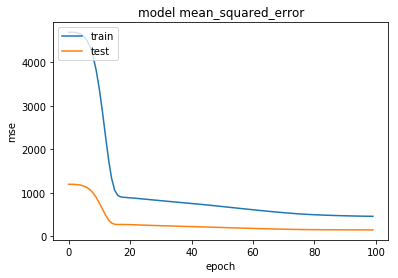

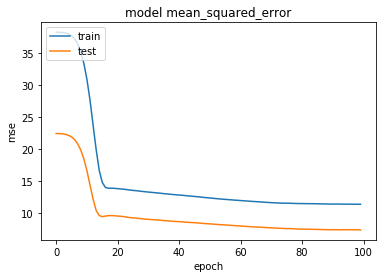

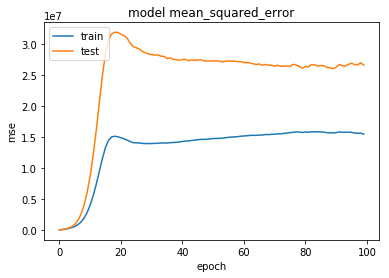

In [68]:
model = createModel("model")
history = model.fit(train_X, train_y, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_data=(test_X, test_y))

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_squared_error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean_squared_error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

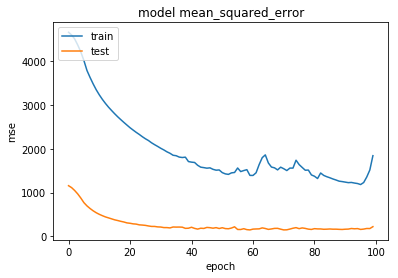

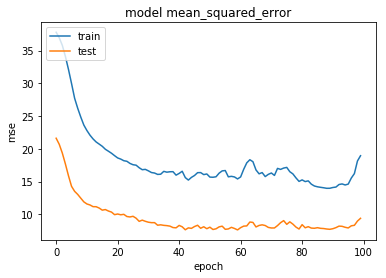

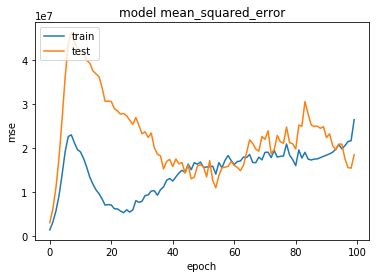

In [45]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(32, input_shape=(1, 4), return_sequences=False))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="linear"))
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae", "mape"])

history = model.fit(train_X, train_y, epochs=100, batch_size=32, verbose=0, shuffle=False, validation_data=(test_X, test_y))

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_squared_error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean_squared_error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

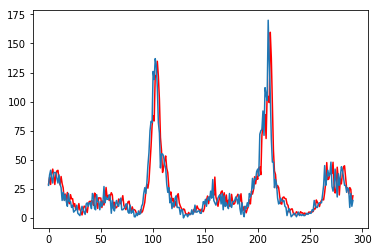

In [69]:
predictions = model.predict(test_X)
plt.plot(predictions, color='red')

plt.plot(test_y)
plt.show()

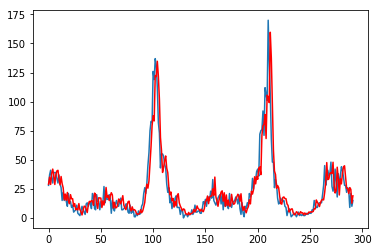

146.37434823161107


In [70]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_y, predictions)

plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()
print(error)